In [4]:
print("--- Bắt ĐẦU DỰ ÁN ---")

--- Bắt ĐẦU DỰ ÁN ---


--- BẮT ĐẦU XỬ LÝ 3 SNAPSHOTS BRUSSELS ---

>> Đang xử lý: 16 March, 2025
   -> Đã lưu xong: ..\processed\brussels\16 March, 2025

>> Đang xử lý: 21 June, 2025
   -> Đã lưu xong: ..\processed\brussels\21 June, 2025

>> Đang xử lý: 22 December, 2024
   -> Đã lưu xong: ..\processed\brussels\22 December, 2024

--- HOÀN TẤT ---
--- BẮT ĐẦU TÍNH TOÁN KPI FULL CHO: BRUSSELS ---

>> Đang xử lý snapshot: 16 March, 2025


C:\Users\Admin\AppData\Local\Temp\ipykernel_20076\3815330486.py:277: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  review_trends = df_rev.set_index('date').resample('M').size().reset_index(name='review_count')



>> Đang xử lý snapshot: 21 June, 2025


C:\Users\Admin\AppData\Local\Temp\ipykernel_20076\3815330486.py:277: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  review_trends = df_rev.set_index('date').resample('M').size().reset_index(name='review_count')



>> Đang xử lý snapshot: 22 December, 2024


C:\Users\Admin\AppData\Local\Temp\ipykernel_20076\3815330486.py:277: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  review_trends = df_rev.set_index('date').resample('M').size().reset_index(name='review_count')



✅ ĐÃ HOÀN TẤT! Đã tạo ra 5 file KPI:
   1. kpi_summary_general_brussels.csv
   2. kpi_room_type_brussels.csv
   3. kpi_seasonality_brussels.csv
   4. kpi_neighbourhood_brussels.csv
   5. kpi_reviews_trend_brussels.csv
--- BẮT ĐẦU VẼ CHUYÊN SÂU CHO BRUSSELS ---
--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---


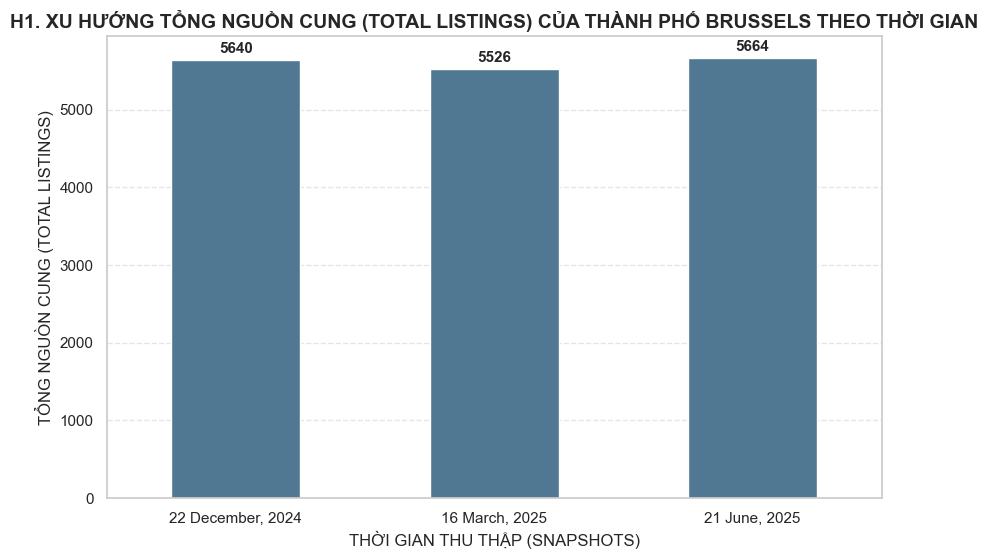

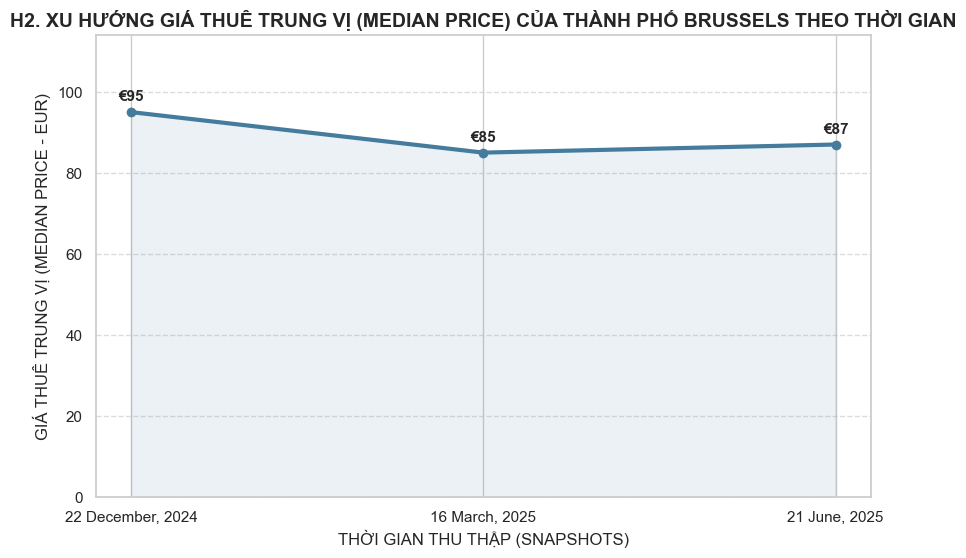

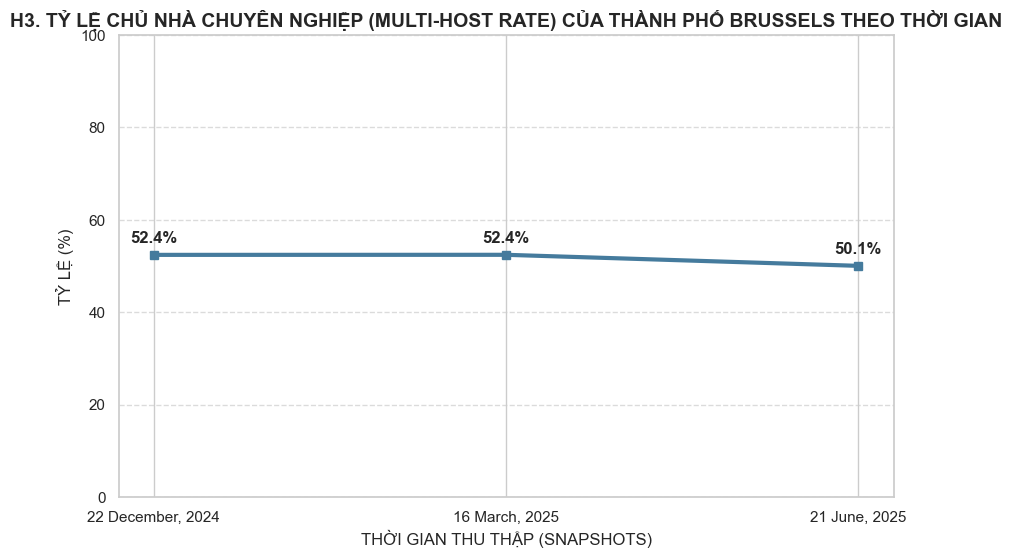

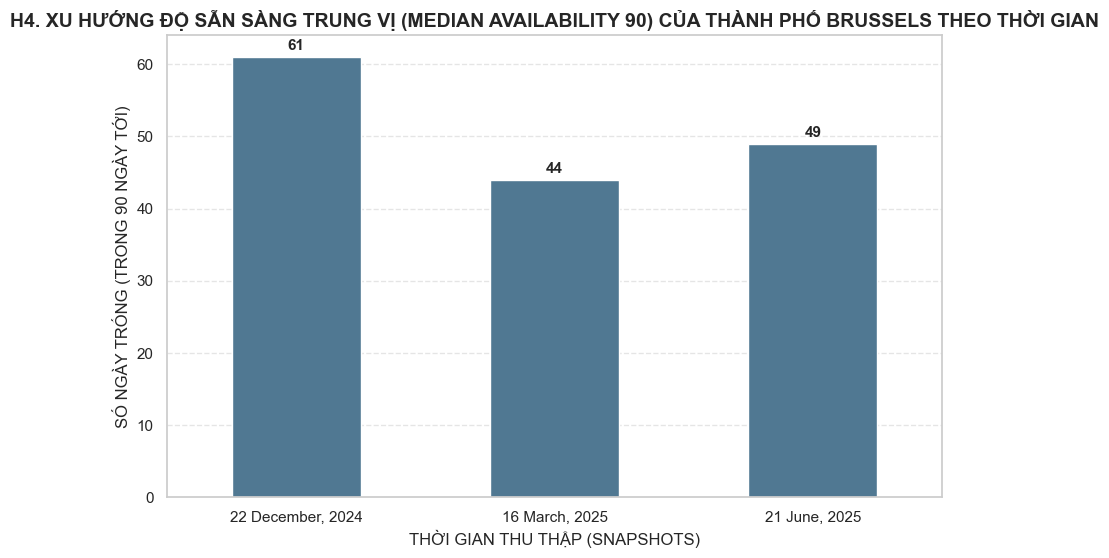

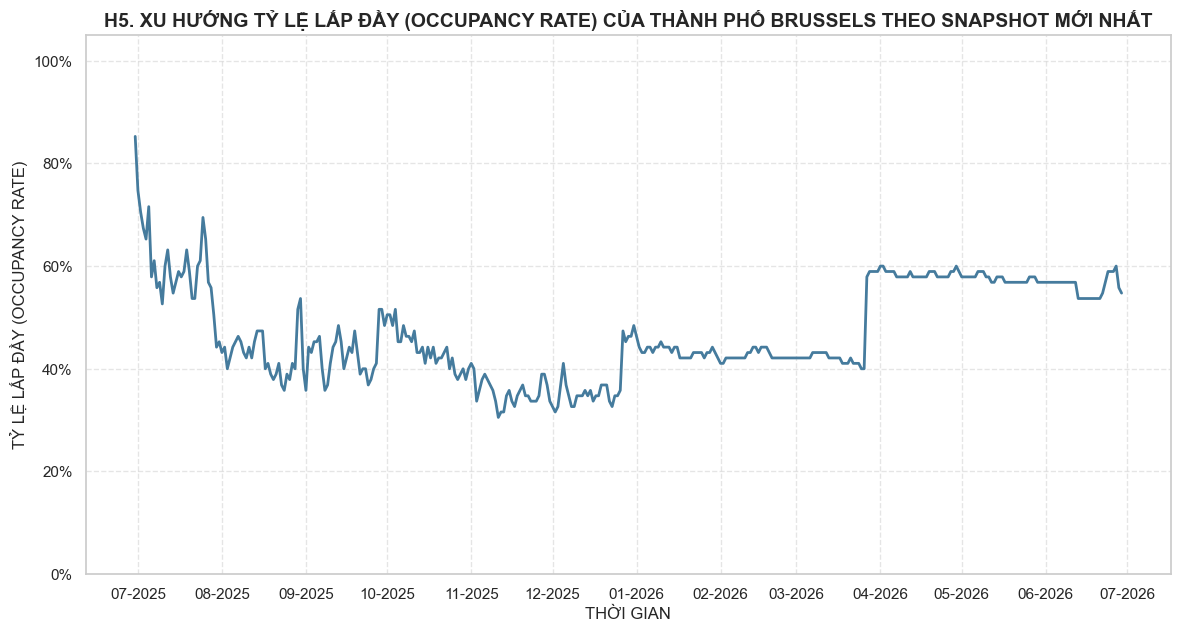

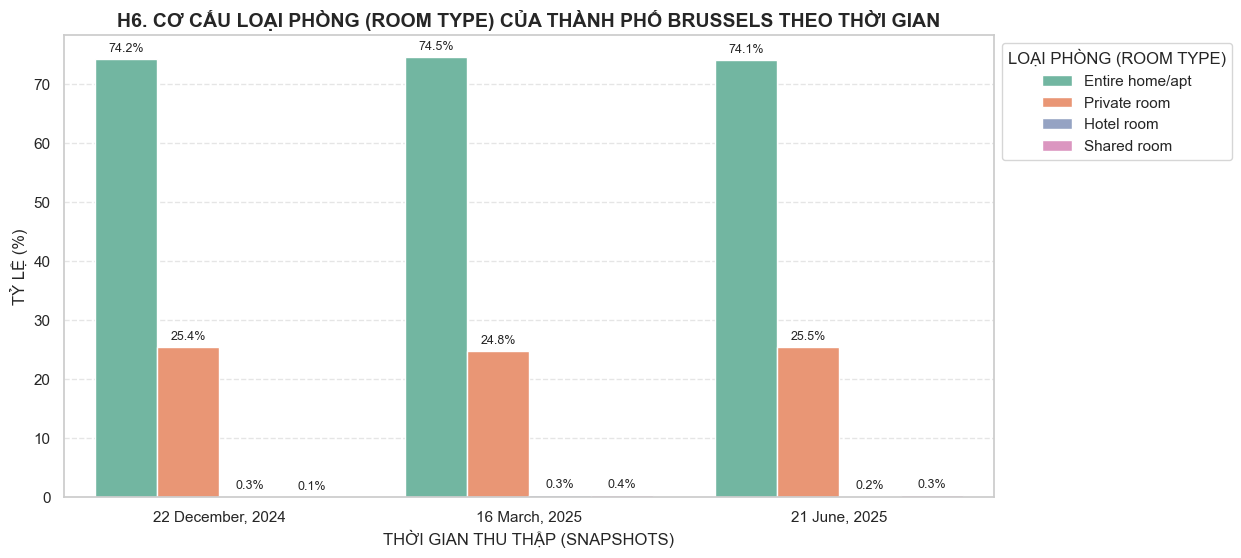

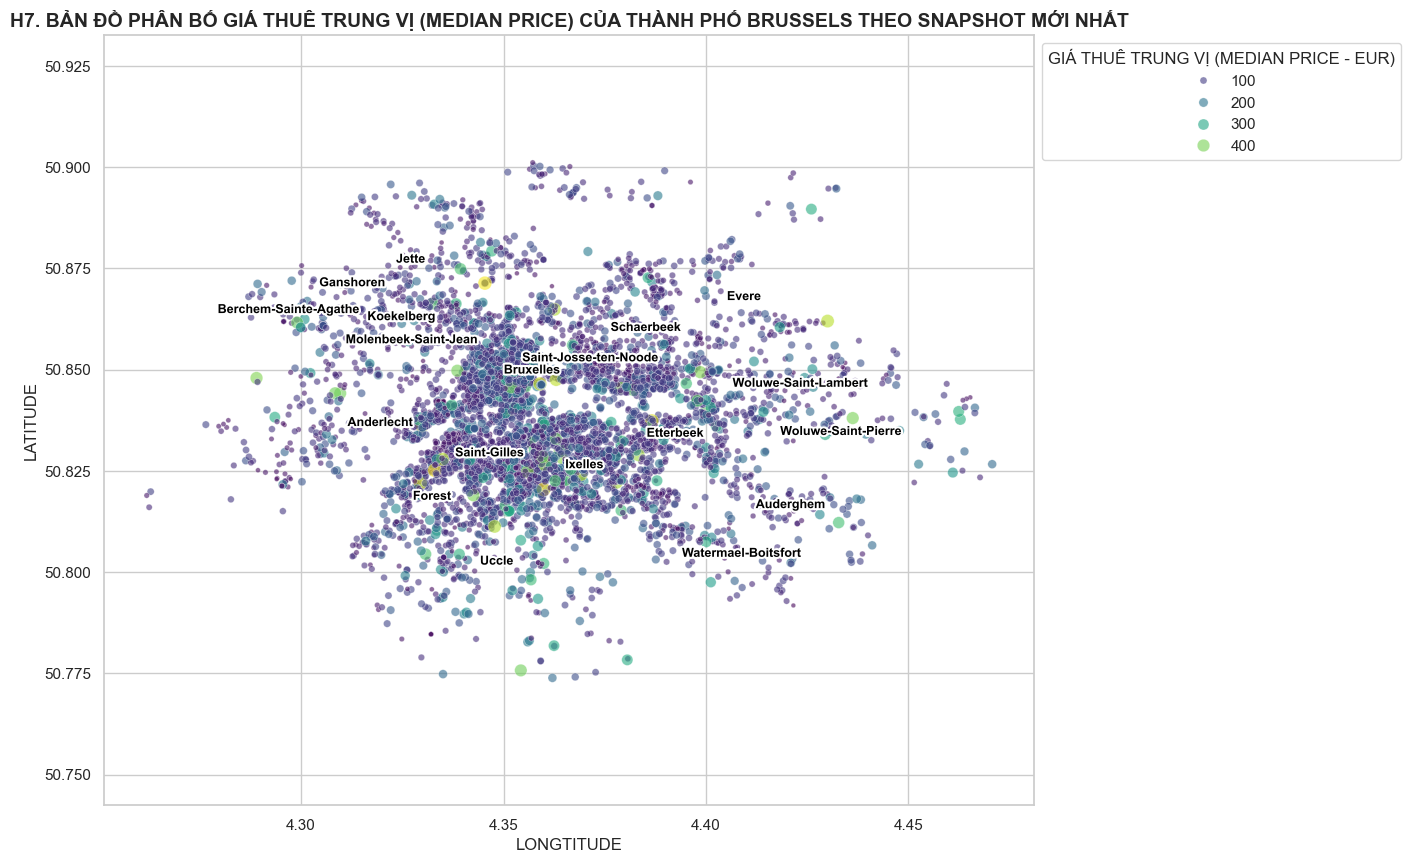

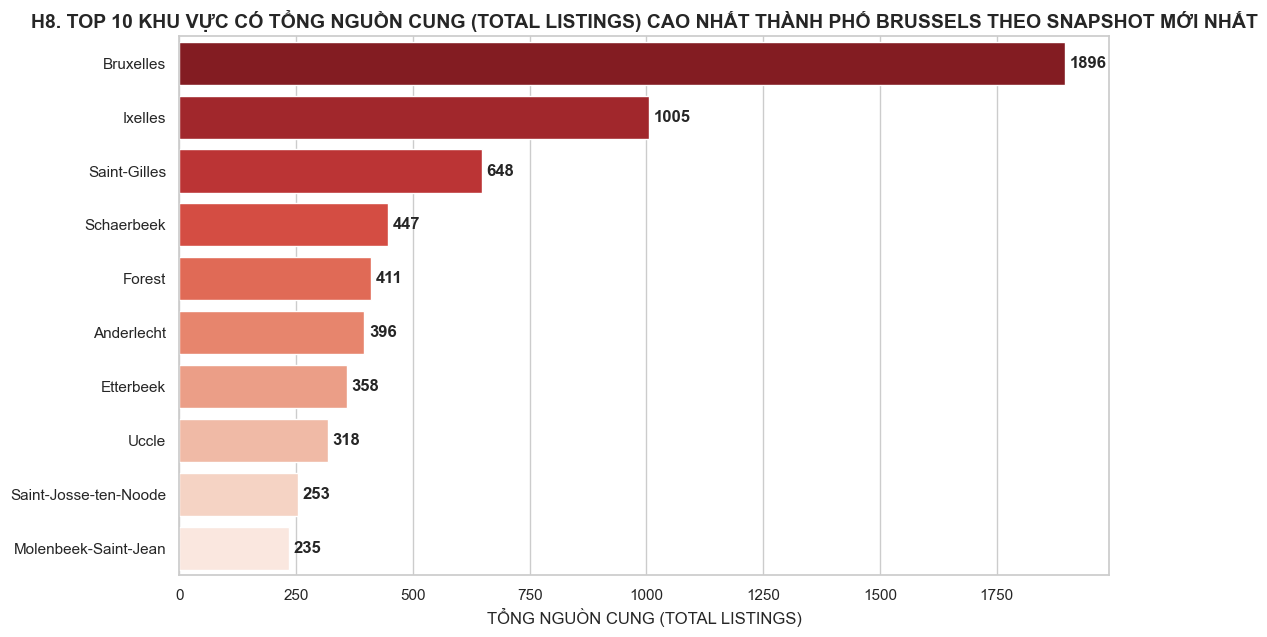

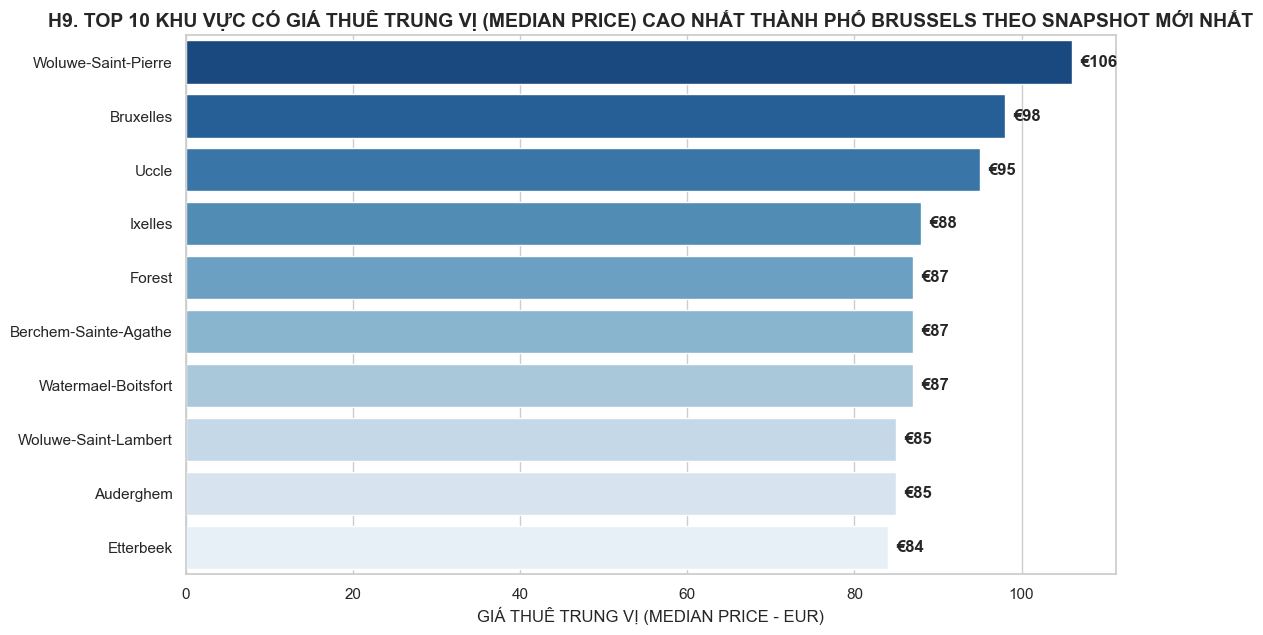

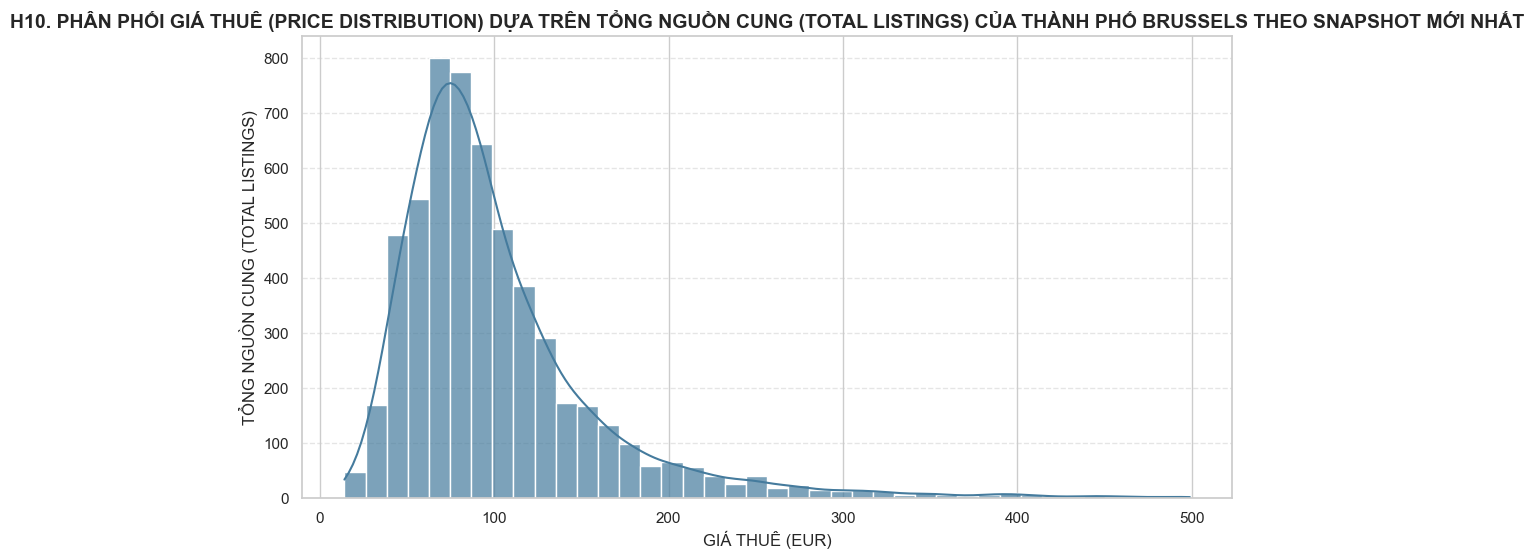

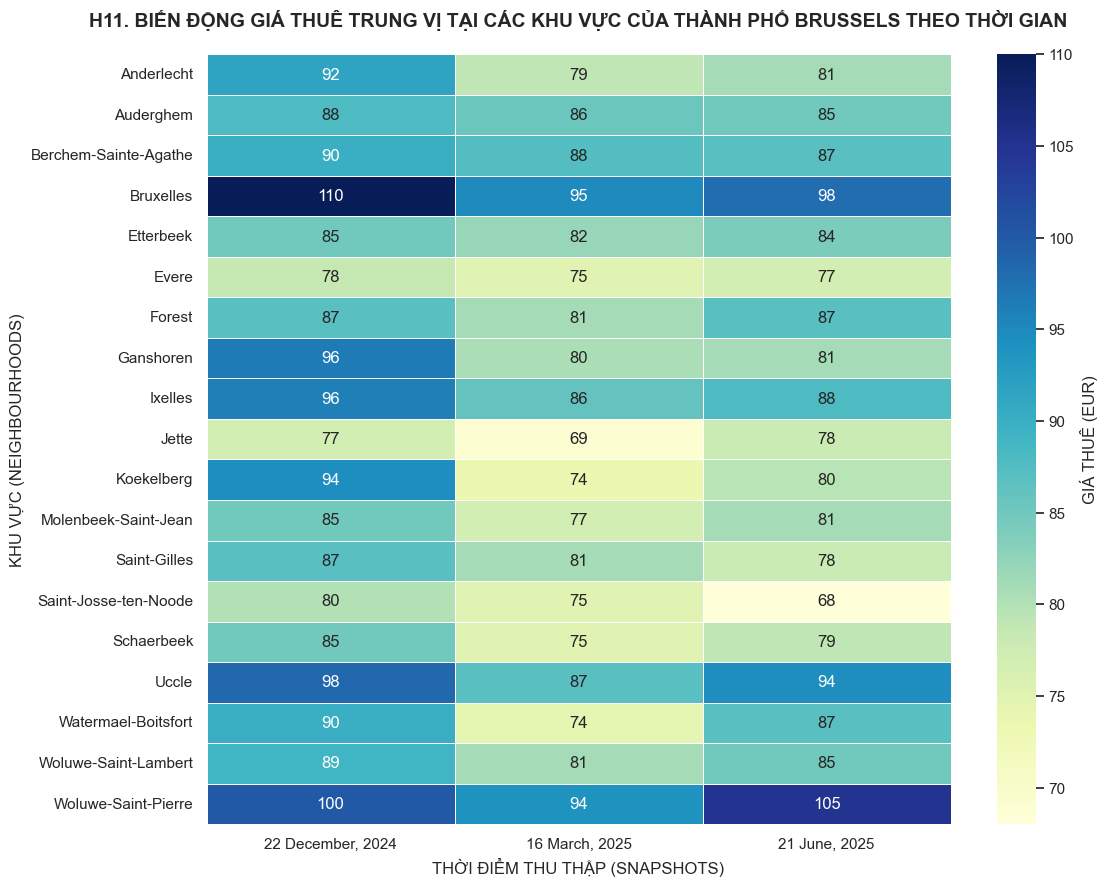

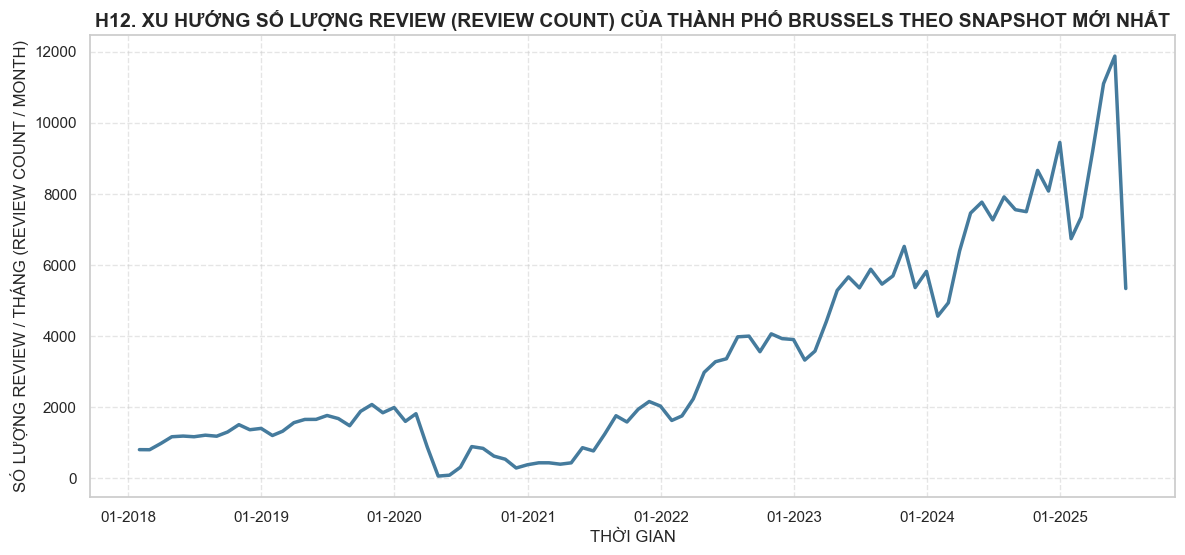

In [5]:
# THÀNH PHỐ BRUSSELS



import numpy as np
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from datetime import datetime



# LÀM SẠCH & CHUẨN HÓA

# CẤU HÌNH
BASE_DIR = '..'
RAW_DIR = os.path.join(BASE_DIR, 'raw', 'brussels')
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', 'brussels')
REPORTS_DIR = os.path.join(BASE_DIR, 'reports')

os.makedirs(PROCESSED_DIR, exist_ok = True)
os.makedirs(REPORTS_DIR, exist_ok = True)

# Bounding Box Brussels
CITY_LAT_MIN, CITY_LAT_MAX = 50.78, 50.92
CITY_LON_MIN, CITY_LON_MAX = 4.25, 4.45

# Hàm Clean Price chuẩn
def clean_price(price_value):
    if pd.isna(price_value): return np.nan
    if isinstance(price_value, (int, float)): return float(price_value)
    s = str(price_value).strip()
    match = re.search(r"[-+]?[0-9,.]+", s.replace('$', ''))
    if not match: return np.nan
    num = match.group(0).replace(',', '') 
    try: return float(num)
    except: return np.nan

# QUY TRÌNH XỬ LÝ 
snapshot_folders = [f for f in glob.glob(os.path.join(RAW_DIR, '*')) if os.path.isdir(f)]
qa_summary_list = []

print(f"--- BẮT ĐẦU XỬ LÝ {len(snapshot_folders)} SNAPSHOTS BRUSSELS ---")

for folder_path in snapshot_folders:
    snapshot_name = os.path.basename(folder_path)
    print(f"\n>> Đang xử lý: {snapshot_name}")

    try:
        listings_df = pd.read_csv(os.path.join(folder_path, 'listings.csv.gz'), low_memory=False)
        calendar_df = pd.read_csv(os.path.join(folder_path, 'calendar.csv.gz'), low_memory=False)
        reviews_df = pd.read_csv(os.path.join(folder_path, 'reviews.csv.gz'), low_memory=False)
        neigh_df = pd.read_csv(os.path.join(folder_path, 'neighbourhoods.csv'))
    except FileNotFoundError:
        print(f"   [!] Thiếu file trong folder {snapshot_name}, bỏ qua.")
        continue

    # ---------------------------------------------------------
    # 1. XỬ LÝ LISTINGS (Cơ bản & Toạ độ)
    # ---------------------------------------------------------
    listings_df['price_numeric'] = listings_df['price'].apply(clean_price)
    
    # [QA1] Flag Price <= 0
    listings_df['qa_flag_price_zero'] = listings_df['price_numeric'].fillna(0) <= 0
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA001_price_zero',
        'records_affected': int(listings_df['qa_flag_price_zero'].sum()),
        'handling_decision': 'Gắn cờ'
    })

    # Datetime & Coords
    listings_df['host_since'] = pd.to_datetime(listings_df['host_since'], errors='coerce')
    listings_df['latitude'] = pd.to_numeric(listings_df['latitude'], errors='coerce')
    listings_df['longitude'] = pd.to_numeric(listings_df['longitude'], errors='coerce')

    # [QA2] Check Coordinates Out of Bounds
    listings_df['qa_flag_out_of_city'] = (
        (listings_df['latitude'] < CITY_LAT_MIN) | (listings_df['latitude'] > CITY_LAT_MAX) |
        (listings_df['longitude'] < CITY_LON_MIN) | (listings_df['longitude'] > CITY_LON_MAX)
    )
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA002_coords_out_of_bounds',
        'records_affected': int(listings_df['qa_flag_out_of_city'].sum()),
        'handling_decision': 'Gắn cờ'
    })

    # [QA3] Duplicate IDs
    dups = listings_df.duplicated(subset=['id']).sum()
    if dups > 0:
        listings_df = listings_df.drop_duplicates(subset=['id'], keep='first')
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA003_duplicate_ids',
        'records_affected': int(dups),
        'handling_decision': 'Xoá dòng trùng'
    })

    # ---------------------------------------------------------
    # 2. XỬ LÝ NEIGHBOURHOOD 
    # ---------------------------------------------------------
    if 'neighbourhood_group' in neigh_df.columns: 
        neigh_df.drop(columns=['neighbourhood_group'], inplace=True)
    
    # Lấy danh sách quận chuẩn
    valid_neighbourhoods = set(neigh_df['neighbourhood'])
    
    # [QA4] Kiểm tra listing có thuộc quận hợp lệ không
    # (Nếu cột trong listings là 'neighbourhood_cleansed')
    col_neigh = 'neighbourhood_cleansed' if 'neighbourhood_cleansed' in listings_df.columns else 'neighbourhood'
    
    listings_df['qa_flag_invalid_neigh'] = ~listings_df[col_neigh].isin(valid_neighbourhoods)
    
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA004_invalid_neighbourhood',
        'records_affected': int(listings_df['qa_flag_invalid_neigh'].sum()),
        'handling_decision': 'Gắn cờ'
    })

    # ---------------------------------------------------------
    # 3. XỬ LÝ REVIEWS 
    # ---------------------------------------------------------
    reviews_df['date'] = pd.to_datetime(reviews_df['date'], errors='coerce')
    
    # Xóa các review không có nội dung (NaN comments)
    initial_reviews = len(reviews_df)
    reviews_df = reviews_df.dropna(subset=['comments'])
    
    # [QA5] Lọc bỏ Review của Listing không tồn tại (Orphaned Reviews)
    # Chỉ giữ lại review mà listing_id của nó có trong danh sách listings_df đã lọc
    valid_ids = set(listings_df['id'])
    reviews_df = reviews_df[reviews_df['listing_id'].isin(valid_ids)]
    
    removed_reviews = initial_reviews - len(reviews_df)
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA005_orphaned_or_empty_reviews',
        'records_affected': int(removed_reviews),
        'handling_decision': 'Xoá bỏ'
    })

    # ---------------------------------------------------------
    # 4. XỬ LÝ CALENDAR
    # ---------------------------------------------------------
    calendar_df['date'] = pd.to_datetime(calendar_df['date'], errors='coerce')
    calendar_df['price_numeric'] = calendar_df['price'].apply(clean_price)
    if 'adjusted_price' in calendar_df.columns: calendar_df.drop(columns=['adjusted_price'], inplace=True)
    
    # Chỉ giữ lại calendar của các listing hợp lệ (giảm dung lượng file)
    calendar_df = calendar_df[calendar_df['listing_id'].isin(valid_ids)]

    # ---------------------------------------------------------
    # 5. LƯU FILE
    # ---------------------------------------------------------
    out_dir = os.path.join(PROCESSED_DIR, snapshot_name)
    os.makedirs(out_dir, exist_ok=True)
    
    listings_df.to_csv(os.path.join(out_dir, 'listings_processed.csv'), index=False)
    calendar_df.to_csv(os.path.join(out_dir, 'calendar_processed.csv'), index=False)
    reviews_df.to_csv(os.path.join(out_dir, 'reviews_processed.csv'), index=False)
    neigh_df.to_csv(os.path.join(out_dir, 'neighbourhoods_processed.csv'), index=False)
    
    print(f"   -> Đã lưu xong: {out_dir}")

# Lưu báo cáo QA
pd.DataFrame(qa_summary_list).to_csv(os.path.join(REPORTS_DIR, 'qa_summary_brussels.csv'), index=False)
print("\n--- HOÀN TẤT ---")




# TỔNG HỢP & KPI

# CẤU HÌNH
pd.set_option('display.float_format', lambda x: '%.2f' % x)

BASE_DIR = '..'
CITY_FOLDER = 'brussels'  
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', CITY_FOLDER)
KPI_OUTPUT_DIR = os.path.join(BASE_DIR, 'processed', CITY_FOLDER) 

print(f"--- BẮT ĐẦU TÍNH TOÁN KPI FULL CHO: {CITY_FOLDER.upper()} ---")

# HÀM TÍNH TOÁN KPI CHO TỪNG SNAPSHOT
def calculate_snapshot_kpi(snapshot_path):
    snapshot_name = os.path.basename(snapshot_path)
    print(f"\n>> Đang xử lý snapshot: {snapshot_name}")
    
    
    try:
        df_list = pd.read_csv(os.path.join(snapshot_path, 'listings_processed.csv'), low_memory=False)
        df_cal = pd.read_csv(os.path.join(snapshot_path, 'calendar_processed.csv'), low_memory=False)
        
        try:
            df_rev = pd.read_csv(os.path.join(snapshot_path, 'reviews_processed.csv'), low_memory=False)
            df_rev['date'] = pd.to_datetime(df_rev['date'])
        except FileNotFoundError:
            df_rev = pd.DataFrame(columns=['listing_id', 'date']) 
            
    except FileNotFoundError:
        print("   [!] Không tìm thấy file listing/calendar. Bỏ qua.")
        return None, None, None, None, None

    # --- Lọc dữ liệu sạch (QA Filter) ---
    # Chỉ lấy listing không bị flag lỗi giá hoặc lỗi toạ độ
    # (Nếu cột qa_flag không tồn tại thì coi như hợp lệ)
    if 'qa_flag_price_zero' in df_list.columns:
        df_list = df_list[df_list['qa_flag_price_zero'] == False]
    if 'qa_flag_out_of_city' in df_list.columns:
        df_list = df_list[df_list['qa_flag_out_of_city'] == False]
        
    valid_listings = df_list.copy()
    valid_ids = valid_listings['id'].unique()
    
    # Lọc calendar chỉ chứa các listing hợp lệ
    valid_cal = df_cal[df_cal['listing_id'].isin(valid_ids)].copy()

    # ==============================================================================
    # PHẦN 1: KPI TỔNG HỢP & ROOM TYPE
    # ==============================================================================
    total_supply = len(valid_listings)
    
    # Multi-hosts
    host_counts = valid_listings['host_id'].value_counts()
    multi_host_rate = (host_counts[host_counts > 1].sum() / total_supply) * 100 if total_supply > 0 else 0

    # Median Price & Avail
    median_price = valid_listings['price_numeric'].median()
    median_avail_90 = valid_listings['availability_90'].median()
    
    # Room Type Stats
    room_stats = valid_listings['room_type'].value_counts(normalize=True).reset_index()
    room_stats.columns = ['room_type', 'percentage']
    room_stats['percentage'] = room_stats['percentage'] * 100
    room_stats['snapshot_date'] = snapshot_name

    # Summary Row
    summary_row = {
        'snapshot_date': snapshot_name,
        'total_listings': total_supply,
        'multi_host_rate': multi_host_rate,
        'median_price': median_price,
        'median_avail_90': median_avail_90
    }

    # ==============================================================================
    # PHẦN 2: SEASONALITY (CALENDAR)
    # ==============================================================================
    valid_cal['date'] = pd.to_datetime(valid_cal['date'])
    valid_cal['is_booked'] = valid_cal['available'].apply(lambda x: 1 if x == 'f' else 0)
    
    daily_occupancy = valid_cal.groupby('date')['is_booked'].mean().reset_index()
    daily_occupancy.columns = ['date', 'occupancy_rate']
    daily_occupancy['snapshot_date'] = snapshot_name

    # ==============================================================================
    # PHẦN 3: NEIGHBOURHOOD 
    # ==============================================================================
    # Dùng cột neighbourhood_cleansed hoặc neighbourhood
    col_neigh = 'neighbourhood_cleansed' if 'neighbourhood_cleansed' in valid_listings.columns else 'neighbourhood'
    
    neigh_stats = valid_listings.groupby(col_neigh).agg({
        'id': 'count',
        'price_numeric': 'median'
    }).reset_index()
    neigh_stats.columns = ['neighbourhood', 'listing_count', 'median_price']
    neigh_stats['snapshot_date'] = snapshot_name

    # ==============================================================================
    # PHẦN 4: REVIEW TRENDS 
    # ==============================================================================
    # Resample theo tháng
    if not df_rev.empty:
        review_trends = df_rev.set_index('date').resample('M').size().reset_index(name='review_count')
        review_trends['snapshot_date'] = snapshot_name
        # Chỉ lấy dữ liệu review của 2 năm gần nhất so với snapshot để giảm nhiễu
        # (Tuỳ chọn: Nếu muốn lấy hết thì bỏ dòng lọc này)
    else:
        review_trends = pd.DataFrame()

    return summary_row, room_stats, daily_occupancy, neigh_stats, review_trends

# CHẠY VÒNG LẶP & TỔNG HỢP
all_snapshots = glob.glob(os.path.join(PROCESSED_DIR, '*'))
summary_list = []
room_stats_list = []
occupancy_list = []
neigh_stats_list = []
review_stats_list = []

for folder in all_snapshots:
    if os.path.isdir(folder):
        res_sum, res_room, res_occ, res_neigh, res_rev = calculate_snapshot_kpi(folder)
        if res_sum:
            summary_list.append(res_sum)
            room_stats_list.append(res_room)
            occupancy_list.append(res_occ)
            neigh_stats_list.append(res_neigh)
            if not res_rev.empty: review_stats_list.append(res_rev)

# GỘP & LƯU FILE
if summary_list:
    # 4.1 Summary General
    df_summary = pd.DataFrame(summary_list).sort_values('snapshot_date')
    df_summary.to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_summary_general_{CITY_FOLDER}.csv'), index=False)
    
    # 4.2 Room Type
    if room_stats_list:
        pd.concat(room_stats_list).to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_room_type_{CITY_FOLDER}.csv'), index=False)
    
    # 4.3 Seasonality
    if occupancy_list:
        pd.concat(occupancy_list).to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_seasonality_{CITY_FOLDER}.csv'), index=False)

    # 4.4 Neighbourhood 
    if neigh_stats_list:
        pd.concat(neigh_stats_list).to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_neighbourhood_{CITY_FOLDER}.csv'), index=False)

    # 4.5 Review Trends 
    if review_stats_list:
        pd.concat(review_stats_list).to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_reviews_trend_{CITY_FOLDER}.csv'), index=False)

    print("\n✅ ĐÃ HOÀN TẤT! Đã tạo ra 5 file KPI:")
    print(f"   1. kpi_summary_general_{CITY_FOLDER}.csv")
    print(f"   2. kpi_room_type_{CITY_FOLDER}.csv")
    print(f"   3. kpi_seasonality_{CITY_FOLDER}.csv")
    print(f"   4. kpi_neighbourhood_{CITY_FOLDER}.csv")
    print(f"   5. kpi_reviews_trend_{CITY_FOLDER}.csv")

else:
    print("Không có dữ liệu để tính toán.")




# TRỰC QUAN HÓA


# THIẾT LẬP 
sns.set_theme(style="whitegrid")
BASE_DIR = '..'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', 'brussels')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)
CITY_SUFFIX = 'brussels'

print("--- BẮT ĐẦU VẼ CHUYÊN SÂU CHO BRUSSELS ---")

# NẠP DỮ LIỆU KPI 
try:
    kpi_neigh = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_neighbourhood_{CITY_SUFFIX}.csv'))
    kpi_review = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_reviews_trend_{CITY_SUFFIX}.csv'))
except FileNotFoundError:
    kpi_neigh = pd.DataFrame()
    kpi_review = pd.DataFrame()

try:
    # Load các file KPI đã tạo
    kpi_supply = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_summary_general_{CITY_SUFFIX}.csv'))
    kpi_room = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_room_type_{CITY_SUFFIX}.csv'))
    kpi_season = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_seasonality_{CITY_SUFFIX}.csv'))

    # Hàm sắp xếp thời gian
    def sort_by_date(df, date_col='snapshot_date'):
        df['dt'] = pd.to_datetime(df[date_col], errors='coerce')
        return df.sort_values('dt')

    kpi_supply = sort_by_date(kpi_supply)
    # kpi_room và kpi_season sẽ xử lý riêng khi vẽ
    print("--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---")
except FileNotFoundError as e:
    print(f"❌ Lỗi: Không tìm thấy file KPI. Chi tiết: {e}")
    kpi_supply = pd.DataFrame() 

# NẠP DỮ LIỆU CHI TIẾT (LATEST SNAPSHOT)

def parse_snapshot_name(name):
    """
    Parse tên thư mục snapshot dạng '21 June, 2025' thành datetime.
    Trả về None nếu parse thất bại.
    """
    try:
        return datetime.strptime(name.strip(), "%d %B, %Y")
    except:
        return None

df_detail = pd.DataFrame()
LATEST_SNAPSHOT = "Unknown"

if os.path.exists(PROCESSED_DIR):

    # Lấy danh sách thư mục + chỉ giữ thư mục có format date hợp lệ
    raw_snaps = [
        d for d in os.listdir(PROCESSED_DIR)
        if os.path.isdir(os.path.join(PROCESSED_DIR, d))
    ]

    # Parse + giữ lại snapshot hợp lệ
    snapshots = [s for s in raw_snaps if parse_snapshot_name(s) is not None]

    # Sort theo ngày (mới nhất trước)
    snapshots = sorted(
        snapshots,
        key=lambda x: parse_snapshot_name(x),
        reverse=True
    )

    # Lấy file mới nhất
    for snap in snapshots:
        file_path = os.path.join(PROCESSED_DIR, snap, 'listings_processed.csv')
        if os.path.exists(file_path):
            try:
                temp = pd.read_csv(file_path, low_memory=False)
                if not temp.empty and 'price_numeric' in temp.columns:
                    df_detail = temp
                    LATEST_SNAPSHOT = snap
                    break
            except:
                continue


# VẼ BIỂU ĐỒ 

# === H1: Xu hướng Nguồn Cung (Bar Chart) ===
if not kpi_supply.empty:
    plt.figure(figsize=(10, 6))
    ax1 = sns.barplot(data=kpi_supply, x='snapshot_date', y='total_listings', color='#457B9D', width=0.5)
    plt.title('H1. XU HƯỚNG TỔNG NGUỒN CUNG (TOTAL LISTINGS) CỦA THÀNH PHỐ BRUSSELS THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i in ax1.containers: ax1.bar_label(i, padding=3, fontsize=11, fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_01_supply.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


# === H2: Xu hướng Giá (Line/Area Chart) ===
if not kpi_supply.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(kpi_supply['snapshot_date'], kpi_supply['median_price'], marker='o', linewidth=3, color='#457B9D')
    plt.fill_between(kpi_supply['snapshot_date'], kpi_supply['median_price'], color='#457B9D', alpha=0.1)
    plt.title('H2. XU HƯỚNG GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CỦA THÀNH PHỐ BRUSSELS THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for x, y in zip(kpi_supply['snapshot_date'], kpi_supply['median_price']):
        plt.text(x, y + 2, f"€{y:.0f}", ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.ylim(bottom=0, top=kpi_supply['median_price'].max()*1.2)
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_02_price.pdf'), format='pdf', bbox_inches='tight')
    plt.show()

# === H3: XU HƯỚNG TỶ LỆ CHỦ NHÀ CHUYÊN NGHIỆP (MULTI-HOST RATE) ===
if not kpi_supply.empty and 'multi_host_rate' in kpi_supply.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(kpi_supply['snapshot_date'], kpi_supply['multi_host_rate'], marker='s', linewidth=3, color='#457B9D')
    
    plt.title(f'H3. TỶ LỆ CHỦ NHÀ CHUYÊN NGHIỆP (MULTI-HOST RATE) CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 100) # Tỷ lệ luôn trong thang 0-100
    
    # Hiển thị số % trên điểm
    for x, y in zip(kpi_supply['snapshot_date'], kpi_supply['multi_host_rate']):
        plt.text(x, y + 2, f"{y:.1f}%", ha='center', va='bottom', fontweight='bold')
        
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_03_multi_host.pdf'), format='pdf', bbox_inches='tight')
    plt.show()



# === H4: XU HƯỚNG ĐỘ SẴN SÀNG (AVAILABILITY 90) ===
if not kpi_supply.empty and 'median_avail_90' in kpi_supply.columns:
    plt.figure(figsize=(10, 6))
    ax12 = sns.barplot(data=kpi_supply, x='snapshot_date', y='median_avail_90', color='#457B9D', width=0.5)
    
    plt.title(f'H4. XU HƯỚNG ĐỘ SẴN SÀNG TRUNG VỊ (MEDIAN AVAILABILITY 90) CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('SỐ NGÀY TRỐNG (TRONG 90 NGÀY TỚI)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Label
    for i in ax12.containers: ax12.bar_label(i, padding=3, fontsize=11, fontweight='bold')
        
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_04_availability.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


# === H5: Xu hướng Lấp đầy (Occupancy Rate - Line Chart) ===
if not kpi_season.empty:
    df_h5 = kpi_season.copy()
    # Chuyển đổi ngày tháng
    df_h5['date_dt'] = pd.to_datetime(df_h5['date'], errors='coerce')
    df_h5['snapshot_dt'] = pd.to_datetime(df_h5['snapshot_date'], errors='coerce')
    
    # Lấy dữ liệu từ snapshot MỚI NHẤT
    latest_snap_dt = df_h5['snapshot_dt'].max()
    df_final_h5 = df_h5[df_h5['snapshot_dt'] == latest_snap_dt].sort_values('date_dt')

    if not df_final_h5.empty:
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=df_final_h5, x='date_dt', y='occupancy_rate', color='#457B9D', linewidth=2)
        
        # Format trục
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

        plt.title(f'H5. XU HƯỚNG TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE) CỦA THÀNH PHỐ BRUSSELS THEO SNAPSHOT MỚI NHẤT', 
                  fontsize=14, fontweight='bold')
        plt.ylabel('TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE)')
        plt.xlabel('THỜI GIAN')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.ylim(0, 1.05)
        
        
        plt.savefig(os.path.join(FIGURES_DIR, 'brussels_05_occupancy.pdf'), format='pdf', bbox_inches='tight')
        plt.show()
        
    else:
        print("   ! Không có dữ liệu occupancy cho snapshot mới nhất.")
else:
    print("   ! Không có dữ liệu seasonality.")


# === H6: Cơ cấu Loại phòng (Grouped Bar) ===
if not kpi_room.empty:
    plt.figure(figsize=(12, 6))
    kpi_room['dt'] = pd.to_datetime(kpi_room['snapshot_date'], errors='coerce')
    kpi_room = kpi_room.sort_values('dt')
    
    ax3 = sns.barplot(data=kpi_room, x='snapshot_date', y='percentage', hue='room_type', palette='Set2')
    plt.title('H6. CƠ CẤU LOẠI PHÒNG (ROOM TYPE) CỦA THÀNH PHỐ BRUSSELS THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.legend(title='LOẠI PHÒNG (ROOM TYPE)', bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i in ax3.containers: ax3.bar_label(i, fmt='%.1f%%', padding=3, fontsize=9)
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_06_room_type.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


# === H7: Bản đồ Phân bố Listing (Scatter Map) ===
if not df_detail.empty and 'latitude' in df_detail.columns:
    plt.figure(figsize=(12, 10))
    
    # Vẽ điểm (lọc giá < 500)
    sns.scatterplot(
        data=df_detail[df_detail['price_numeric'] < 500], 
        x='longitude', y='latitude', 
        hue='price_numeric', palette='viridis', 
        size='price_numeric', sizes=(10, 100), alpha=0.6,
        legend='brief'
    )

    # Gắn nhãn tên khu vực
    if 'neighbourhood_cleansed' in df_detail.columns:
        neigh_centers = df_detail.groupby('neighbourhood_cleansed')[['latitude', 'longitude']].mean().reset_index()
        for i, row in neigh_centers.iterrows():
            txt = plt.text(
                row['longitude'], row['latitude'], 
                row['neighbourhood_cleansed'], 
                fontsize=9, fontweight='bold', color='black',
                ha='center', va='center'
            )
            txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

    plt.title(f'H7. BẢN ĐỒ PHÂN BỐ GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CỦA THÀNH PHỐ BRUSSELS THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('LONGTITUDE')
    plt.ylabel('LATITUDE')
    plt.legend(title='GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)', bbox_to_anchor=(1, 1), loc='upper left')
    plt.axis('equal') 
    
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_07_map_labeled.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    

# === H8: TOP 10 KHU VỰC CÓ NHIỀU LISTINGS NHẤT ===
if not df_detail.empty and 'neighbourhood_cleansed' in df_detail.columns:
    top_supply_neigh = df_detail['neighbourhood_cleansed'].value_counts().head(10).reset_index()
    top_supply_neigh.columns = ['neighbourhood_cleansed', 'count']

    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=top_supply_neigh,
        y='neighbourhood_cleansed',
        x='count',
        palette='Reds_r',
        hue='neighbourhood_cleansed',
        legend=False
    )
    plt.title(f'H8. TOP 10 KHU VỰC CÓ TỔNG NGUỒN CUNG (TOTAL LISTINGS) CAO NHẤT THÀNH PHỐ BRUSSELS THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.ylabel('')
    for i, v in enumerate(top_supply_neigh['count']):
        plt.text(v + 10, i, f"{v}", va='center', fontweight='bold')
        
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_08_top10_supply.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


# === H9: Top 10 Khu vực Đắt đỏ nhất (Bar Chart) ===
if not df_detail.empty and 'neighbourhood_cleansed' in df_detail.columns:
    neigh_price = df_detail.groupby('neighbourhood_cleansed')['price_numeric'].median().sort_values(ascending=False).head(10).reset_index()

    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=neigh_price, 
        y='neighbourhood_cleansed', 
        x='price_numeric', 
        palette='Blues_r', 
        hue='neighbourhood_cleansed', 
        legend=False
    )
    plt.title(f'H9. TOP 10 KHU VỰC CÓ GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CAO NHẤT THÀNH PHỐ BRUSSELS THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.ylabel('')
    for i, v in enumerate(neigh_price['price_numeric']):
        plt.text(v + 1, i, f"€{v:.0f}", va='center', fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_09_top10_price.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


# === H10: PHÂN PHỐI GIÁ THUÊ (HISTOGRAM + KDE) ===
if not df_detail.empty and 'price_numeric' in df_detail.columns:
    plt.figure(figsize=(12, 6))
    
    sns.histplot(
        df_detail[df_detail['price_numeric'] < 500]['price_numeric'],
        kde=True,
        bins=40,
        color='#457B9D',
        alpha=0.7
    )
    
    plt.title(f'H10. PHÂN PHỐI GIÁ THUÊ (PRICE DISTRIBUTION) DỰA TRÊN TỔNG NGUỒN CUNG (TOTAL LISTINGS) CỦA THÀNH PHỐ BRUSSELS THEO SNAPSHOT MỚI NHẤT',
              fontsize=14, fontweight='bold')
    plt.xlabel('GIÁ THUÊ (EUR)')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_10_price_distribution.pdf'), 
                format='pdf', bbox_inches='tight')
    plt.show()
    


# === H11: HEATMAP BIẾN ĐỘNG GIÁ THEO KHU VỰC (PHIÊN BẢN TỐI ƯU) ===
if not kpi_neigh.empty:
    # 1. Lọc lấy Top 20 khu vực có nhiều phòng nhất (để Heatmap đỡ rối)
    top_areas = kpi_neigh.groupby('neighbourhood')['listing_count'].sum().sort_values(ascending=False).head(20).index
    df_heat = kpi_neigh[kpi_neigh['neighbourhood'].isin(top_areas)].copy()
    
    # 2. Pivot bảng
    heatmap_data = df_heat.pivot_table(index='neighbourhood', columns='snapshot_date', values='median_price')
    
    # 3. Sắp xếp cột theo thời gian
    sorted_cols = sorted(heatmap_data.columns, key=parse_snapshot_name)
    heatmap_data = heatmap_data[sorted_cols]

    # 4. Vẽ Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=.5, cbar_kws={'label': 'GIÁ THUÊ (EUR)'})
    
    plt.title(f'H11. BIẾN ĐỘNG GIÁ THUÊ TRUNG VỊ TẠI CÁC KHU VỰC CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO THỜI GIAN', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('THỜI ĐIỂM THU THẬP (SNAPSHOTS)')
    plt.ylabel('KHU VỰC (NEIGHBOURHOODS)')
    
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_11_price_heatmap_optimized.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Không có dữ liệu KPI Neighbourhood để vẽ H11.")



# === H12: XU HƯỚNG LƯỢNG REVIEW (NHU CẦU DU LỊCH) ===
if not kpi_review.empty:
    plt.figure(figsize=(14, 6))
    
    # 1. Tìm snapshot mới nhất (Logic chuẩn xác nhất)
    kpi_review['snap_dt'] = pd.to_datetime(kpi_review['snapshot_date'], errors='coerce')
    latest_snap_date = kpi_review['snap_dt'].max()
    
    # 2. Chỉ lọc lấy dữ liệu review của snapshot đó
    df_rev_final = kpi_review[kpi_review['snap_dt'] == latest_snap_date].copy()
    
    # 3. Xử lý ngày tháng
    df_rev_final['date'] = pd.to_datetime(df_rev_final['date'])
    df_rev_final = df_rev_final.sort_values('date')
    
    # 4. Lọc năm (2018 trở lại)
    df_rev_final = df_rev_final[df_rev_final['date'].dt.year >= 2018]

    # 5. Vẽ
    sns.lineplot(data=df_rev_final, x='date', y='review_count', color='#457B9D', linewidth=2.5)
    
    plt.title(f'H12. XU HƯỚNG SỐ LƯỢNG REVIEW (REVIEW COUNT) CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.ylabel('SỐ LƯỢNG REVIEW / THÁNG (REVIEW COUNT / MONTH)')
    plt.xlabel('THỜI GIAN')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_12_reviews_trend.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Không có dữ liệu Review Trend để vẽ H12.")








--- BẮT ĐẦU XỬ LÝ 4 SNAPSHOTS BERLIN ---

>> Đang xử lý: 15 March, 2025
   -> Đã lưu xong: ..\processed\berlin\15 March, 2025

>> Đang xử lý: 20 June, 2025
   -> Đã lưu xong: ..\processed\berlin\20 June, 2025

>> Đang xử lý: 21 December, 2024
   -> Đã lưu xong: ..\processed\berlin\21 December, 2024

>> Đang xử lý: 23 September, 2025
   -> Đã lưu xong: ..\processed\berlin\23 September, 2025

--- HOÀN TẤT ---
--- BẮT ĐẦU TÍNH TOÁN KPI FULL CHO: BERLIN ---

>> Đang xử lý snapshot: 15 March, 2025


C:\Users\Admin\AppData\Local\Temp\ipykernel_20076\1678476231.py:275: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  review_trends = df_rev.set_index('date').resample('M').size().reset_index(name='review_count')



>> Đang xử lý snapshot: 20 June, 2025


C:\Users\Admin\AppData\Local\Temp\ipykernel_20076\1678476231.py:275: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  review_trends = df_rev.set_index('date').resample('M').size().reset_index(name='review_count')



>> Đang xử lý snapshot: 21 December, 2024


C:\Users\Admin\AppData\Local\Temp\ipykernel_20076\1678476231.py:275: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  review_trends = df_rev.set_index('date').resample('M').size().reset_index(name='review_count')



>> Đang xử lý snapshot: 23 September, 2025


C:\Users\Admin\AppData\Local\Temp\ipykernel_20076\1678476231.py:275: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  review_trends = df_rev.set_index('date').resample('M').size().reset_index(name='review_count')
C:\Users\Admin\AppData\Local\Temp\ipykernel_20076\1678476231.py:314: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(occupancy_list).to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_seasonality_{CITY_FOLDER}.csv'), index=False)



✅ ĐÃ HOÀN TẤT! Đã tạo ra 5 file KPI:
   1. kpi_summary_general_berlin.csv
   2. kpi_room_type_berlin.csv
   3. kpi_seasonality_berlin.csv
   4. kpi_neighbourhood_berlin.csv
   5. kpi_reviews_trend_berlin.csv
--- BẮT ĐẦU VẼ CHUYÊN SÂU CHO BERLIN ---
--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---


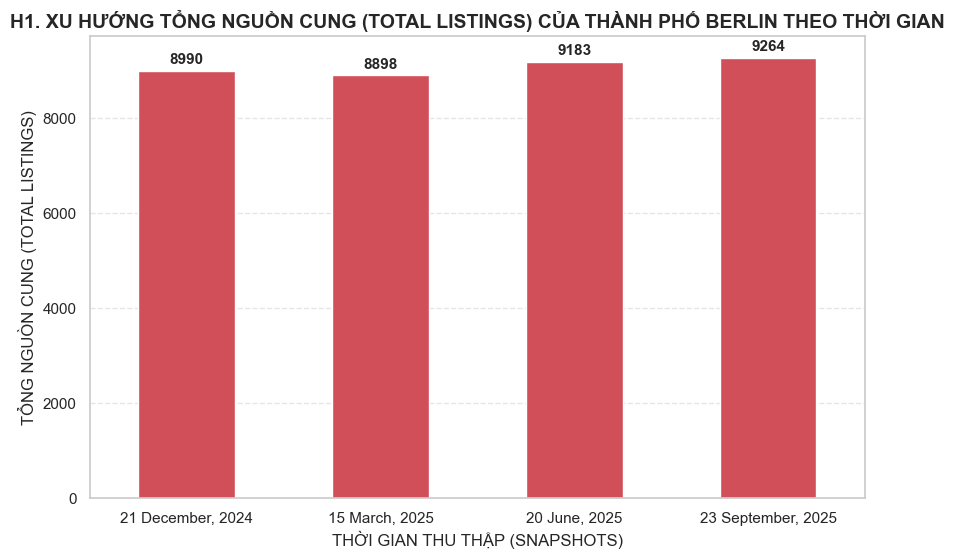

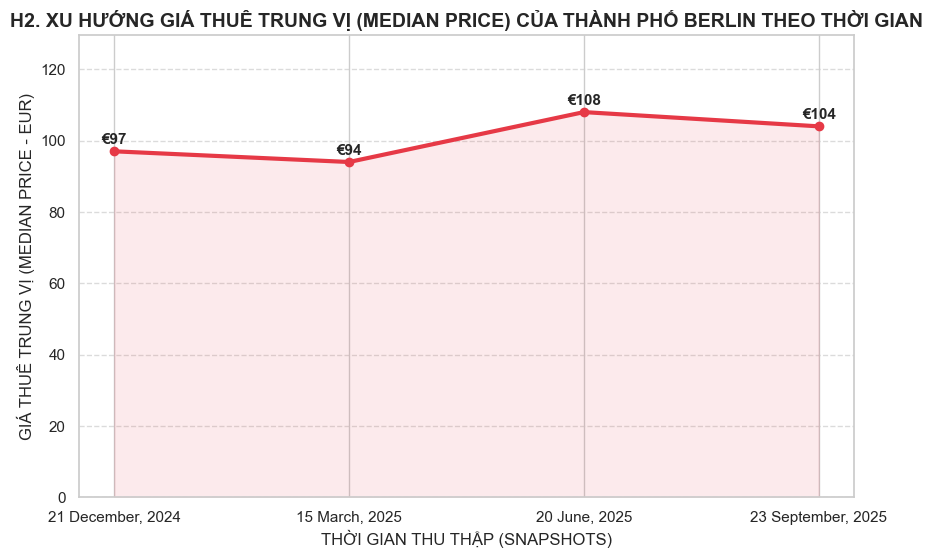

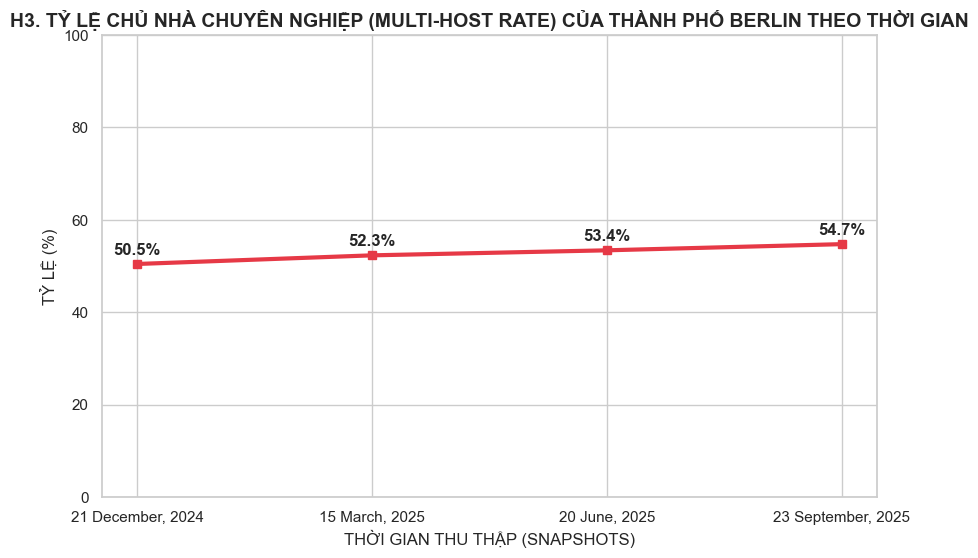

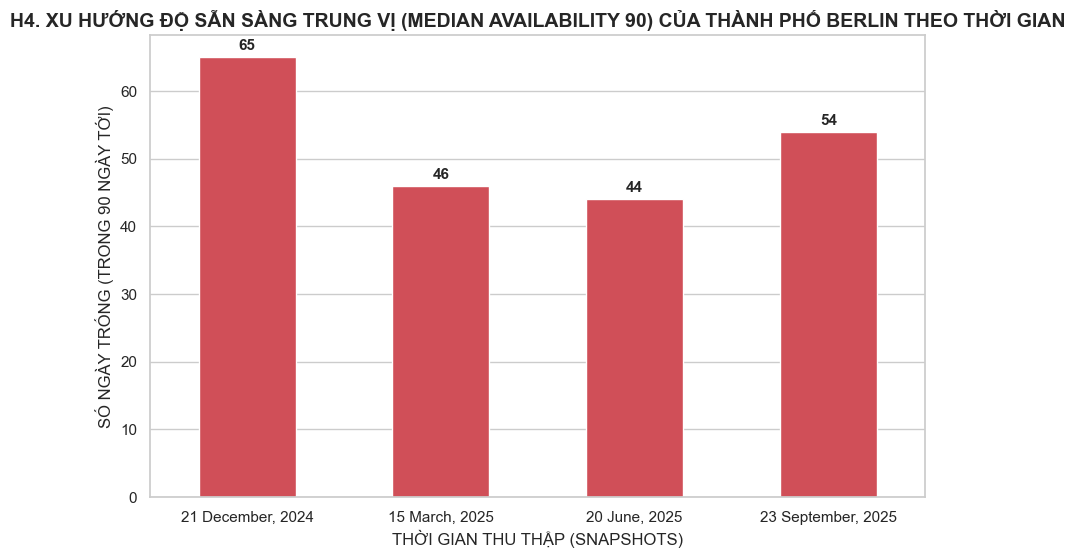

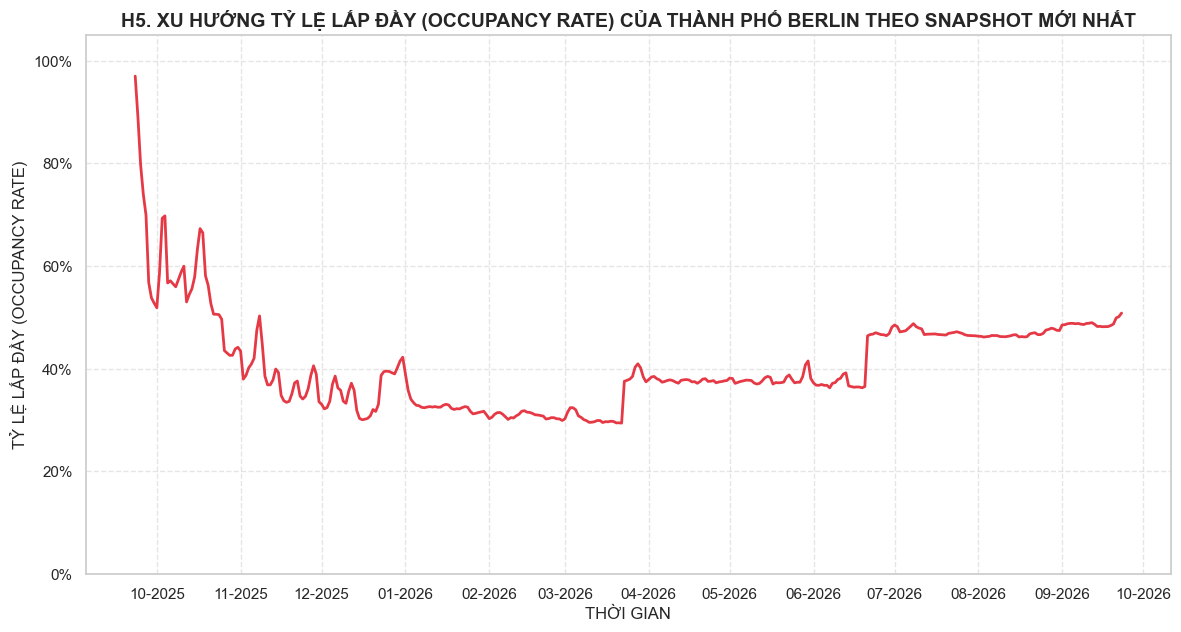

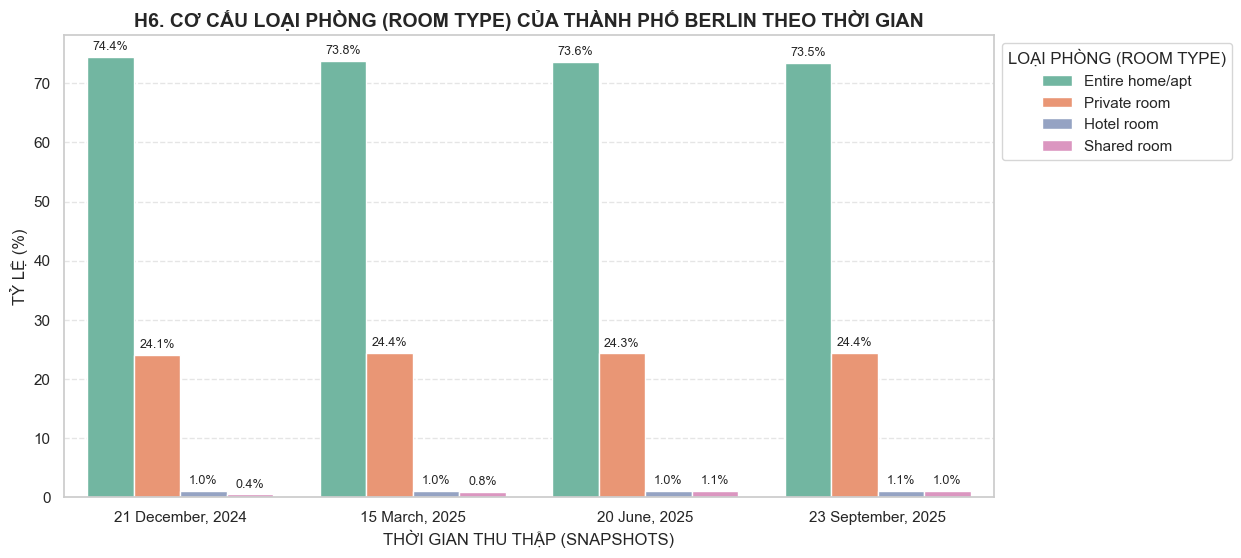

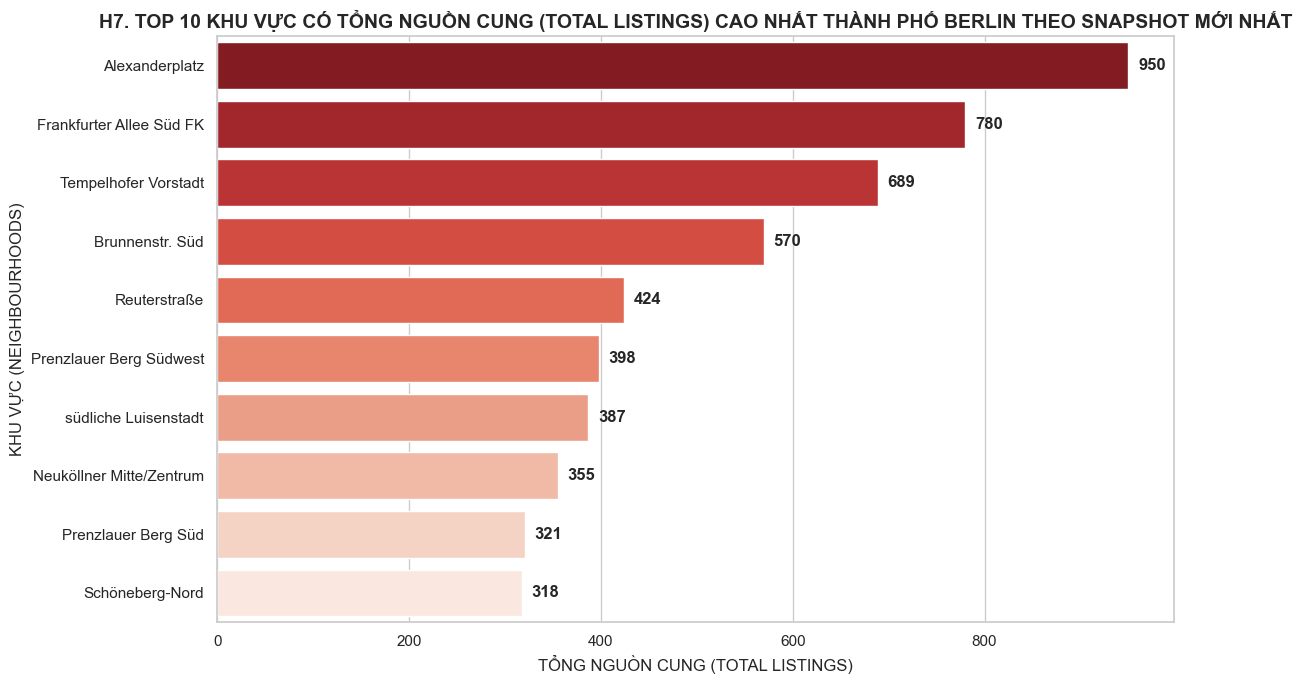

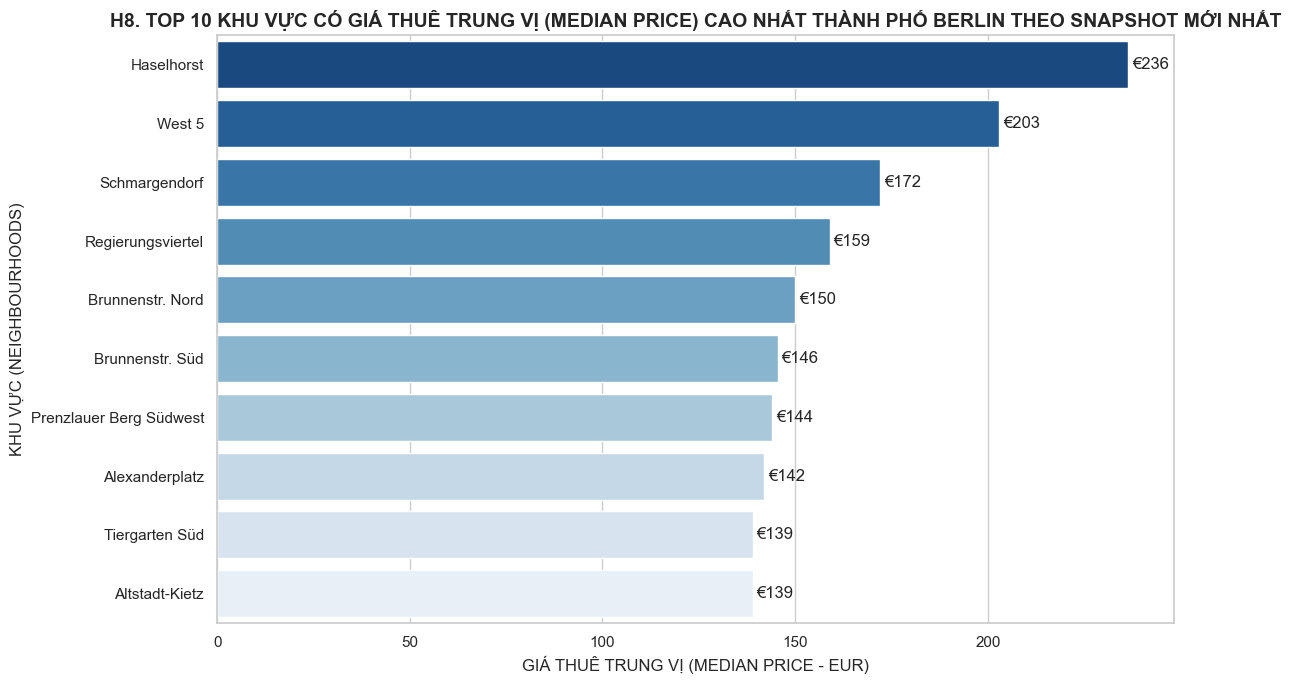

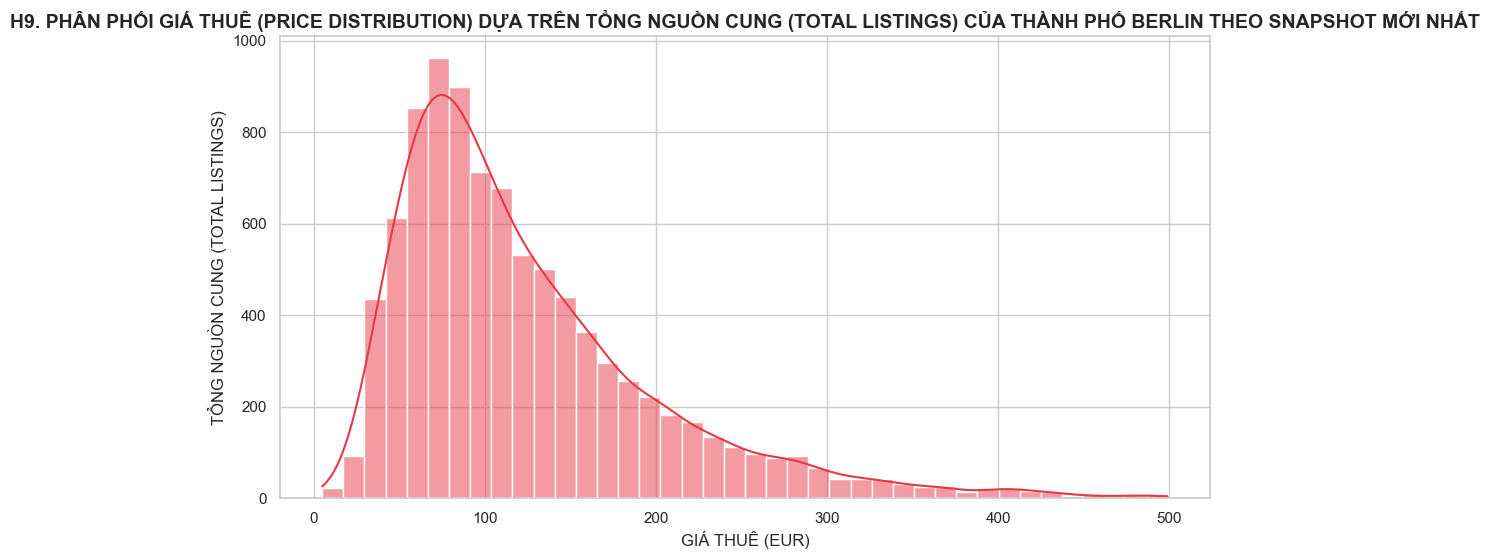

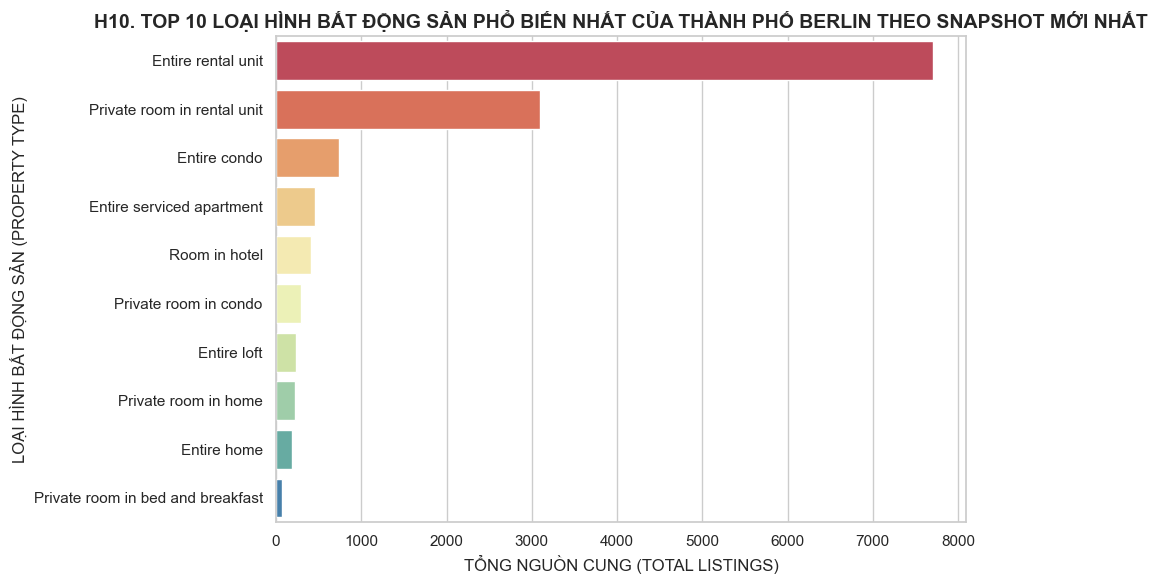

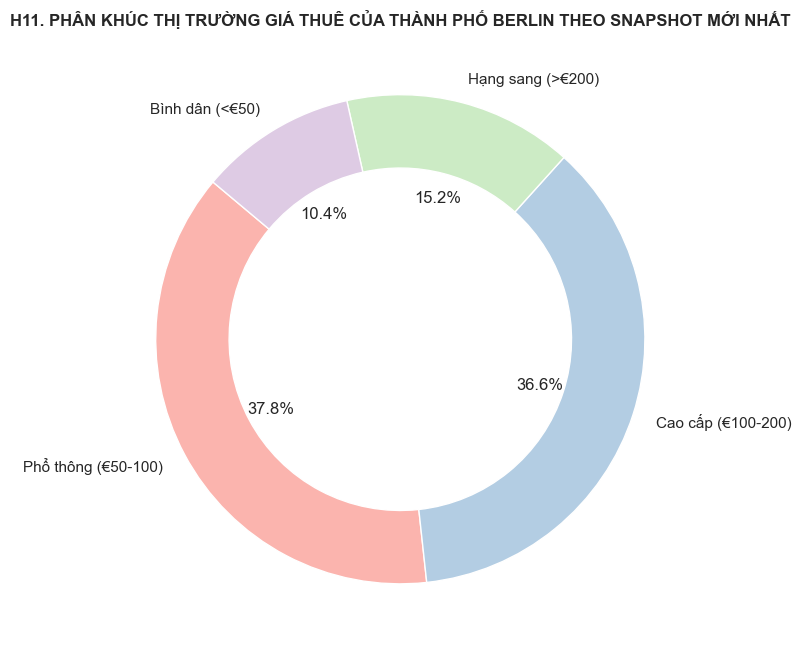

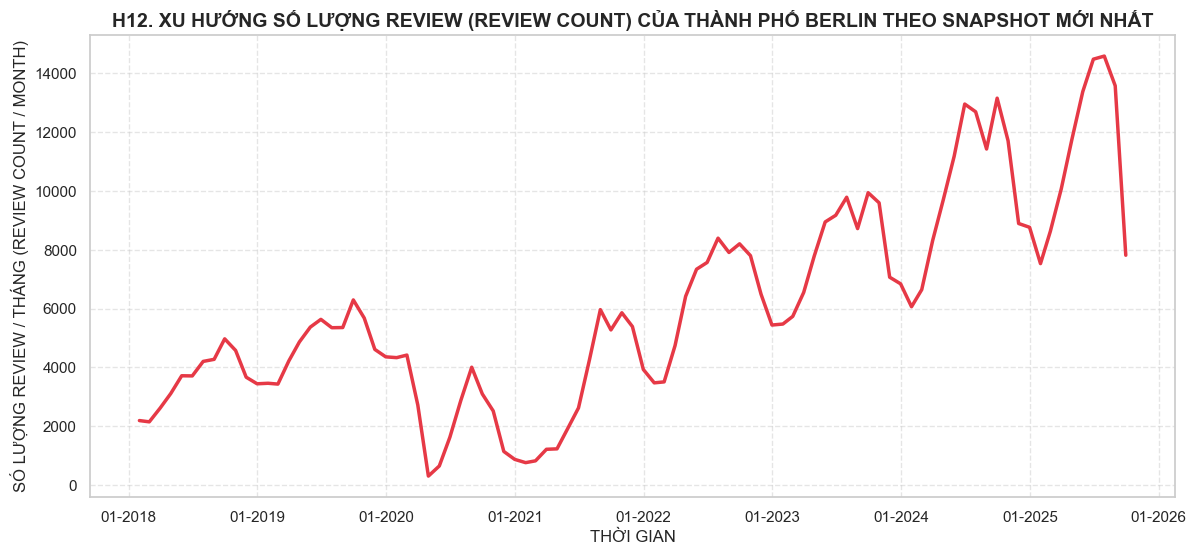

In [6]:
# THÀNH PHỐ BERLIN


import numpy as np
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from datetime import datetime


# LÀM SẠCH & CHUẨN HÓA

# CẤU HÌNH 
BASE_DIR = '..'
RAW_DIR = os.path.join(BASE_DIR, 'raw', 'berlin')
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', 'berlin')
REPORTS_DIR = os.path.join(BASE_DIR, 'reports')

os.makedirs(PROCESSED_DIR, exist_ok = True)
os.makedirs(REPORTS_DIR, exist_ok = True)

# Bounding Box Berlin
CITY_LAT_MIN, CITY_LAT_MAX = 52.30, 52.70
CITY_LON_MIN, CITY_LON_MAX = 13.00, 13.80

# Hàm Clean Price chuẩn
def clean_price(price_value):
    if pd.isna(price_value): return np.nan
    if isinstance(price_value, (int, float)): return float(price_value)
    s = str(price_value).strip()
    match = re.search(r"[-+]?[0-9,.]+", s.replace('$', ''))
    if not match: return np.nan
    num = match.group(0).replace(',', '') 
    try: return float(num)
    except: return np.nan

# QUY TRÌNH XỬ LÝ 
snapshot_folders = [f for f in glob.glob(os.path.join(RAW_DIR, '*')) if os.path.isdir(f)]
qa_summary_list = []

print(f"--- BẮT ĐẦU XỬ LÝ {len(snapshot_folders)} SNAPSHOTS BERLIN ---")

for folder_path in snapshot_folders:
    snapshot_name = os.path.basename(folder_path)
    print(f"\n>> Đang xử lý: {snapshot_name}")

    try:
        listings_df = pd.read_csv(os.path.join(folder_path, 'listings.csv.gz'), low_memory=False)
        calendar_df = pd.read_csv(os.path.join(folder_path, 'calendar.csv.gz'), low_memory=False)
        reviews_df = pd.read_csv(os.path.join(folder_path, 'reviews.csv.gz'), low_memory=False)
        neigh_df = pd.read_csv(os.path.join(folder_path, 'neighbourhoods.csv'))
    except FileNotFoundError:
        print(f"   [!] Thiếu file trong folder {snapshot_name}, bỏ qua.")
        continue

    # ---------------------------------------------------------
    # 1. XỬ LÝ LISTINGS (Cơ bản & Toạ độ)
    # ---------------------------------------------------------
    listings_df['price_numeric'] = listings_df['price'].apply(clean_price)
    
    # [QA1] Flag Price <= 0
    listings_df['qa_flag_price_zero'] = listings_df['price_numeric'].fillna(0) <= 0
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA001_price_zero',
        'records_affected': int(listings_df['qa_flag_price_zero'].sum()),
        'handling_decision': 'Gắn cờ'
    })

    # Datetime & Coords
    listings_df['host_since'] = pd.to_datetime(listings_df['host_since'], errors='coerce')
    listings_df['latitude'] = pd.to_numeric(listings_df['latitude'], errors='coerce')
    listings_df['longitude'] = pd.to_numeric(listings_df['longitude'], errors='coerce')

    # [QA2] Check Coordinates Out of Bounds
    listings_df['qa_flag_out_of_city'] = (
        (listings_df['latitude'] < CITY_LAT_MIN) | (listings_df['latitude'] > CITY_LAT_MAX) |
        (listings_df['longitude'] < CITY_LON_MIN) | (listings_df['longitude'] > CITY_LON_MAX)
    )
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA002_coords_out_of_bounds',
        'records_affected': int(listings_df['qa_flag_out_of_city'].sum()),
        'handling_decision': 'Gắn cờ'
    })

    # [QA3] Duplicate IDs
    dups = listings_df.duplicated(subset=['id']).sum()
    if dups > 0:
        listings_df = listings_df.drop_duplicates(subset=['id'], keep='first')
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA003_duplicate_ids',
        'records_affected': int(dups),
        'handling_decision': 'Xoá dòng trùng'
    })

    # ---------------------------------------------------------
    # 2. XỬ LÝ NEIGHBOURHOOD 
    # ---------------------------------------------------------
    if 'neighbourhood_group' in neigh_df.columns: 
        neigh_df.drop(columns=['neighbourhood_group'], inplace=True)
    
    # Lấy danh sách quận chuẩn
    valid_neighbourhoods = set(neigh_df['neighbourhood'])
    
    # [QA4] Kiểm tra listing có thuộc quận hợp lệ không
    # (Nếu cột trong listings là 'neighbourhood_cleansed')
    col_neigh = 'neighbourhood_cleansed' if 'neighbourhood_cleansed' in listings_df.columns else 'neighbourhood'
    
    listings_df['qa_flag_invalid_neigh'] = ~listings_df[col_neigh].isin(valid_neighbourhoods)
    
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA004_invalid_neighbourhood',
        'records_affected': int(listings_df['qa_flag_invalid_neigh'].sum()),
        'handling_decision': 'Gắn cờ'
    })

    # ---------------------------------------------------------
    # 3. XỬ LÝ REVIEWS 
    # ---------------------------------------------------------
    reviews_df['date'] = pd.to_datetime(reviews_df['date'], errors='coerce')
    
    # Xóa các review không có nội dung (NaN comments)
    initial_reviews = len(reviews_df)
    reviews_df = reviews_df.dropna(subset=['comments'])
    
    # [QA5] Lọc bỏ Review của Listing không tồn tại (Orphaned Reviews)
    # Chỉ giữ lại review mà listing_id của nó có trong danh sách listings_df đã lọc
    valid_ids = set(listings_df['id'])
    reviews_df = reviews_df[reviews_df['listing_id'].isin(valid_ids)]
    
    removed_reviews = initial_reviews - len(reviews_df)
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA005_orphaned_or_empty_reviews',
        'records_affected': int(removed_reviews),
        'handling_decision': 'Xoá bỏ'
    })

    # ---------------------------------------------------------
    # 4. XỬ LÝ CALENDAR
    # ---------------------------------------------------------
    calendar_df['date'] = pd.to_datetime(calendar_df['date'], errors='coerce')
    calendar_df['price_numeric'] = calendar_df['price'].apply(clean_price)
    if 'adjusted_price' in calendar_df.columns: calendar_df.drop(columns=['adjusted_price'], inplace=True)
    
    # Chỉ giữ lại calendar của các listing hợp lệ (giảm dung lượng file)
    calendar_df = calendar_df[calendar_df['listing_id'].isin(valid_ids)]

    # ---------------------------------------------------------
    # 5. LƯU FILE
    # ---------------------------------------------------------
    out_dir = os.path.join(PROCESSED_DIR, snapshot_name)
    os.makedirs(out_dir, exist_ok=True)
    
    listings_df.to_csv(os.path.join(out_dir, 'listings_processed.csv'), index=False)
    calendar_df.to_csv(os.path.join(out_dir, 'calendar_processed.csv'), index=False)
    reviews_df.to_csv(os.path.join(out_dir, 'reviews_processed.csv'), index=False)
    neigh_df.to_csv(os.path.join(out_dir, 'neighbourhoods_processed.csv'), index=False)
    
    print(f"   -> Đã lưu xong: {out_dir}")

# Lưu báo cáo QA
pd.DataFrame(qa_summary_list).to_csv(os.path.join(REPORTS_DIR, 'qa_summary_berlin.csv'), index=False)
print("\n--- HOÀN TẤT ---")




# TỔNG HỢP & KPI

# CẤU HÌNH
pd.set_option('display.float_format', lambda x: '%.2f' % x)

BASE_DIR = '..'
CITY_FOLDER = 'berlin'  
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', CITY_FOLDER)
KPI_OUTPUT_DIR = os.path.join(BASE_DIR, 'processed', CITY_FOLDER) 

print(f"--- BẮT ĐẦU TÍNH TOÁN KPI FULL CHO: {CITY_FOLDER.upper()} ---")

# HÀM TÍNH TOÁN KPI CHO TỪNG SNAPSHOT
def calculate_snapshot_kpi(snapshot_path):
    snapshot_name = os.path.basename(snapshot_path)
    print(f"\n>> Đang xử lý snapshot: {snapshot_name}")
    
   
    try:
        df_list = pd.read_csv(os.path.join(snapshot_path, 'listings_processed.csv'), low_memory=False)
        df_cal = pd.read_csv(os.path.join(snapshot_path, 'calendar_processed.csv'), low_memory=False)
        
        try:
            df_rev = pd.read_csv(os.path.join(snapshot_path, 'reviews_processed.csv'), low_memory=False)
            df_rev['date'] = pd.to_datetime(df_rev['date'])
        except FileNotFoundError:
            df_rev = pd.DataFrame(columns=['listing_id', 'date']) 
            
    except FileNotFoundError:
        print("   [!] Không tìm thấy file listing/calendar. Bỏ qua.")
        return None, None, None, None, None

    # --- Lọc dữ liệu sạch (QA Filter) ---
    # Chỉ lấy listing không bị flag lỗi giá hoặc lỗi toạ độ
    # (Nếu cột qa_flag không tồn tại thì coi như hợp lệ)
    if 'qa_flag_price_zero' in df_list.columns:
        df_list = df_list[df_list['qa_flag_price_zero'] == False]
    if 'qa_flag_out_of_city' in df_list.columns:
        df_list = df_list[df_list['qa_flag_out_of_city'] == False]
        
    valid_listings = df_list.copy()
    valid_ids = valid_listings['id'].unique()
    
    # Lọc calendar chỉ chứa các listing hợp lệ
    valid_cal = df_cal[df_cal['listing_id'].isin(valid_ids)].copy()

    # ==============================================================================
    # PHẦN 1: KPI TỔNG HỢP & ROOM TYPE
    # ==============================================================================
    total_supply = len(valid_listings)
    
    # Multi-hosts
    host_counts = valid_listings['host_id'].value_counts()
    multi_host_rate = (host_counts[host_counts > 1].sum() / total_supply) * 100 if total_supply > 0 else 0

    # Median Price & Avail
    median_price = valid_listings['price_numeric'].median()
    median_avail_90 = valid_listings['availability_90'].median()
    
    # Room Type Stats
    room_stats = valid_listings['room_type'].value_counts(normalize=True).reset_index()
    room_stats.columns = ['room_type', 'percentage']
    room_stats['percentage'] = room_stats['percentage'] * 100
    room_stats['snapshot_date'] = snapshot_name

    # Summary Row
    summary_row = {
        'snapshot_date': snapshot_name,
        'total_listings': total_supply,
        'multi_host_rate': multi_host_rate,
        'median_price': median_price,
        'median_avail_90': median_avail_90
    }

    # ==============================================================================
    # PHẦN 2: SEASONALITY (CALENDAR)
    # ==============================================================================
    valid_cal['date'] = pd.to_datetime(valid_cal['date'])
    valid_cal['is_booked'] = valid_cal['available'].apply(lambda x: 1 if x == 'f' else 0)
    
    daily_occupancy = valid_cal.groupby('date')['is_booked'].mean().reset_index()
    daily_occupancy.columns = ['date', 'occupancy_rate']
    daily_occupancy['snapshot_date'] = snapshot_name

    # ==============================================================================
    # PHẦN 3: NEIGHBOURHOOD 
    # ==============================================================================
    # Dùng cột neighbourhood_cleansed hoặc neighbourhood
    col_neigh = 'neighbourhood_cleansed' if 'neighbourhood_cleansed' in valid_listings.columns else 'neighbourhood'
    
    neigh_stats = valid_listings.groupby(col_neigh).agg({
        'id': 'count',
        'price_numeric': 'median'
    }).reset_index()
    neigh_stats.columns = ['neighbourhood', 'listing_count', 'median_price']
    neigh_stats['snapshot_date'] = snapshot_name

    # ==============================================================================
    # PHẦN 4: REVIEW TRENDS 
    # ==============================================================================
    # Resample theo tháng
    if not df_rev.empty:
        review_trends = df_rev.set_index('date').resample('M').size().reset_index(name='review_count')
        review_trends['snapshot_date'] = snapshot_name
        # Chỉ lấy dữ liệu review của 2 năm gần nhất so với snapshot để giảm nhiễu
        # (Tuỳ chọn: Nếu muốn lấy hết thì bỏ dòng lọc này)
    else:
        review_trends = pd.DataFrame()

    return summary_row, room_stats, daily_occupancy, neigh_stats, review_trends

# CHẠY VÒNG LẶP & TỔNG HỢP
all_snapshots = glob.glob(os.path.join(PROCESSED_DIR, '*'))
summary_list = []
room_stats_list = []
occupancy_list = []
neigh_stats_list = []
review_stats_list = []

for folder in all_snapshots:
    if os.path.isdir(folder):
        res_sum, res_room, res_occ, res_neigh, res_rev = calculate_snapshot_kpi(folder)
        if res_sum:
            summary_list.append(res_sum)
            room_stats_list.append(res_room)
            occupancy_list.append(res_occ)
            neigh_stats_list.append(res_neigh)
            if not res_rev.empty: review_stats_list.append(res_rev)

# GỘP & LƯU FILE
if summary_list:
    # 4.1 Summary General
    df_summary = pd.DataFrame(summary_list).sort_values('snapshot_date')
    df_summary.to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_summary_general_{CITY_FOLDER}.csv'), index=False)
    
    # 4.2 Room Type
    if room_stats_list:
        pd.concat(room_stats_list).to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_room_type_{CITY_FOLDER}.csv'), index=False)
    
    # 4.3 Seasonality
    if occupancy_list:
        pd.concat(occupancy_list).to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_seasonality_{CITY_FOLDER}.csv'), index=False)

    # 4.4 Neighbourhood 
    if neigh_stats_list:
        pd.concat(neigh_stats_list).to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_neighbourhood_{CITY_FOLDER}.csv'), index=False)

    # 4.5 Review Trends 
    if review_stats_list:
        # Gom nhóm lại lần nữa nếu có nhiều snapshot (để tránh trùng lặp nếu vẽ biểu đồ tổng)
        # Thường ta chỉ lấy trend từ snapshot mới nhất, hoặc gộp tất cả. 
        # Ở đây mình gộp tất cả để bạn dễ xử lý.
        pd.concat(review_stats_list).to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_reviews_trend_{CITY_FOLDER}.csv'), index=False)

    print("\n✅ ĐÃ HOÀN TẤT! Đã tạo ra 5 file KPI:")
    print(f"   1. kpi_summary_general_{CITY_FOLDER}.csv")
    print(f"   2. kpi_room_type_{CITY_FOLDER}.csv")
    print(f"   3. kpi_seasonality_{CITY_FOLDER}.csv")
    print(f"   4. kpi_neighbourhood_{CITY_FOLDER}.csv")
    print(f"   5. kpi_reviews_trend_{CITY_FOLDER}.csv")

else:
    print("Không có dữ liệu để tính toán.")






# TRỰC QUAN HÓA 

# THIẾT LẬP 
sns.set_theme(style="whitegrid")
BASE_DIR = '..'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', 'berlin')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)
CITY_SUFFIX = 'berlin'

print("--- BẮT ĐẦU VẼ CHUYÊN SÂU CHO BERLIN ---")

# NẠP DỮ LIỆU KPI 
try:
    kpi_supply = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_summary_general_{CITY_SUFFIX}.csv'))
    kpi_room = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_room_type_{CITY_SUFFIX}.csv'))
    kpi_season = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_seasonality_{CITY_SUFFIX}.csv'))
    kpi_neigh = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_neighbourhood_{CITY_SUFFIX}.csv'))
    kpi_review = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_reviews_trend_{CITY_SUFFIX}.csv'))
    
    # Sắp xếp thời gian
    kpi_supply['dt'] = pd.to_datetime(kpi_supply['snapshot_date'], errors='coerce')
    kpi_supply = kpi_supply.sort_values('dt')
    print("--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---")
except FileNotFoundError as e:
    print(f"⚠️ Thiếu file KPI: {e}")
    kpi_supply = pd.DataFrame(); kpi_room = pd.DataFrame(); kpi_season = pd.DataFrame()
    kpi_neigh = pd.DataFrame(); kpi_review = pd.DataFrame()


# NẠP DỮ LIỆU CHI TIẾT 
def parse_snapshot_name(name):
    try:
        return datetime.strptime(name.strip(), "%d %B, %Y")
    except:
        return None

df_detail = pd.DataFrame()
LATEST_SNAPSHOT = "Unknown"

if os.path.exists(PROCESSED_DIR):
    raw_snaps = [
        d for d in os.listdir(PROCESSED_DIR)
        if os.path.isdir(os.path.join(PROCESSED_DIR, d))
    ]

    snapshots = [s for s in raw_snaps if parse_snapshot_name(s) is not None]
    snapshots = sorted(snapshots, key=lambda x: parse_snapshot_name(x), reverse=True)

    for snap in snapshots:
        file_path = os.path.join(PROCESSED_DIR, snap, 'listings_processed.csv')
        if os.path.exists(file_path):
            try:
                temp = pd.read_csv(file_path, low_memory=False)
                if not temp.empty and 'price_numeric' in temp.columns:
                    df_detail = temp
                    LATEST_SNAPSHOT = snap
                    break
            except: continue


# VẼ BIỂU ĐỒ 

# === H1: Xu hướng Nguồn Cung ===
if not kpi_supply.empty:
    plt.figure(figsize=(10, 6))
    ax1 = sns.barplot(data=kpi_supply, x='snapshot_date', y='total_listings', color='#E63946', width=0.5)
    plt.title('H1. XU HƯỚNG TỔNG NGUỒN CUNG (TOTAL LISTINGS) CỦA THÀNH PHỐ BERLIN THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i in ax1.containers: ax1.bar_label(i, padding=3, fontsize=11, fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_01_supply.pdf'), format='pdf', bbox_inches='tight')
    plt.show()

# === H2: Xu hướng Giá ===
if not kpi_supply.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(kpi_supply['snapshot_date'], kpi_supply['median_price'], marker='o', linewidth=3, color='#E63946')
    plt.fill_between(kpi_supply['snapshot_date'], kpi_supply['median_price'], color='#E63946', alpha=0.1)
    plt.title('H2. XU HƯỚNG GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CỦA THÀNH PHỐ BERLIN THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.ylabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for x, y in zip(kpi_supply['snapshot_date'], kpi_supply['median_price']):
        plt.text(x, y + 2, f"€{y:.0f}", ha='center', fontsize=11, fontweight='bold')
    plt.ylim(bottom=0, top=kpi_supply['median_price'].max()*1.2)
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_02_price.pdf'), format='pdf', bbox_inches='tight')
    plt.show()


# === H3: Multi-Host Rate (Chủ nhà chuyên nghiệp) ===
if not kpi_supply.empty and 'multi_host_rate' in kpi_supply.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(kpi_supply['snapshot_date'], kpi_supply['multi_host_rate'], marker='s', linewidth=3, color='#E63946')
    plt.title(f'H3. TỶ LỆ CHỦ NHÀ CHUYÊN NGHIỆP (MULTI-HOST RATE) CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO THỜI GIAN',fontsize = 14, fontweight='bold')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.ylabel('TỶ LỆ (%)')
    plt.ylim(0, 100)
    for x, y in zip(kpi_supply['snapshot_date'], kpi_supply['multi_host_rate']):
        plt.text(x, y + 2, f"{y:.1f}%", ha='center', fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_03_multi_host.pdf'), bbox_inches='tight')
    plt.show()

# === H4: Độ sẵn sàng (Availability) ===
if not kpi_supply.empty and 'median_avail_90' in kpi_supply.columns:
    plt.figure(figsize=(10, 6))
    ax12 = sns.barplot(data=kpi_supply, x='snapshot_date', y='median_avail_90', color='#E63946', width=0.5)
    plt.title(f'H4. XU HƯỚNG ĐỘ SẴN SÀNG TRUNG VỊ (MEDIAN AVAILABILITY 90) CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO THỜI GIAN',fontsize = 14, fontweight='bold')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.ylabel('SỐ NGÀY TRỐNG (TRONG 90 NGÀY TỚI)')
    for i in ax12.containers: ax12.bar_label(i, padding=3, fontsize=11, fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_04_availability.pdf'), format = 'pdf', bbox_inches='tight')
    plt.show()

# === H5: Occupancy ===
if not kpi_season.empty:
    df_h5 = kpi_season.copy()
    df_h5['date_dt'] = pd.to_datetime(df_h5['date'], errors='coerce')
    df_h5['snapshot_dt'] = pd.to_datetime(df_h5['snapshot_date'], errors='coerce')

    latest_snap_dt = df_h5['snapshot_dt'].max()
    df_final_h5 = df_h5[df_h5['snapshot_dt'] == latest_snap_dt].sort_values('date_dt')

    if not df_final_h5.empty:
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=df_final_h5, x='date_dt', y='occupancy_rate', color='#E63946', linewidth=2)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.title('H5. XU HƯỚNG TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE) CỦA THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
        plt.xlabel('THỜI GIAN')
        plt.ylabel('TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE)')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.ylim(0, 1.05)
        plt.savefig(os.path.join(FIGURES_DIR, 'berlin_05_occupancy.pdf'), format='pdf', bbox_inches='tight')
        plt.show()


# === H6: Cơ cấu Loại phòng (Grouped Bar) ===
if not kpi_room.empty:
    plt.figure(figsize=(12, 6))
    kpi_room['dt'] = pd.to_datetime(kpi_room['snapshot_date'], errors='coerce')
    kpi_room = kpi_room.sort_values('dt')
    
    ax3 = sns.barplot(data=kpi_room, x='snapshot_date', y='percentage', hue='room_type', palette='Set2')
    plt.title('H6. CƠ CẤU LOẠI PHÒNG (ROOM TYPE) CỦA THÀNH PHỐ BERLIN THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.legend(title='LOẠI PHÒNG (ROOM TYPE)', bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i in ax3.containers: ax3.bar_label(i, fmt='%.1f%%', padding=3, fontsize=9)
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_06_room_type.pdf'), format='pdf', bbox_inches='tight')
    plt.show()




    
# === H7: Top 10 khu vực nhiều listing nhất ===
if not df_detail.empty:
    top_supply = df_detail['neighbourhood_cleansed'].value_counts().head(10).reset_index()
    top_supply.columns = ['neighbourhood_cleansed', 'count']

    plt.figure(figsize=(12, 7))
    sns.barplot(data=top_supply, y='neighbourhood_cleansed', x='count', 
                hue='neighbourhood_cleansed', palette='Reds_r', legend=False)
    
    plt.title('H7. TOP 10 KHU VỰC CÓ TỔNG NGUỒN CUNG (TOTAL LISTINGS) CAO NHẤT THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', 
              fontsize=14, fontweight='bold')
    
    plt.xlabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.ylabel('KHU VỰC (NEIGHBOURHOODS)')
    
    for i, v in enumerate(top_supply['count']):
        plt.text(v + 10, i, f"{v}", va='center', fontweight='bold')
        
    plt.tight_layout()
    
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_07_top10_supply.pdf'), bbox_inches='tight')
    
    plt.show()


# === H8: Top 10 khu vực đắt nhất ===
if not df_detail.empty:
    neigh_price = df_detail.groupby('neighbourhood_cleansed')['price_numeric'].median().sort_values(ascending=False).head(10).reset_index()

    plt.figure(figsize=(12, 7))
    sns.barplot(data=neigh_price, y='neighbourhood_cleansed', x='price_numeric', 
                hue='neighbourhood_cleansed', palette='Blues_r', legend=False)
    
    
    plt.title('H8. TOP 10 KHU VỰC CÓ GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CAO NHẤT THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', 
              fontsize=14, fontweight='bold')
    
    for i, v in enumerate(neigh_price['price_numeric']):
        plt.text(v + 1, i, f"€{v:.0f}", va='center')
        
    plt.xlabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.ylabel('KHU VỰC (NEIGHBOURHOODS)')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_08_top10_price.pdf'), bbox_inches='tight')
    
    plt.show()


# === H9: Histogram giá ===
if not df_detail.empty:
    plt.figure(figsize=(12, 6))
    sns.histplot(df_detail[df_detail['price_numeric'] < 500]['price_numeric'], kde=True, bins=40, color='#E63946')
    plt.title('H9. PHÂN PHỐI GIÁ THUÊ (PRICE DISTRIBUTION) DỰA TRÊN TỔNG NGUỒN CUNG (TOTAL LISTINGS) CỦA THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('GIÁ THUÊ (EUR)')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_09_price_distribution.pdf'), format='pdf', bbox_inches='tight')
    plt.show()






# === H10: Top 10 Loại hình Bất động sản  ===
if not df_detail.empty and 'property_type' in df_detail.columns:
    top_props = df_detail['property_type'].value_counts().head(10)
    
    plt.figure(figsize=(10, 6))
    
    sns.barplot(y=top_props.index, x=top_props.values, 
                hue=top_props.index, palette='Spectral', legend=False)
    
   
    plt.title('H10. TOP 10 LOẠI HÌNH BẤT ĐỘNG SẢN PHỔ BIẾN NHẤT CỦA THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', 
              fontsize=14, fontweight='bold')
    
    plt.xlabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.ylabel('LOẠI HÌNH BẤT ĐỘNG SẢN (PROPERTY TYPE)')
    
    plt.tight_layout() 
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_10_property_type.pdf'), bbox_inches='tight')
    
    plt.show()



# === H11: Phân khúc Giá (Donut Chart) ===
if not df_detail.empty:
    plt.figure(figsize=(8, 8))
    bins = [0, 50, 100, 200, 10000]
    labels = ['Bình dân (<€50)', 'Phổ thông (€50-100)', 'Cao cấp (€100-200)', 'Hạng sang (>€200)']
    df_detail['price_segment'] = pd.cut(df_detail['price_numeric'], bins=bins, labels=labels)
    seg_counts = df_detail['price_segment'].value_counts()
    
    plt.pie(seg_counts, labels=seg_counts.index, autopct='%1.1f%%', startangle=140, 
            colors=sns.color_palette('Pastel1'), wedgeprops=dict(width=0.3))
    plt.title('H11. PHÂN KHÚC THỊ TRƯỜNG GIÁ THUÊ CỦA THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_11_price_segments.pdf'))
    plt.show()


# === H12: XU HƯỚNG LƯỢNG REVIEW (NHU CẦU DU LỊCH) ===
if not kpi_review.empty:
    plt.figure(figsize=(14, 6))
    
    # 1. Tìm snapshot mới nhất (Logic chuẩn xác nhất)
    kpi_review['snap_dt'] = pd.to_datetime(kpi_review['snapshot_date'], errors='coerce')
    latest_snap_date = kpi_review['snap_dt'].max()
    
    # 2. Chỉ lọc lấy dữ liệu review của snapshot đó
    df_rev_final = kpi_review[kpi_review['snap_dt'] == latest_snap_date].copy()
    
    # 3. Xử lý ngày tháng
    df_rev_final['date'] = pd.to_datetime(df_rev_final['date'])
    df_rev_final = df_rev_final.sort_values('date')
    
    # 4. Lọc năm (2018 trở lại)
    df_rev_final = df_rev_final[df_rev_final['date'].dt.year >= 2018]

    # 5. Vẽ
    sns.lineplot(data=df_rev_final, x='date', y='review_count', color='#E63946', linewidth=2.5)
    
    plt.title(f'H12. XU HƯỚNG SỐ LƯỢNG REVIEW (REVIEW COUNT) CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.ylabel('SỐ LƯỢNG REVIEW / THÁNG (REVIEW COUNT / MONTH)')
    plt.xlabel('THỜI GIAN')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_12_reviews_trend.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Không có dữ liệu Review Trend để vẽ H12.")




--- BẮT ĐẦU XỬ LÝ 4 SNAPSHOTS PARIS ---

>> Đang xử lý: 03 March, 2025
   -> Đã lưu xong: ..\processed\paris\03 March, 2025

>> Đang xử lý: 06 December, 2024
   -> Đã lưu xong: ..\processed\paris\06 December, 2024

>> Đang xử lý: 06 June, 2025
   -> Đã lưu xong: ..\processed\paris\06 June, 2025

>> Đang xử lý: 12 September, 2025
   -> Đã lưu xong: ..\processed\paris\12 September, 2025

--- HOÀN TẤT ---
--- BẮT ĐẦU TÍNH TOÁN KPI FULL CHO: PARIS ---

>> Đang xử lý snapshot: 03 March, 2025


C:\Users\Admin\AppData\Local\Temp\ipykernel_20076\1214216138.py:297: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  review_trends = df_rev.set_index('date').resample('M').size().reset_index(name='review_count')



>> Đang xử lý snapshot: 06 December, 2024


C:\Users\Admin\AppData\Local\Temp\ipykernel_20076\1214216138.py:297: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  review_trends = df_rev.set_index('date').resample('M').size().reset_index(name='review_count')



>> Đang xử lý snapshot: 06 June, 2025


C:\Users\Admin\AppData\Local\Temp\ipykernel_20076\1214216138.py:297: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  review_trends = df_rev.set_index('date').resample('M').size().reset_index(name='review_count')



>> Đang xử lý snapshot: 12 September, 2025


C:\Users\Admin\AppData\Local\Temp\ipykernel_20076\1214216138.py:297: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  review_trends = df_rev.set_index('date').resample('M').size().reset_index(name='review_count')
C:\Users\Admin\AppData\Local\Temp\ipykernel_20076\1214216138.py:336: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(occupancy_list).to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_seasonality_{CITY_FOLDER}.csv'), index=False)



✅ ĐÃ HOÀN TẤT! Đã tạo ra 5 file KPI:
   1. kpi_summary_general_paris.csv
   2. kpi_room_type_paris.csv
   3. kpi_seasonality_paris.csv
   4. kpi_neighbourhood_paris.csv
   5. kpi_reviews_trend_paris.csv
--- BẮT ĐẦU VẼ CHUYÊN SÂU CHO PARIS ---
--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---


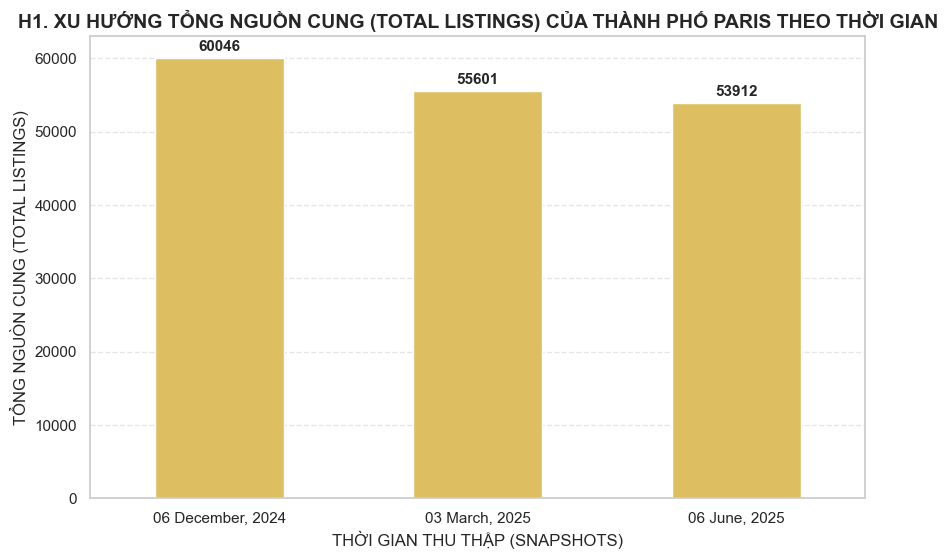

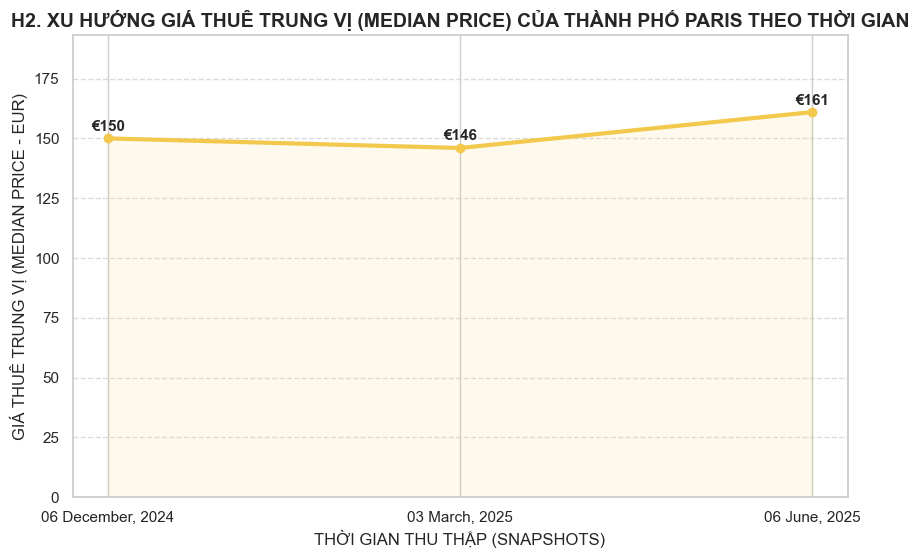

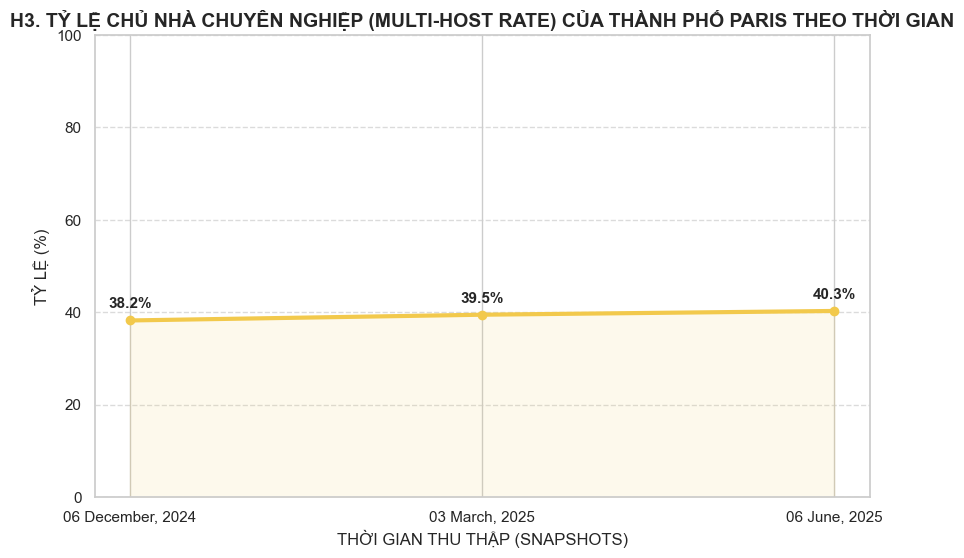

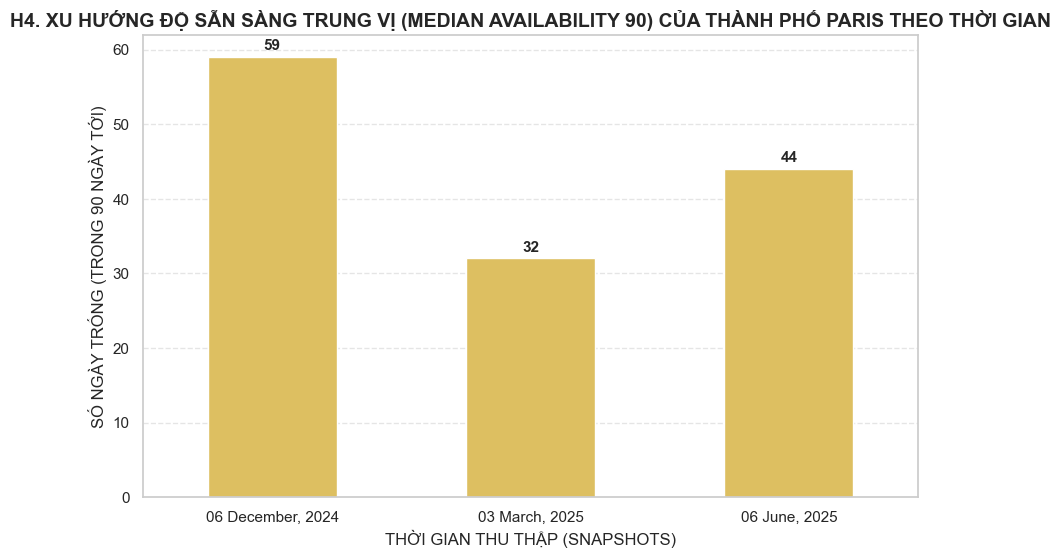

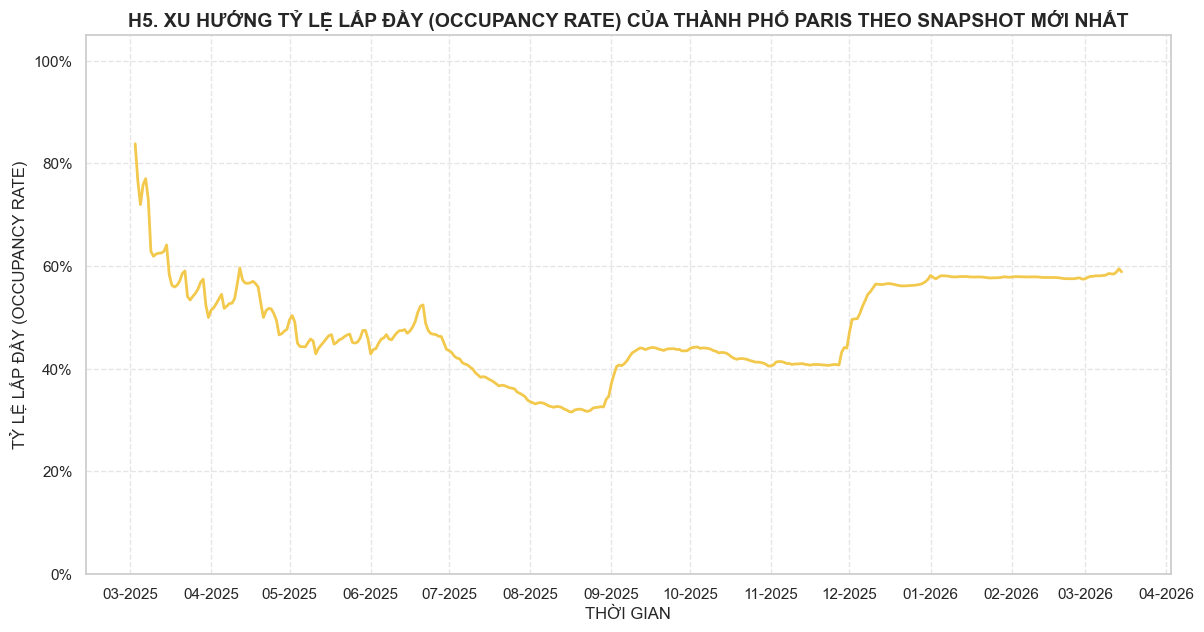

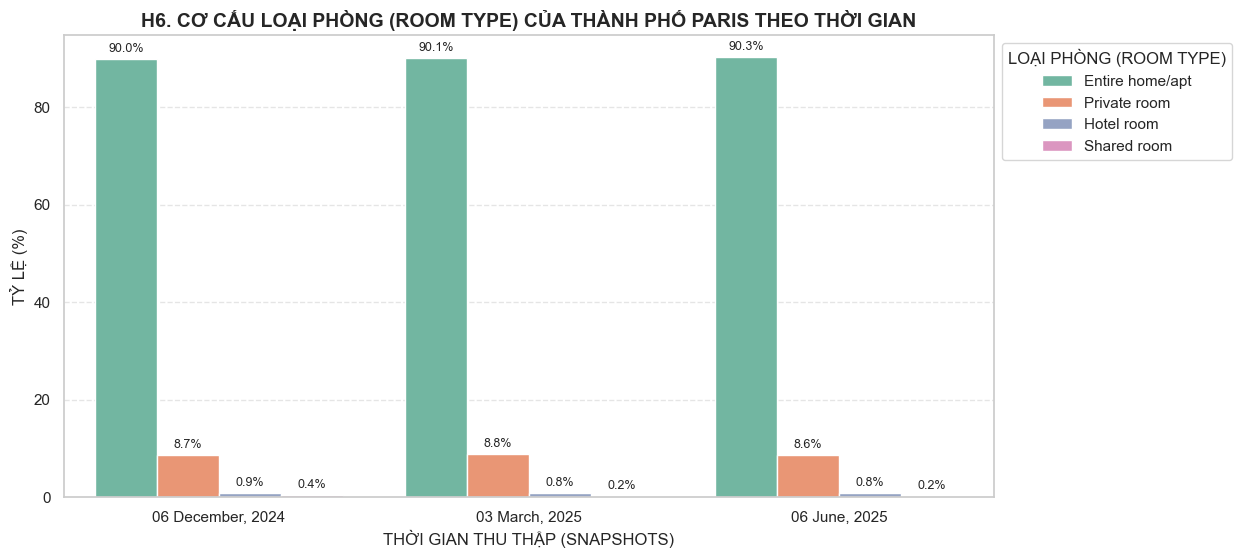

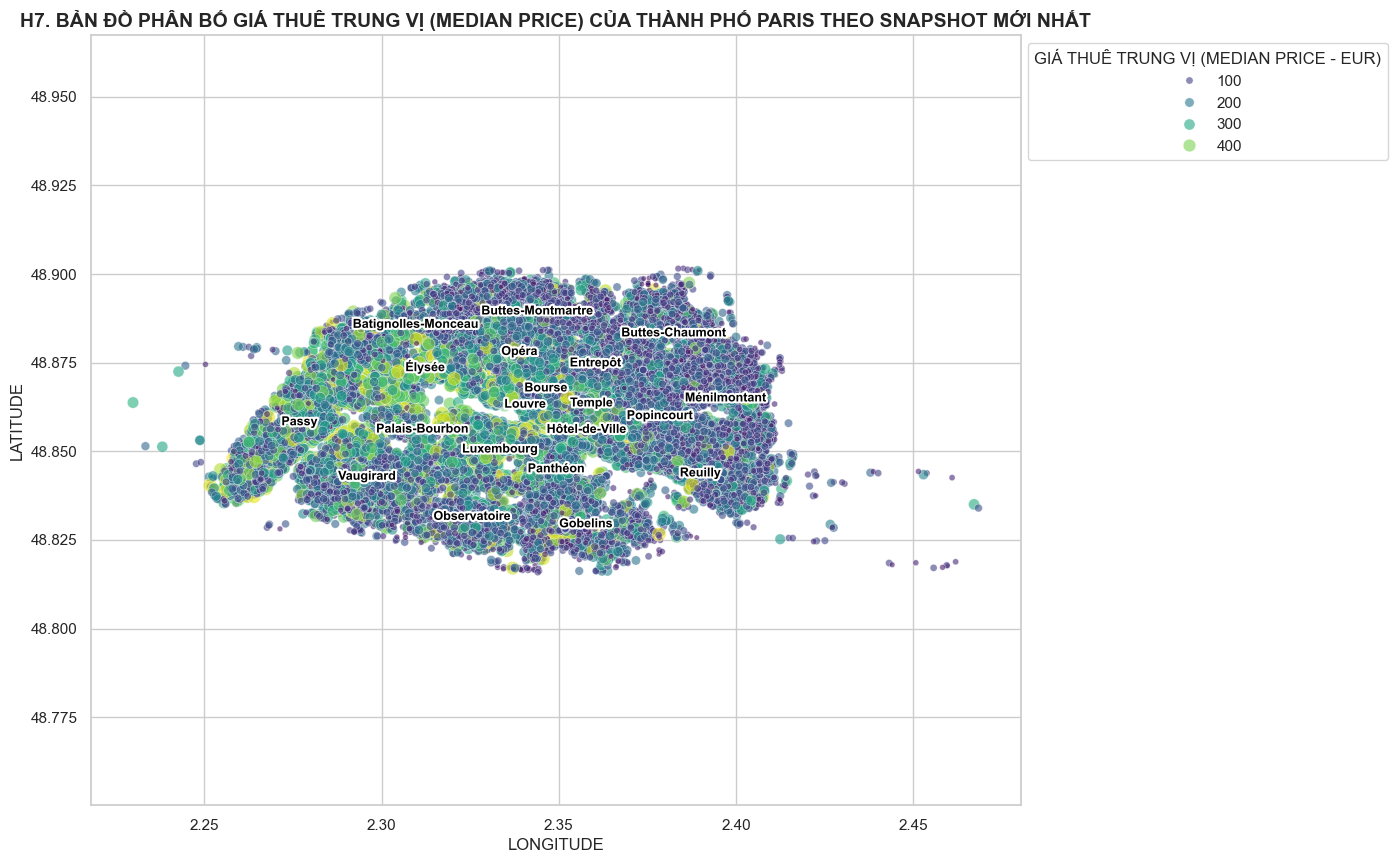

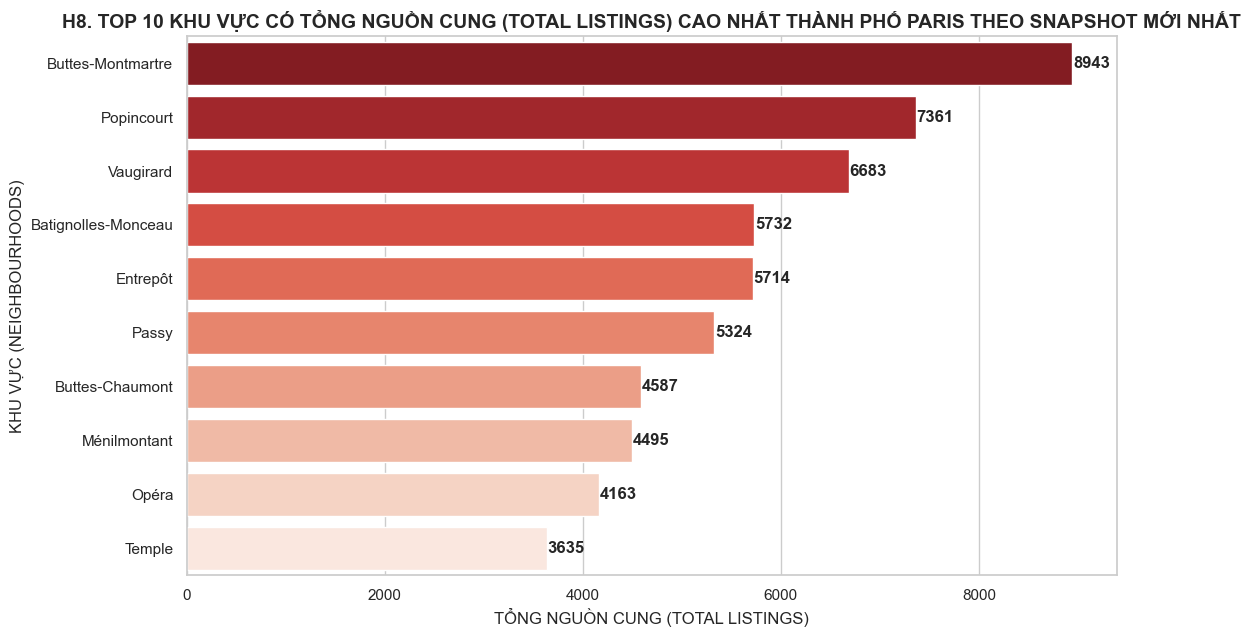

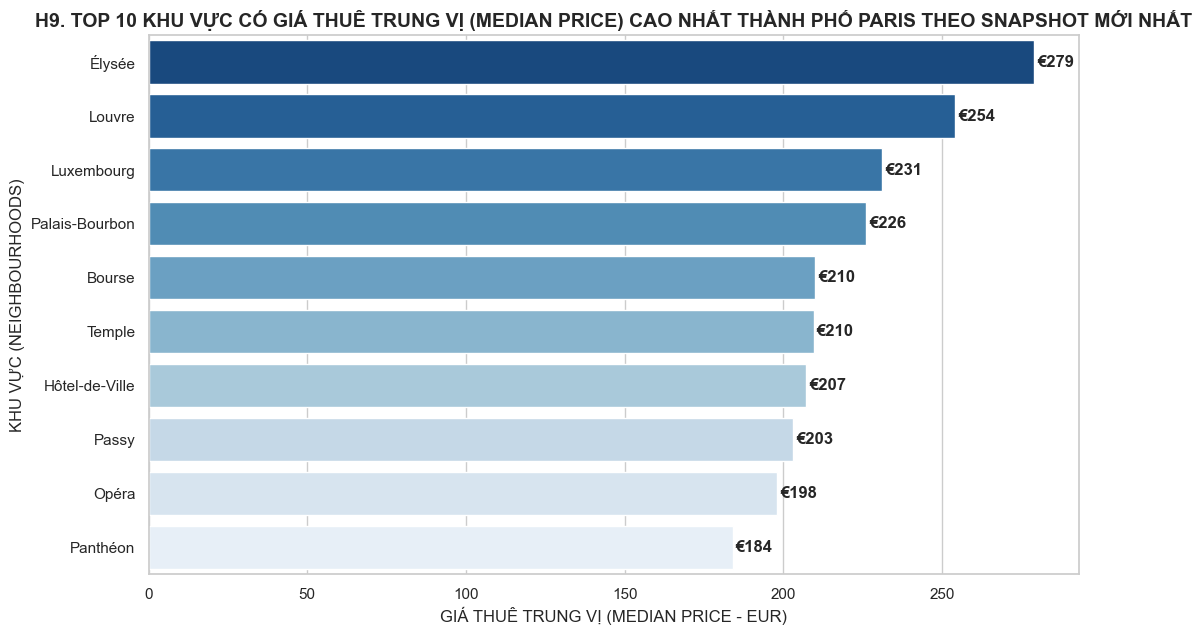

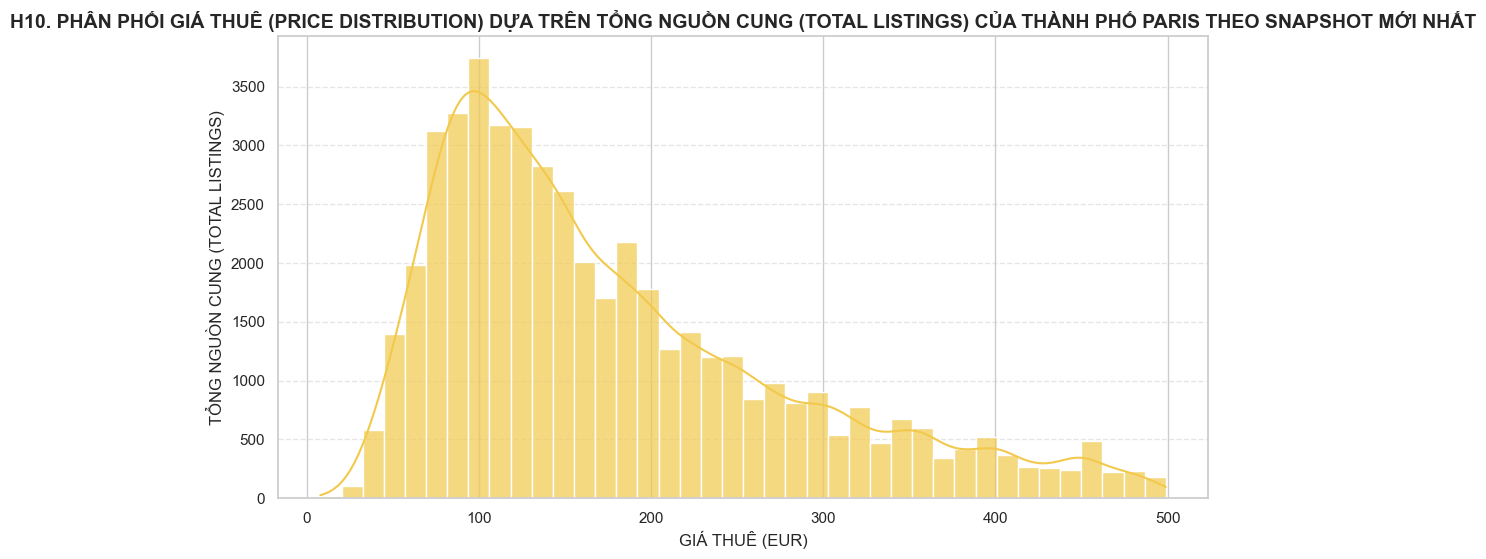

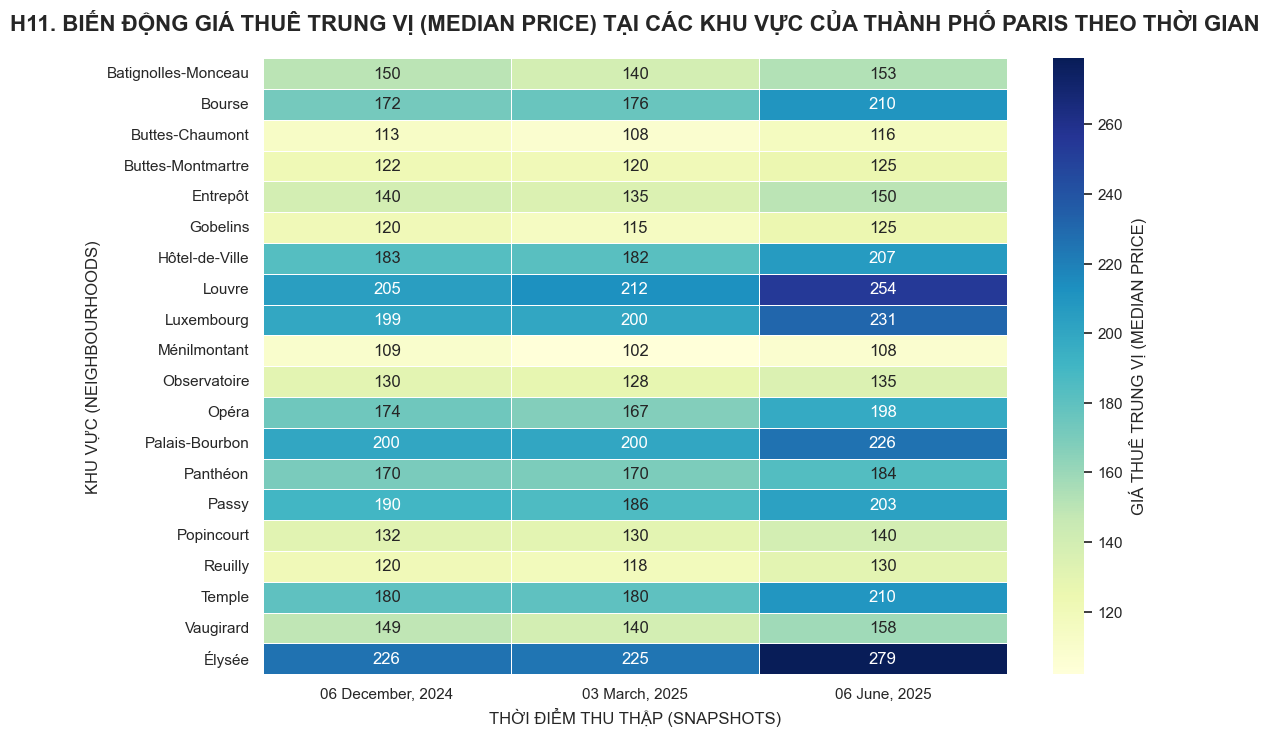

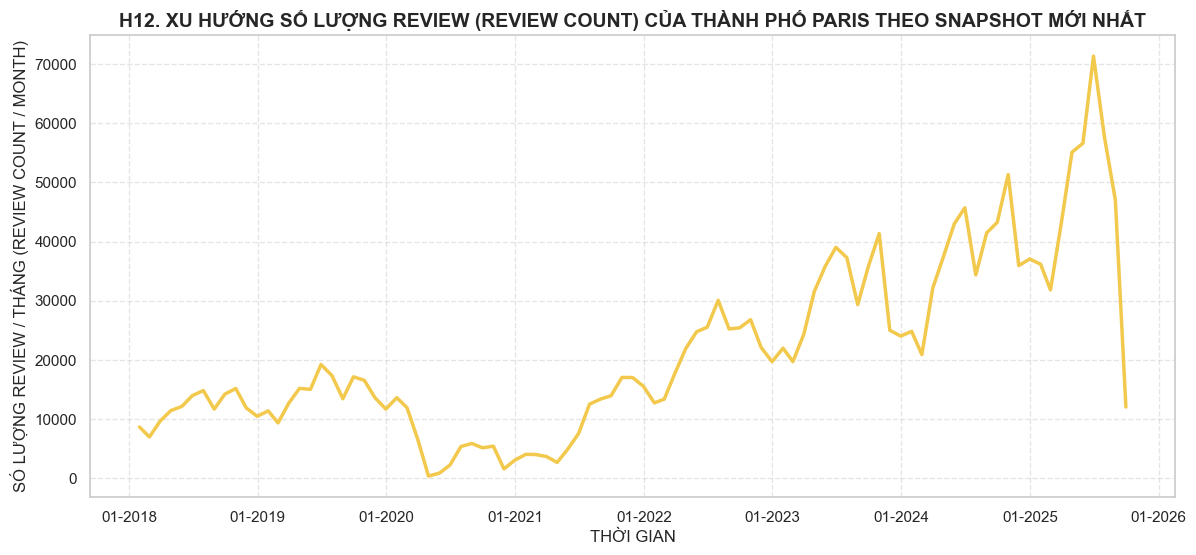

In [7]:
# THÀNH PHỐ PARIS

import numpy as np
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from datetime import datetime

# LÀM SẠCH VÀ CHUẨN HÓA 


# CẤU HÌNH 
BASE_DIR = '..'
RAW_DIR = os.path.join(BASE_DIR, 'raw', 'paris')
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', 'paris')
REPORTS_DIR = os.path.join(BASE_DIR, 'reports')

os.makedirs(PROCESSED_DIR, exist_ok = True)
os.makedirs(REPORTS_DIR, exist_ok = True)

# Bounding Box Paris
CITY_LAT_MIN, CITY_LAT_MAX = 48.80, 48.92
CITY_LON_MIN, CITY_LON_MAX = 2.25, 2.42

# Hàm Clean Price chuẩn
def clean_price(price_value):
    if pd.isna(price_value): return np.nan
    if isinstance(price_value, (int, float)): return float(price_value)
    s = str(price_value).strip()
    match = re.search(r"[-+]?[0-9,.]+", s.replace('$', ''))
    if not match: return np.nan
    num = match.group(0).replace(',', '') 
    try: return float(num)
    except: return np.nan

# QUY TRÌNH XỬ LÝ 
snapshot_folders = [f for f in glob.glob(os.path.join(RAW_DIR, '*')) if os.path.isdir(f)]
qa_summary_list = []

print(f"--- BẮT ĐẦU XỬ LÝ {len(snapshot_folders)} SNAPSHOTS PARIS ---")

for folder_path in snapshot_folders:
    snapshot_name = os.path.basename(folder_path)
    print(f"\n>> Đang xử lý: {snapshot_name}")

    try:
        
        listings_df = pd.read_csv(os.path.join(folder_path, 'listings.csv.gz'), low_memory=False)
        
        # Đọc Calendar: Thêm on_bad_lines='skip' để bỏ qua dòng lỗi
        calendar_df = pd.read_csv(
            os.path.join(folder_path, 'calendar.csv.gz'), 
            compression='gzip', 
            low_memory=False,
            on_bad_lines='skip'  
        )
        
        # Đọc Reviews: Cũng thêm on_bad_lines='skip' cho chắc
        reviews_df = pd.read_csv(
            os.path.join(folder_path, 'reviews.csv.gz'), 
            compression='gzip', 
            low_memory=False,
            on_bad_lines='skip' 
        )
        
        neigh_df = pd.read_csv(os.path.join(folder_path, 'neighbourhoods.csv'))
        
    except FileNotFoundError:
        print(f"   [!] Thiếu file trong folder {snapshot_name}, bỏ qua.")
        continue
    except Exception as e:
        print(f"   [!] Lỗi không đọc được file tại {snapshot_name}: {e}")
        continue

    # ---------------------------------------------------------
    # 1. XỬ LÝ LISTINGS (Cơ bản & Toạ độ)
    # ---------------------------------------------------------
    listings_df['price_numeric'] = listings_df['price'].apply(clean_price)
    
    # [QA1] Flag Price <= 0
    listings_df['qa_flag_price_zero'] = listings_df['price_numeric'].fillna(0) <= 0
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA001_price_zero',
        'records_affected': int(listings_df['qa_flag_price_zero'].sum()),
        'handling_decision': 'Gắn cờ'
    })

    # Datetime & Coords
    listings_df['host_since'] = pd.to_datetime(listings_df['host_since'], errors='coerce')
    listings_df['latitude'] = pd.to_numeric(listings_df['latitude'], errors='coerce')
    listings_df['longitude'] = pd.to_numeric(listings_df['longitude'], errors='coerce')

    # [QA2] Check Coordinates Out of Bounds
    listings_df['qa_flag_out_of_city'] = (
        (listings_df['latitude'] < CITY_LAT_MIN) | (listings_df['latitude'] > CITY_LAT_MAX) |
        (listings_df['longitude'] < CITY_LON_MIN) | (listings_df['longitude'] > CITY_LON_MAX)
    )
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA002_coords_out_of_bounds',
        'records_affected': int(listings_df['qa_flag_out_of_city'].sum()),
        'handling_decision': 'Gắn cờ'
    })

    # [QA3] Duplicate IDs
    dups = listings_df.duplicated(subset=['id']).sum()
    if dups > 0:
        listings_df = listings_df.drop_duplicates(subset=['id'], keep='first')
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA003_duplicate_ids',
        'records_affected': int(dups),
        'handling_decision': 'Xoá dòng trùng'
    })

    # ---------------------------------------------------------
    # 2. XỬ LÝ NEIGHBOURHOOD 
    # ---------------------------------------------------------
    if 'neighbourhood_group' in neigh_df.columns: 
        neigh_df.drop(columns=['neighbourhood_group'], inplace=True)
    
    # Lấy danh sách quận chuẩn
    valid_neighbourhoods = set(neigh_df['neighbourhood'])
    
    # [QA4] Kiểm tra listing có thuộc quận hợp lệ không
    # (Nếu cột trong listings là 'neighbourhood_cleansed')
    col_neigh = 'neighbourhood_cleansed' if 'neighbourhood_cleansed' in listings_df.columns else 'neighbourhood'
    
    listings_df['qa_flag_invalid_neigh'] = ~listings_df[col_neigh].isin(valid_neighbourhoods)
    
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA004_invalid_neighbourhood',
        'records_affected': int(listings_df['qa_flag_invalid_neigh'].sum()),
        'handling_decision': 'Gắn cờ'
    })

    # ---------------------------------------------------------
    # 3. XỬ LÝ REVIEWS 
    # ---------------------------------------------------------
    reviews_df['date'] = pd.to_datetime(reviews_df['date'], errors='coerce')
    
    # Xóa các review không có nội dung (NaN comments)
    initial_reviews = len(reviews_df)
    reviews_df = reviews_df.dropna(subset=['comments'])
    
    # [QA5] Lọc bỏ Review của Listing không tồn tại (Orphaned Reviews)
    # Chỉ giữ lại review mà listing_id của nó có trong danh sách listings_df đã lọc
    valid_ids = set(listings_df['id'])
    reviews_df = reviews_df[reviews_df['listing_id'].isin(valid_ids)]
    
    removed_reviews = initial_reviews - len(reviews_df)
    qa_summary_list.append({
        'snapshot_date': snapshot_name, 'rule_id': 'QA005_orphaned_or_empty_reviews',
        'records_affected': int(removed_reviews),
        'handling_decision': 'Xoá bỏ'
    })

    # ---------------------------------------------------------
    # 4. XỬ LÝ CALENDAR
    # ---------------------------------------------------------
    calendar_df['date'] = pd.to_datetime(calendar_df['date'], errors='coerce')
    calendar_df['price_numeric'] = calendar_df['price'].apply(clean_price)
    if 'adjusted_price' in calendar_df.columns: calendar_df.drop(columns=['adjusted_price'], inplace=True)
    
    # Chỉ giữ lại calendar của các listing hợp lệ (giảm dung lượng file)
    calendar_df = calendar_df[calendar_df['listing_id'].isin(valid_ids)]

    # ---------------------------------------------------------
    # 5. LƯU FILE
    # ---------------------------------------------------------
    out_dir = os.path.join(PROCESSED_DIR, snapshot_name)
    os.makedirs(out_dir, exist_ok=True)
    
    listings_df.to_csv(os.path.join(out_dir, 'listings_processed.csv'), index=False)
    calendar_df.to_csv(os.path.join(out_dir, 'calendar_processed.csv'), index=False)
    reviews_df.to_csv(os.path.join(out_dir, 'reviews_processed.csv'), index=False)
    neigh_df.to_csv(os.path.join(out_dir, 'neighbourhoods_processed.csv'), index=False)
    
    print(f"   -> Đã lưu xong: {out_dir}")

# Lưu báo cáo QA
pd.DataFrame(qa_summary_list).to_csv(os.path.join(REPORTS_DIR, 'qa_summary_paris.csv'), index=False)
print("\n--- HOÀN TẤT ---")





# TỔNG HỢP & KPI



# CẤU HÌNH
pd.set_option('display.float_format', lambda x: '%.2f' % x)

BASE_DIR = '..'
CITY_FOLDER = 'paris'  
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', CITY_FOLDER)
KPI_OUTPUT_DIR = os.path.join(BASE_DIR, 'processed', CITY_FOLDER) 

print(f"--- BẮT ĐẦU TÍNH TOÁN KPI FULL CHO: {CITY_FOLDER.upper()} ---")

# HÀM TÍNH TOÁN KPI CHO TỪNG SNAPSHOT
def calculate_snapshot_kpi(snapshot_path):
    snapshot_name = os.path.basename(snapshot_path)
    print(f"\n>> Đang xử lý snapshot: {snapshot_name}")
    
    
    try:
        df_list = pd.read_csv(os.path.join(snapshot_path, 'listings_processed.csv'), low_memory=False)
        df_cal = pd.read_csv(os.path.join(snapshot_path, 'calendar_processed.csv'), low_memory=False)
        
        try:
            df_rev = pd.read_csv(os.path.join(snapshot_path, 'reviews_processed.csv'), low_memory=False)
            df_rev['date'] = pd.to_datetime(df_rev['date'])
        except FileNotFoundError:
            df_rev = pd.DataFrame(columns=['listing_id', 'date']) # Tạo bảng rỗng nếu thiếu
            
    except FileNotFoundError:
        print("   [!] Không tìm thấy file listing/calendar. Bỏ qua.")
        return None, None, None, None, None

    # --- Lọc dữ liệu sạch (QA Filter) ---
    # Chỉ lấy listing không bị flag lỗi giá hoặc lỗi toạ độ
    # (Nếu cột qa_flag không tồn tại thì coi như hợp lệ)
    if 'qa_flag_price_zero' in df_list.columns:
        df_list = df_list[df_list['qa_flag_price_zero'] == False]
    if 'qa_flag_out_of_city' in df_list.columns:
        df_list = df_list[df_list['qa_flag_out_of_city'] == False]
        
    valid_listings = df_list.copy()
    valid_ids = valid_listings['id'].unique()
    
    # Lọc calendar chỉ chứa các listing hợp lệ
    valid_cal = df_cal[df_cal['listing_id'].isin(valid_ids)].copy()

    # ==============================================================================
    # PHẦN 1: KPI TỔNG HỢP & ROOM TYPE
    # ==============================================================================
    total_supply = len(valid_listings)
    
    # Multi-hosts
    host_counts = valid_listings['host_id'].value_counts()
    multi_host_rate = (host_counts[host_counts > 1].sum() / total_supply) * 100 if total_supply > 0 else 0

    # Median Price & Avail
    median_price = valid_listings['price_numeric'].median()
    median_avail_90 = valid_listings['availability_90'].median()
    
    # Room Type Stats
    room_stats = valid_listings['room_type'].value_counts(normalize=True).reset_index()
    room_stats.columns = ['room_type', 'percentage']
    room_stats['percentage'] = room_stats['percentage'] * 100
    room_stats['snapshot_date'] = snapshot_name

    # Summary Row
    summary_row = {
        'snapshot_date': snapshot_name,
        'total_listings': total_supply,
        'multi_host_rate': multi_host_rate,
        'median_price': median_price,
        'median_avail_90': median_avail_90
    }

    # ==============================================================================
    # PHẦN 2: SEASONALITY (CALENDAR)
    # ==============================================================================
    valid_cal['date'] = pd.to_datetime(valid_cal['date'])
    valid_cal['is_booked'] = valid_cal['available'].apply(lambda x: 1 if x == 'f' else 0)
    
    daily_occupancy = valid_cal.groupby('date')['is_booked'].mean().reset_index()
    daily_occupancy.columns = ['date', 'occupancy_rate']
    daily_occupancy['snapshot_date'] = snapshot_name

    # ==============================================================================
    # PHẦN 3: NEIGHBOURHOOD 
    # ==============================================================================
    # Dùng cột neighbourhood_cleansed hoặc neighbourhood
    col_neigh = 'neighbourhood_cleansed' if 'neighbourhood_cleansed' in valid_listings.columns else 'neighbourhood'
    
    neigh_stats = valid_listings.groupby(col_neigh).agg({
        'id': 'count',
        'price_numeric': 'median'
    }).reset_index()
    neigh_stats.columns = ['neighbourhood', 'listing_count', 'median_price']
    neigh_stats['snapshot_date'] = snapshot_name

    # ==============================================================================
    # PHẦN 4: REVIEW TRENDS 
    # ==============================================================================
    # Resample theo tháng
    if not df_rev.empty:
        review_trends = df_rev.set_index('date').resample('M').size().reset_index(name='review_count')
        review_trends['snapshot_date'] = snapshot_name
        # Chỉ lấy dữ liệu review của 2 năm gần nhất so với snapshot để giảm nhiễu
        # (Tuỳ chọn: Nếu muốn lấy hết thì bỏ dòng lọc này)
    else:
        review_trends = pd.DataFrame()

    return summary_row, room_stats, daily_occupancy, neigh_stats, review_trends

# CHẠY VÒNG LẶP & TỔNG HỢP
all_snapshots = glob.glob(os.path.join(PROCESSED_DIR, '*'))
summary_list = []
room_stats_list = []
occupancy_list = []
neigh_stats_list = []
review_stats_list = []

for folder in all_snapshots:
    if os.path.isdir(folder):
        res_sum, res_room, res_occ, res_neigh, res_rev = calculate_snapshot_kpi(folder)
        if res_sum:
            summary_list.append(res_sum)
            room_stats_list.append(res_room)
            occupancy_list.append(res_occ)
            neigh_stats_list.append(res_neigh)
            if not res_rev.empty: review_stats_list.append(res_rev)

# GỘP & LƯU FILE
if summary_list:
    # 4.1 Summary General
    df_summary = pd.DataFrame(summary_list).sort_values('snapshot_date')
    df_summary.to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_summary_general_{CITY_FOLDER}.csv'), index=False)
    
    # 4.2 Room Type
    if room_stats_list:
        pd.concat(room_stats_list).to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_room_type_{CITY_FOLDER}.csv'), index=False)
    
    # 4.3 Seasonality
    if occupancy_list:
        pd.concat(occupancy_list).to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_seasonality_{CITY_FOLDER}.csv'), index=False)

    # 4.4 Neighbourhood 
    if neigh_stats_list:
        pd.concat(neigh_stats_list).to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_neighbourhood_{CITY_FOLDER}.csv'), index=False)

    # 4.5 Review Trends 
    if review_stats_list:
        
        pd.concat(review_stats_list).to_csv(os.path.join(KPI_OUTPUT_DIR, f'kpi_reviews_trend_{CITY_FOLDER}.csv'), index=False)

    print("\n✅ ĐÃ HOÀN TẤT! Đã tạo ra 5 file KPI:")
    print(f"   1. kpi_summary_general_{CITY_FOLDER}.csv")
    print(f"   2. kpi_room_type_{CITY_FOLDER}.csv")
    print(f"   3. kpi_seasonality_{CITY_FOLDER}.csv")
    print(f"   4. kpi_neighbourhood_{CITY_FOLDER}.csv")
    print(f"   5. kpi_reviews_trend_{CITY_FOLDER}.csv")

else:
    print("Không có dữ liệu để tính toán.")





# TRỰC QUAN HÓA



# THIẾT LẬP 
sns.set_theme(style="whitegrid")
BASE_DIR = '..'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', 'paris')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)
CITY_SUFFIX = 'paris'

print("--- BẮT ĐẦU VẼ CHUYÊN SÂU CHO PARIS ---")

# NẠP DỮ LIỆU KPI 
try:
    kpi_supply = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_summary_general_{CITY_SUFFIX}.csv'))
    kpi_room = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_room_type_{CITY_SUFFIX}.csv'))
    kpi_season = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_seasonality_{CITY_SUFFIX}.csv'))
    kpi_neigh = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_neighbourhood_{CITY_SUFFIX}.csv'))
    kpi_review = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_reviews_trend_{CITY_SUFFIX}.csv'))
    
    # Sắp xếp thời gian
    kpi_supply['dt'] = pd.to_datetime(kpi_supply['snapshot_date'], errors='coerce')
    kpi_supply = kpi_supply.sort_values('dt')
    print("--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---")
except FileNotFoundError as e:
    print(f"⚠️ Thiếu file KPI: {e}")
    kpi_supply = pd.DataFrame(); kpi_room = pd.DataFrame(); kpi_season = pd.DataFrame()
    kpi_neigh = pd.DataFrame(); kpi_review = pd.DataFrame()


# NẠP DỮ LIỆU CHI TIẾT (LATEST SNAPSHOT) - VERSION CHẶT HƠN 

def parse_snapshot_name(name):
    try:
        return datetime.strptime(name.strip(), "%d %B, %Y")
    except:
        return None

# Lấy danh sách snapshot (chỉ thư mục)
snapshot_dirs = [
    d for d in os.listdir(PROCESSED_DIR)
    if os.path.isdir(os.path.join(PROCESSED_DIR, d))
]

# Parse & sort (mới -> cũ)
parsed = [(d, parse_snapshot_name(d)) for d in snapshot_dirs]
parsed = [p for p in parsed if p[1] is not None]
snapshots = [name for name, dt in sorted(parsed, key=lambda x: x[1], reverse=True)]



# Hàm kiểm tra chất lượng snapshot
def is_valid_snapshot(df, require_geo_for_map=False, min_rows=50):
    # Có dữ liệu
    if df is None or df.empty:
        return False, "empty"
    # Số hàng tối thiểu
    if len(df) < min_rows:
        return False, f"too_few_rows ({len(df)} < {min_rows})"
    # Có cột price_numeric
    if 'price_numeric' not in df.columns:
        return False, "missing_price_numeric"
    # Chuyển price sang numeric (loại bỏ ký tự lạ nếu có)
    try:
        # nếu đã numeric thì this is fine
        price_series = pd.to_numeric(df['price_numeric'], errors='coerce')
    except Exception as e:
        return False, f"price_coerce_error: {e}"
    non_null = price_series.notna().sum()
    non_null_ratio = non_null / len(df)
    if non_null_ratio < 0.6:  # ít nhất 60% phải numeric
        return False, f"price_too_many_missing ({non_null_ratio:.2f})"
    # Giá nằm trong khoảng hợp lý (median)
    med = price_series.dropna().median()
    if pd.isna(med):
        return False, "price_median_na"
    if not (3 <= med <= 5000):  # adjust bounds if needed
        return False, f"price_median_out_of_range (€{med:.0f})"
    # Kiểm tra latitude/longitude nếu dùng map
    if require_geo_for_map:
        if ('latitude' not in df.columns) or ('longitude' not in df.columns):
            return False, "missing_geo_cols"
        lat_valid = df['latitude'].notna().sum() / len(df)
        lon_valid = df['longitude'].notna().sum() / len(df)
        if lat_valid < 0.5 or lon_valid < 0.5:
            return False, "too_many_missing_geo"
    return True, "ok"

# Tìm snapshot hợp lệ (mới -> cũ)
df_detail = pd.DataFrame()
LATEST_SNAPSHOT = None
reasons = {}

for snap in snapshots:
    file_path = os.path.join(PROCESSED_DIR, snap, 'listings_processed.csv')
    if not os.path.exists(file_path):
        reasons[snap] = "file_not_found"
        continue
    try:
        temp = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        reasons[snap] = f"read_error: {e}"
        continue

    valid, reason = is_valid_snapshot(temp, require_geo_for_map=False, min_rows=50)
    reasons[snap] = reason
    if valid:
        df_detail = temp.copy()
        LATEST_SNAPSHOT = snap
        
        break
    else:
        
        continue

# Nếu không tìm thấy snapshot đủ tốt, thử relax điều kiện (min_rows nhỏ hơn, vẫn cần price_numeric)
if LATEST_SNAPSHOT is None:
    
    for snap in snapshots:
        if reasons.get(snap) == "file_not_found":
            continue
        file_path = os.path.join(PROCESSED_DIR, snap, 'listings_processed.csv')
        try:
            temp = pd.read_csv(file_path, low_memory=False)
        except:
            continue
        valid, reason = is_valid_snapshot(temp, require_geo_for_map=False, min_rows=10)
        if valid:
            df_detail = temp.copy()
            LATEST_SNAPSHOT = snap
           
            break

if LATEST_SNAPSHOT is None:
    for s, r in reasons.items():
        print(f"  - {s}: {r}")



kpi_supply_clean = kpi_supply.copy()

# loại dòng không có listings hoặc bất thường
kpi_supply_clean = kpi_supply_clean[
    (kpi_supply_clean['total_listings'].notna()) &
    (kpi_supply_clean['total_listings'] > 0)
]

# loại snapshot không parse được ngày
kpi_supply_clean = kpi_supply_clean[
    kpi_supply_clean['dt'].notna()
]



# VẼ BIỂU ĐỒ

# === H1: Xu hướng Nguồn Cung (Bar Chart) ===
if not kpi_supply.empty:
    plt.figure(figsize=(10, 6))
    ax1 = sns.barplot(data=kpi_supply_clean, x='snapshot_date', y='total_listings', color='#F2C94C', width=0.5)
    plt.title('H1. XU HƯỚNG TỔNG NGUỒN CUNG (TOTAL LISTINGS) CỦA THÀNH PHỐ PARIS THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i in ax1.containers: ax1.bar_label(i, padding=3, fontsize=11, fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, 'paris_01_supply.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


# === H2: Xu hướng Giá (Line/Area Chart) ===
if not kpi_supply.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(kpi_supply['snapshot_date'], kpi_supply['median_price'], marker='o', linewidth=3, color='#F2C94C')
    plt.fill_between(kpi_supply['snapshot_date'], kpi_supply['median_price'], color='#F2C94C', alpha=0.1)
    plt.title('H2. XU HƯỚNG GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CỦA THÀNH PHỐ PARIS THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for x, y in zip(kpi_supply['snapshot_date'], kpi_supply['median_price']):
        plt.text(x, y + 2, f"€{y:.0f}", ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.ylim(bottom=0, top=kpi_supply['median_price'].max()*1.2)
    plt.savefig(os.path.join(FIGURES_DIR, 'paris_02_price.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    

# === H3: XU HƯỚNG TỶ LỆ CHỦ NHÀ CHUYÊN NGHIỆP (MULTI-HOST RATE) ===
if not kpi_supply.empty and 'multi_host_rate' in kpi_supply.columns:
    
    # Lọc bỏ snapshot có giá trị 0
    df_mhr = kpi_supply[kpi_supply['multi_host_rate'] > 0].copy()

    plt.figure(figsize=(10, 6))
    plt.plot(df_mhr['snapshot_date'], df_mhr['multi_host_rate'], marker='o', linewidth=3, color='#F2C94C')
    plt.fill_between(df_mhr['snapshot_date'], df_mhr['multi_host_rate'], color='#F2C94C', alpha=0.1)

    plt.title(f'H3. TỶ LỆ CHỦ NHÀ CHUYÊN NGHIỆP (MULTI-HOST RATE) CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 100)

    # Hiển thị số %
    for x, y in zip(df_mhr['snapshot_date'], df_mhr['multi_host_rate']):
        plt.text(x, y + 2, f"{y:.1f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, 'paris_03_multi_host.pdf'), format='pdf', bbox_inches='tight')

    plt.show()




# === H4: XU HƯỚNG ĐỘ SẴN SÀNG (AVAILABILITY 90) ===
if not kpi_supply.empty and 'median_avail_90' in kpi_supply.columns:
    
    # Lọc bỏ snapshot có giá trị 0
    df_avail = kpi_supply[kpi_supply['median_avail_90'] > 0].copy()

    plt.figure(figsize=(10, 6))
    ax12 = sns.barplot(
        data=df_avail,
        x='snapshot_date',
        y='median_avail_90',
        color='#F2C94C',
        width=0.5
    )
    
    plt.title(
        f'H4. XU HƯỚNG ĐỘ SẴN SÀNG TRUNG VỊ (MEDIAN AVAILABILITY 90) '
        f'CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO THỜI GIAN',
        fontsize=14, fontweight='bold'
    )
    plt.ylabel('SỐ NGÀY TRỐNG (TRONG 90 NGÀY TỚI)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Label
    for container in ax12.containers:
        ax12.bar_label(container, padding=3, fontsize=11, fontweight='bold')
        
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_04_availability.pdf'),
                format='pdf', bbox_inches='tight')
    plt.show()



# === H5: Xu hướng Lấp đầy (Occupancy Rate - Line Chart) ===
if not kpi_season.empty:
    df_h5 = kpi_season.copy()
    # Chuyển đổi ngày tháng
    df_h5['date_dt'] = pd.to_datetime(df_h5['date'], errors='coerce')
    df_h5['snapshot_dt'] = pd.to_datetime(df_h5['snapshot_date'], errors='coerce')
    
    # Lấy dữ liệu từ snapshot MỚI NHẤT
    latest_snap_dt = df_h5['snapshot_dt'].max()
    df_final_h5 = df_h5[df_h5['snapshot_dt'] == latest_snap_dt].sort_values('date_dt')

    if not df_final_h5.empty:
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=df_final_h5, x='date_dt', y='occupancy_rate', color='#F2C94C', linewidth=2)
        
        # Format trục
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

        plt.title(f'H5. XU HƯỚNG TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE) CỦA THÀNH PHỐ PARIS THEO SNAPSHOT MỚI NHẤT', 
                  fontsize=14, fontweight='bold')
        plt.ylabel('TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE)')
        plt.xlabel('THỜI GIAN')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.ylim(0, 1.05)
       
        
        plt.savefig(os.path.join(FIGURES_DIR, 'paris_05_occupancy.pdf'), format='pdf', bbox_inches='tight')
        plt.show()
        
    else:
        print("   ! Không có dữ liệu occupancy cho snapshot mới nhất.")
else:
    print("   ! Không có dữ liệu seasonality.")


# === H6: Cơ cấu Loại phòng (Grouped Bar) ===
if not kpi_room.empty:
    plt.figure(figsize=(12, 6))
    kpi_room['dt'] = pd.to_datetime(kpi_room['snapshot_date'], errors='coerce')
    kpi_room = kpi_room.sort_values('dt')
    
    ax3 = sns.barplot(data=kpi_room, x='snapshot_date', y='percentage', hue='room_type', palette='Set2')
    plt.title('H6. CƠ CẤU LOẠI PHÒNG (ROOM TYPE) CỦA THÀNH PHỐ PARIS THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.legend(title='LOẠI PHÒNG (ROOM TYPE)', bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i in ax3.containers: ax3.bar_label(i, fmt='%.1f%%', padding=3, fontsize=9)
    plt.savefig(os.path.join(FIGURES_DIR, 'paris_06_room_type.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


# === H7: Bản đồ Phân bố Listing (Scatter Map) ===
if not df_detail.empty and 'latitude' in df_detail.columns:
    plt.figure(figsize=(12, 10))
    
    # Vẽ điểm (lọc giá < 500)
    sns.scatterplot(
        data=df_detail[df_detail['price_numeric'] < 500], 
        x='longitude', y='latitude', 
        hue='price_numeric', palette='viridis', 
        size='price_numeric', sizes=(10, 100), alpha=0.6,
        legend='brief'
    )

    # Gắn nhãn tên khu vực
    if 'neighbourhood_cleansed' in df_detail.columns:
        neigh_centers = df_detail.groupby('neighbourhood_cleansed')[['latitude', 'longitude']].mean().reset_index()
        for i, row in neigh_centers.iterrows():
            txt = plt.text(
                row['longitude'], row['latitude'], 
                row['neighbourhood_cleansed'], 
                fontsize=9, fontweight='bold', color='black',
                ha='center', va='center'
            )
            txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

    plt.title(f'H7. BẢN ĐỒ PHÂN BỐ GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CỦA THÀNH PHỐ PARIS THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('LONGITUDE')
    plt.ylabel('LATITUDE')
    plt.legend(title='GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)', bbox_to_anchor=(1, 1), loc='upper left')
    plt.axis('equal') 
    
    plt.savefig(os.path.join(FIGURES_DIR, 'paris_07_map_labeled.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    

# === H8: TOP 10 KHU VỰC CÓ NHIỀU LISTINGS NHẤT ===
if not df_detail.empty and 'neighbourhood_cleansed' in df_detail.columns:
    top_supply_neigh = df_detail['neighbourhood_cleansed'].value_counts().head(10).reset_index()
    top_supply_neigh.columns = ['neighbourhood_cleansed', 'count']

    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=top_supply_neigh,
        y='neighbourhood_cleansed',
        x='count',
        palette='Reds_r',
        hue='neighbourhood_cleansed',
        legend=False
    )
    plt.title(f'H8. TOP 10 KHU VỰC CÓ TỔNG NGUỒN CUNG (TOTAL LISTINGS) CAO NHẤT THÀNH PHỐ PARIS THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.ylabel('KHU VỰC (NEIGHBOURHOODS)')
    for i, v in enumerate(top_supply_neigh['count']):
        plt.text(v + 10, i, f"{v}", va='center', fontweight='bold')
        
    plt.savefig(os.path.join(FIGURES_DIR, 'paris_08_top10_supply.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


# === H9: Top 10 Khu vực Đắt đỏ nhất (Bar Chart) ===
if not df_detail.empty and 'neighbourhood_cleansed' in df_detail.columns:
    neigh_price = df_detail.groupby('neighbourhood_cleansed')['price_numeric'].median().sort_values(ascending=False).head(10).reset_index()

    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=neigh_price, 
        y='neighbourhood_cleansed', 
        x='price_numeric', 
        palette='Blues_r', 
        hue='neighbourhood_cleansed', 
        legend=False
    )
    plt.title(f'H9. TOP 10 KHU VỰC CÓ GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CAO NHẤT THÀNH PHỐ PARIS THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.ylabel('KHU VỰC (NEIGHBOURHOODS)')
    for i, v in enumerate(neigh_price['price_numeric']):
        plt.text(v + 1, i, f"€{v:.0f}", va='center', fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, 'paris_09_top10_price.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


# === H10: PHÂN PHỐI GIÁ THUÊ (HISTOGRAM + KDE) ===
if not df_detail.empty and 'price_numeric' in df_detail.columns:
    plt.figure(figsize=(12, 6))
    
    sns.histplot(
        df_detail[df_detail['price_numeric'] < 500]['price_numeric'],
        kde=True,
        bins=40,
        color='#F2C94C',
        alpha=0.7
    )
    
    plt.title(f'H10. PHÂN PHỐI GIÁ THUÊ (PRICE DISTRIBUTION) DỰA TRÊN TỔNG NGUỒN CUNG (TOTAL LISTINGS) CỦA THÀNH PHỐ PARIS THEO SNAPSHOT MỚI NHẤT',
              fontsize=14, fontweight='bold')
    plt.xlabel('GIÁ THUÊ (EUR)')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.savefig(os.path.join(FIGURES_DIR, 'paris_10_price_distribution.pdf'), 
                format='pdf', bbox_inches='tight')
    plt.show()
    


# === H11: HEATMAP BIẾN ĐỘNG GIÁ THEO KHU VỰC VÀ THỜI GIAN ===
def parse_snapshot_name_safe(name):
    try:
        return datetime.strptime(name.strip(), "%d %B, %Y")
    except:
        return None

all_files = glob.glob(os.path.join(PROCESSED_DIR, '*', 'listings_processed.csv'))

if all_files:
    df_list = []
    valid_snaps = []    # track những snapshot hợp lệ thực sự

    for f in all_files:
        snap_name = os.path.basename(os.path.dirname(f))

        # bỏ snapshot không parse được ngày
        if parse_snapshot_name_safe(snap_name) is None:
            continue

        try:
            d = pd.read_csv(
                f,
                usecols=['neighbourhood_cleansed', 'price_numeric'],
                low_memory=False
            )

            # bỏ snapshot thiếu giá hoặc trống
            if d.empty or d['price_numeric'].isna().all():
                continue

            d['snapshot'] = snap_name
            df_list.append(d)
            valid_snaps.append(snap_name)

        except Exception as e:
            continue

    # Nếu không có snapshot hợp lệ → dừng
    if not df_list:
        print("❌ Không có snapshot hợp lệ để vẽ H9.")
    else:
        df_heatmap = pd.concat(df_list, ignore_index=True)

        # chỉ lấy top 20 neigh theo tần suất
        top_neighs = df_heatmap['neighbourhood_cleansed'].value_counts().head(20).index
        df_heatmap = df_heatmap[df_heatmap['neighbourhood_cleansed'].isin(top_neighs)]

        # pivot
        heatmap_data = df_heatmap.groupby(
            ['neighbourhood_cleansed', 'snapshot']
        )['price_numeric'].median().unstack()

        # sort snapshot theo ngày
        sorted_cols = sorted(valid_snaps, key=parse_snapshot_name_safe)
        heatmap_data = heatmap_data[sorted_cols]

        # --- DRAW HEATMAP ---
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt='.0f',
            cmap='YlGnBu',
            linewidths=.5,
            cbar_kws={'label': 'GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE)'}
        )

        plt.title(
            'H11. BIẾN ĐỘNG GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) TẠI CÁC KHU VỰC CỦA THÀNH PHỐ PARIS THEO THỜI GIAN',
            fontsize=16,
            fontweight='bold',
            pad=20
        )
        plt.xlabel('THỜI ĐIỂM THU THẬP (SNAPSHOTS)')
        plt.ylabel('KHU VỰC (NEIGHBOURHOODS)')

        plt.savefig(os.path.join(FIGURES_DIR, 'paris_11_price_heatmap.pdf'),
                    format='pdf', bbox_inches='tight')
        plt.show()


# === H12: XU HƯỚNG LƯỢNG REVIEW (NHU CẦU DU LỊCH) ===
if not kpi_review.empty:
    plt.figure(figsize=(14, 6))
    
    # 1. Tìm snapshot mới nhất (Logic chuẩn xác nhất)
    kpi_review['snap_dt'] = pd.to_datetime(kpi_review['snapshot_date'], errors='coerce')
    latest_snap_date = kpi_review['snap_dt'].max()
    
    # 2. Chỉ lọc lấy dữ liệu review của snapshot đó
    df_rev_final = kpi_review[kpi_review['snap_dt'] == latest_snap_date].copy()
    
    # 3. Xử lý ngày tháng
    df_rev_final['date'] = pd.to_datetime(df_rev_final['date'])
    df_rev_final = df_rev_final.sort_values('date')
    
    # 4. Lọc năm (2018 trở lại)
    df_rev_final = df_rev_final[df_rev_final['date'].dt.year >= 2018]

    # 5. Vẽ
    sns.lineplot(data=df_rev_final, x='date', y='review_count', color='#F2C94C', linewidth=2.5)
    
    plt.title(f'H12. XU HƯỚNG SỐ LƯỢNG REVIEW (REVIEW COUNT) CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.ylabel('SỐ LƯỢNG REVIEW / THÁNG (REVIEW COUNT / MONTH)')
    plt.xlabel('THỜI GIAN')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    
    plt.savefig(os.path.join(FIGURES_DIR, 'paris_12_reviews_trend.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Không có dữ liệu Review Trend để vẽ H12.")

        




--- BẮT ĐẦU VẼ TỔNG HỢP CHO BRUSSELS, BERLIN, PARIS ---
--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---


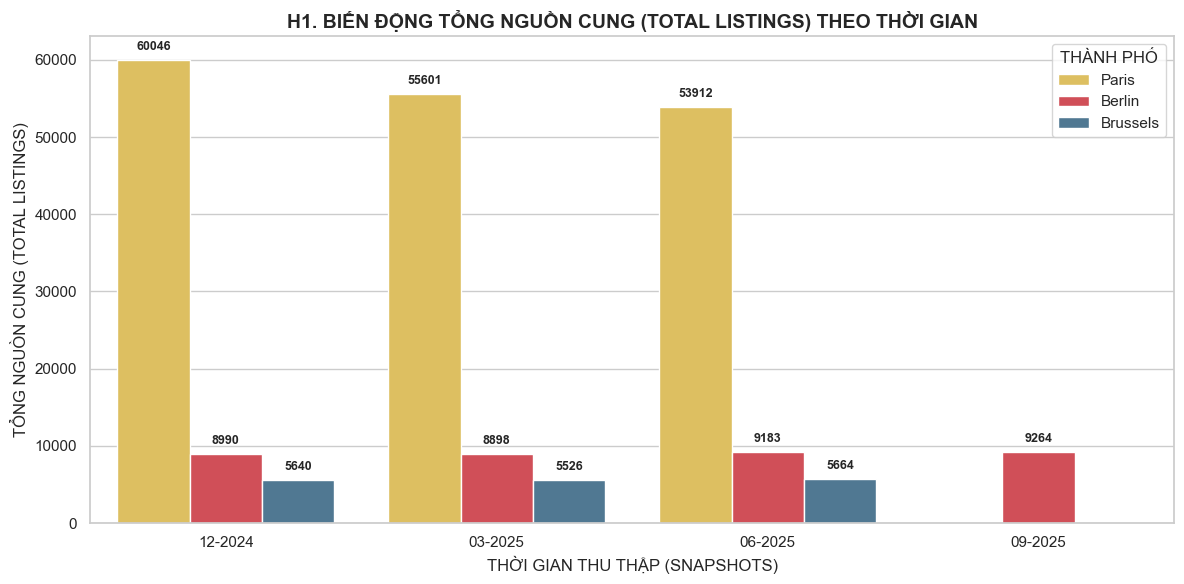

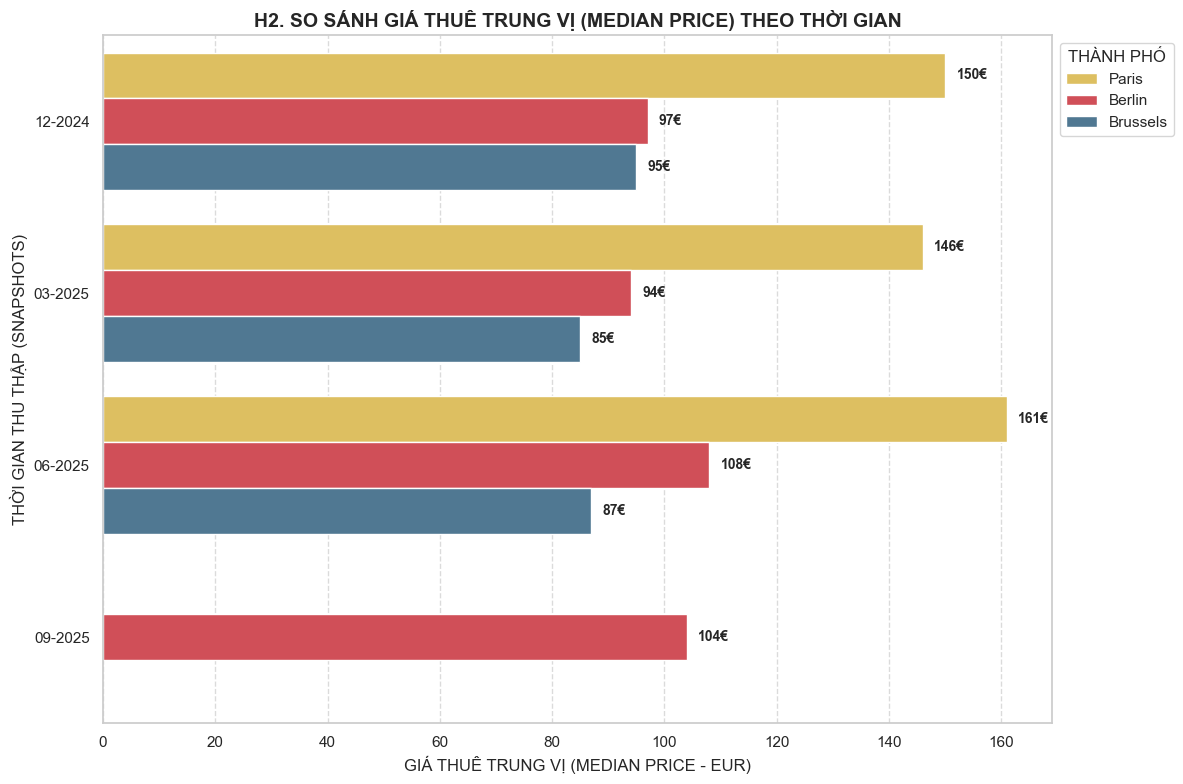

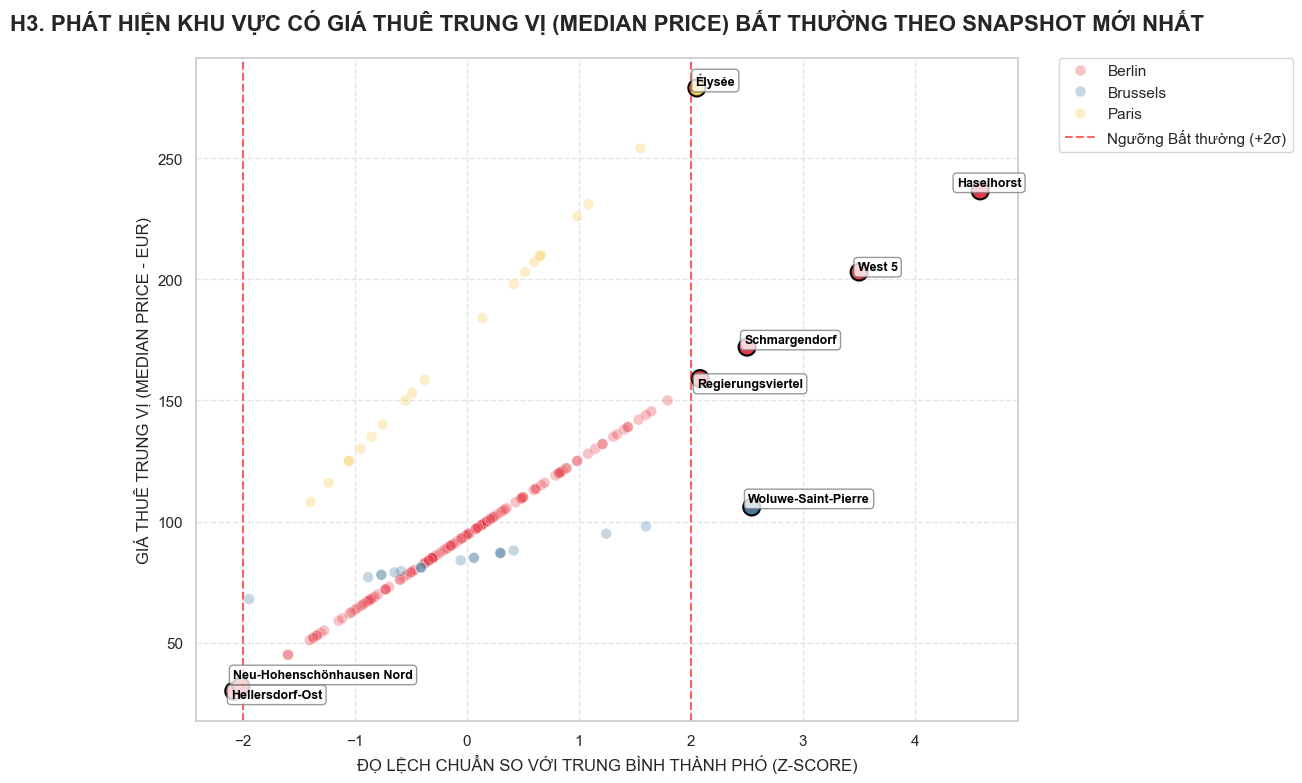

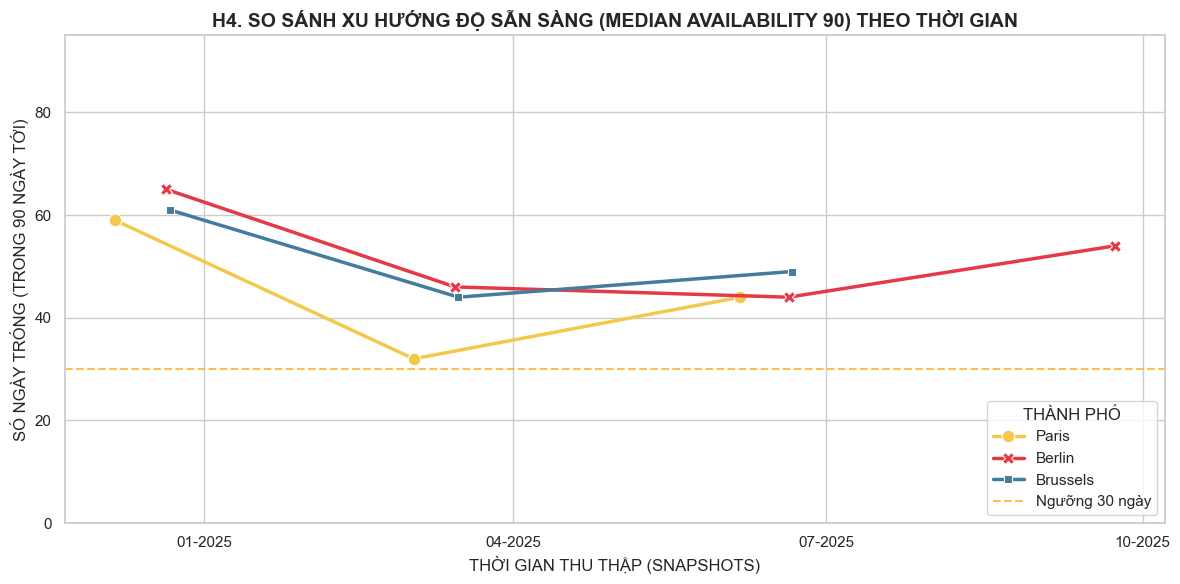

<Figure size 1000x700 with 0 Axes>

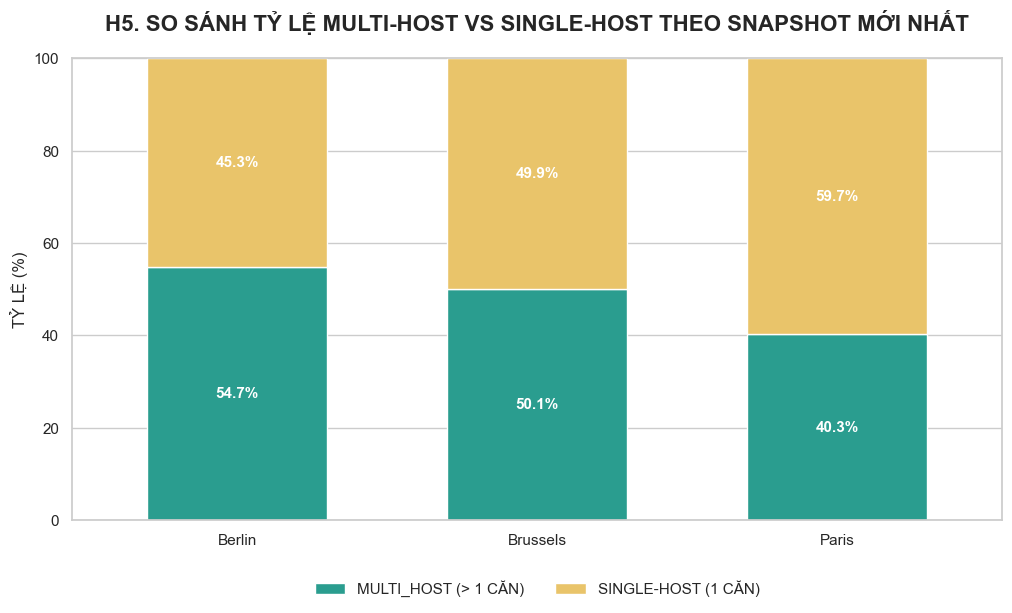

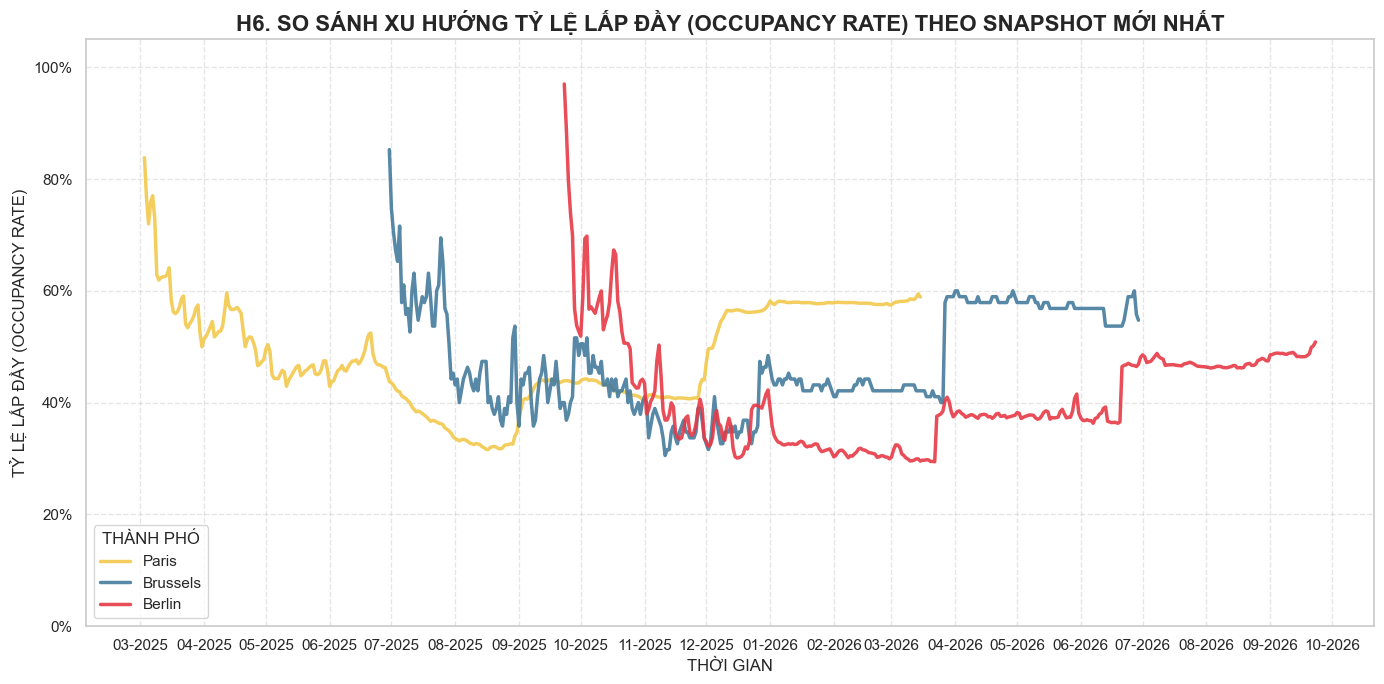

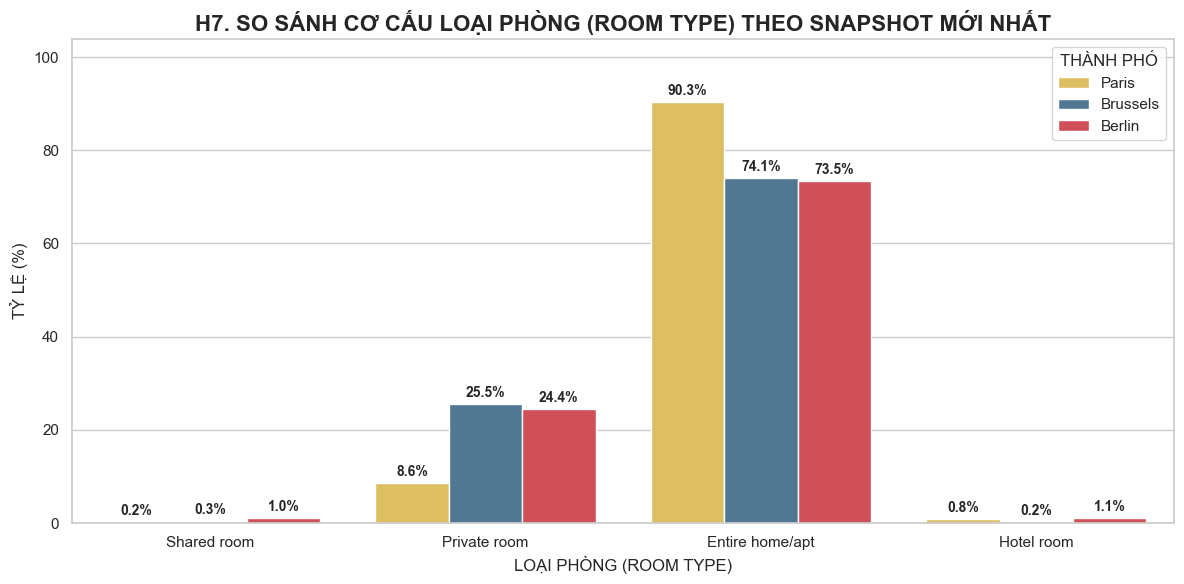

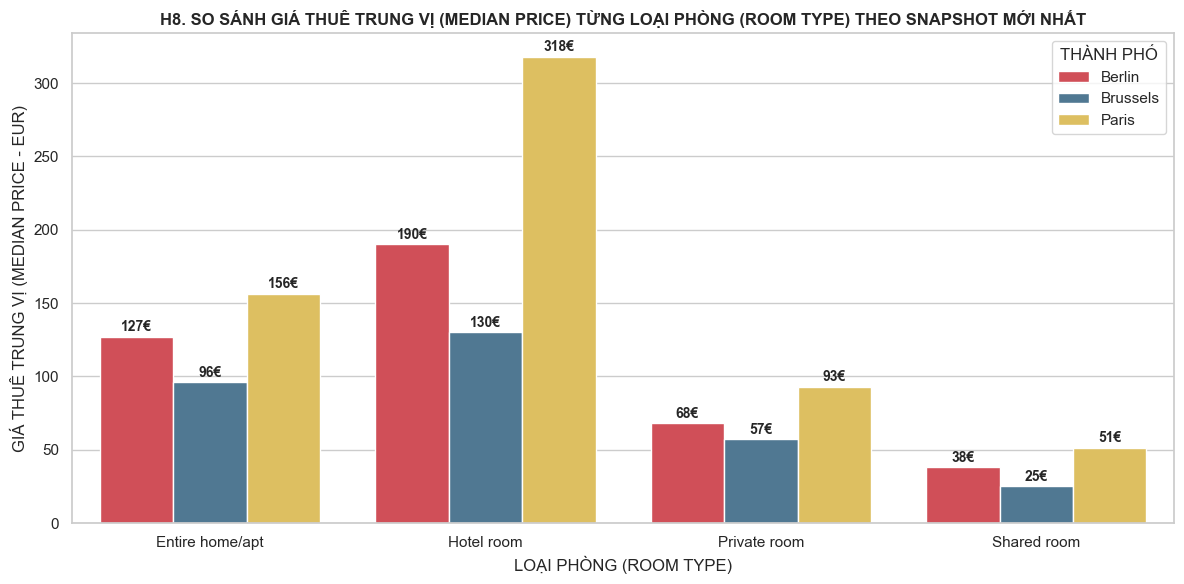

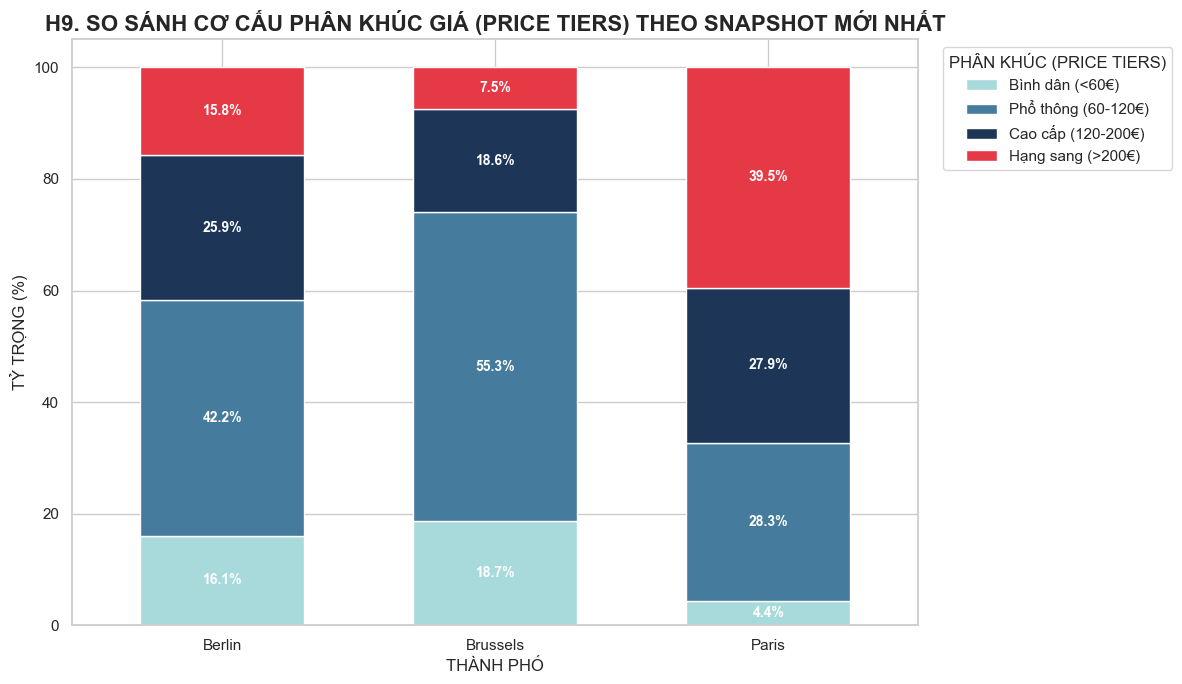

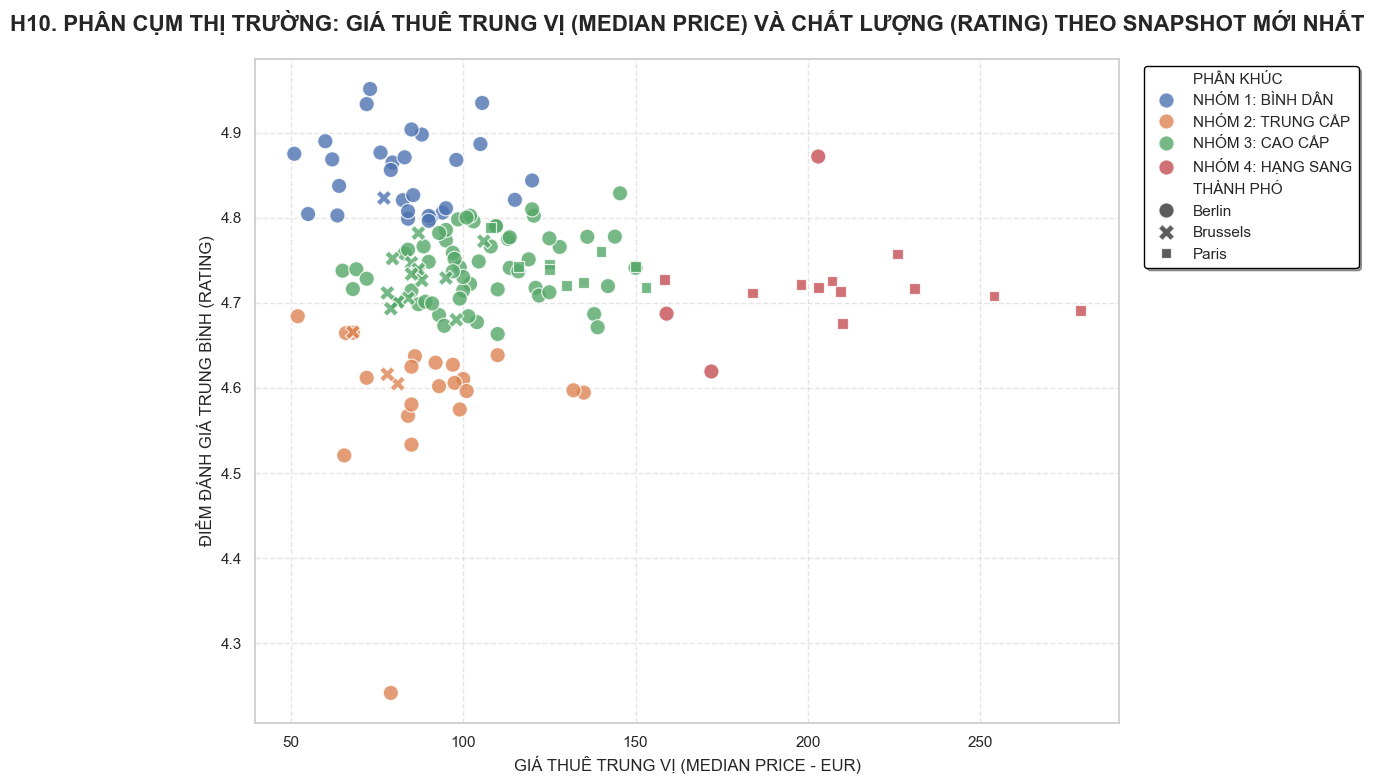

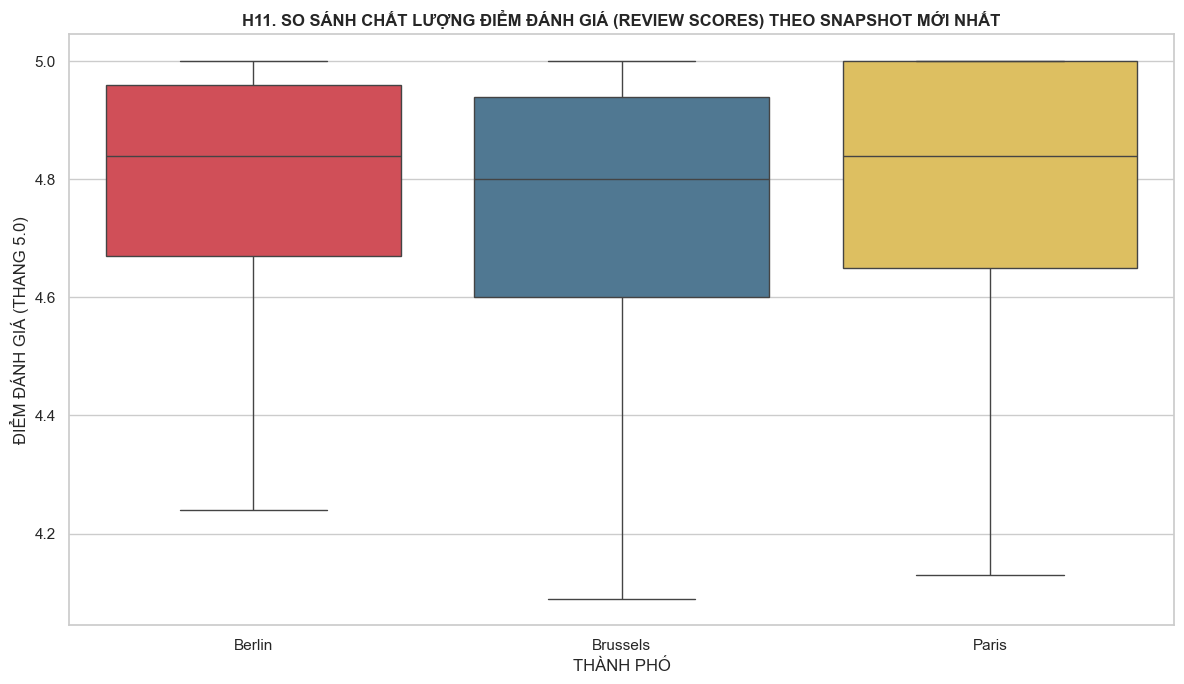

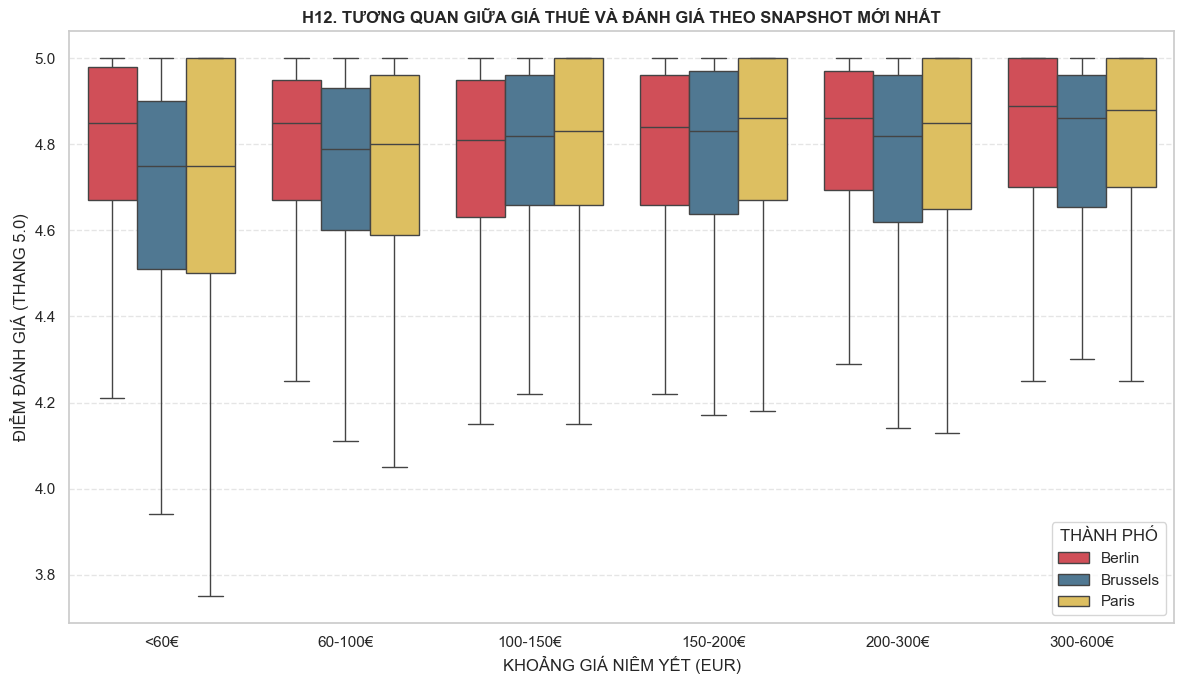

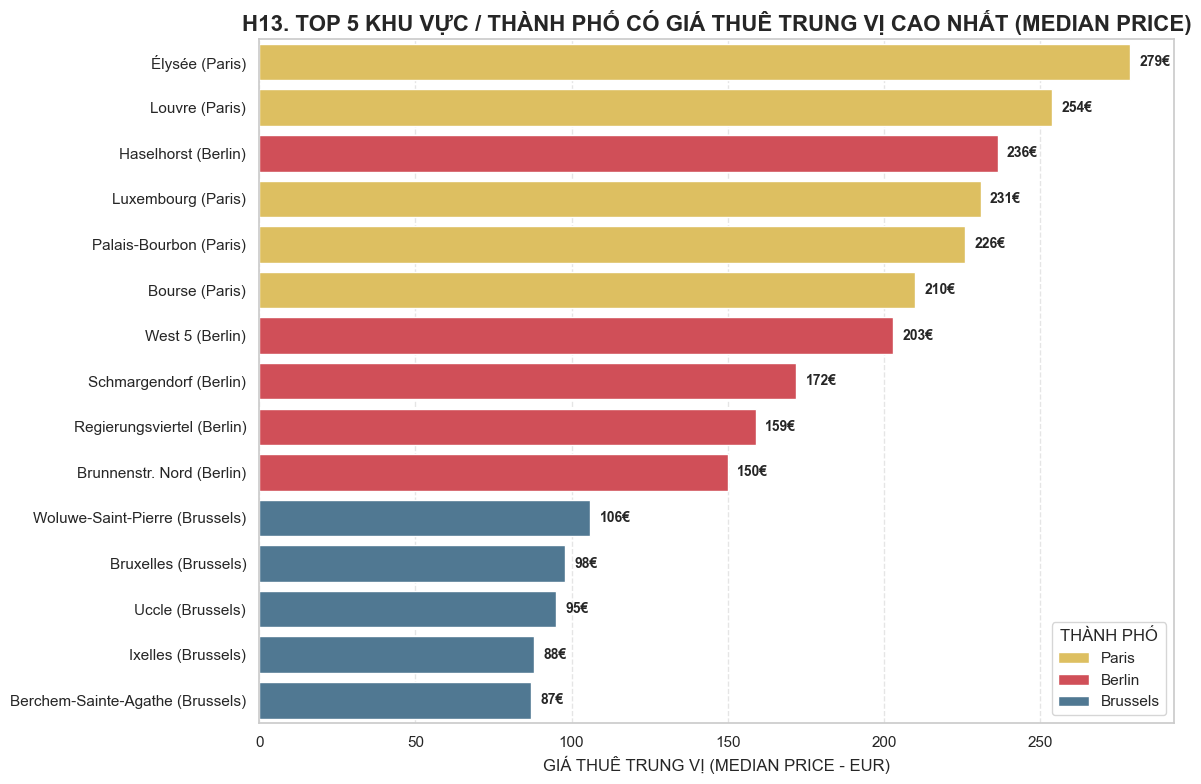

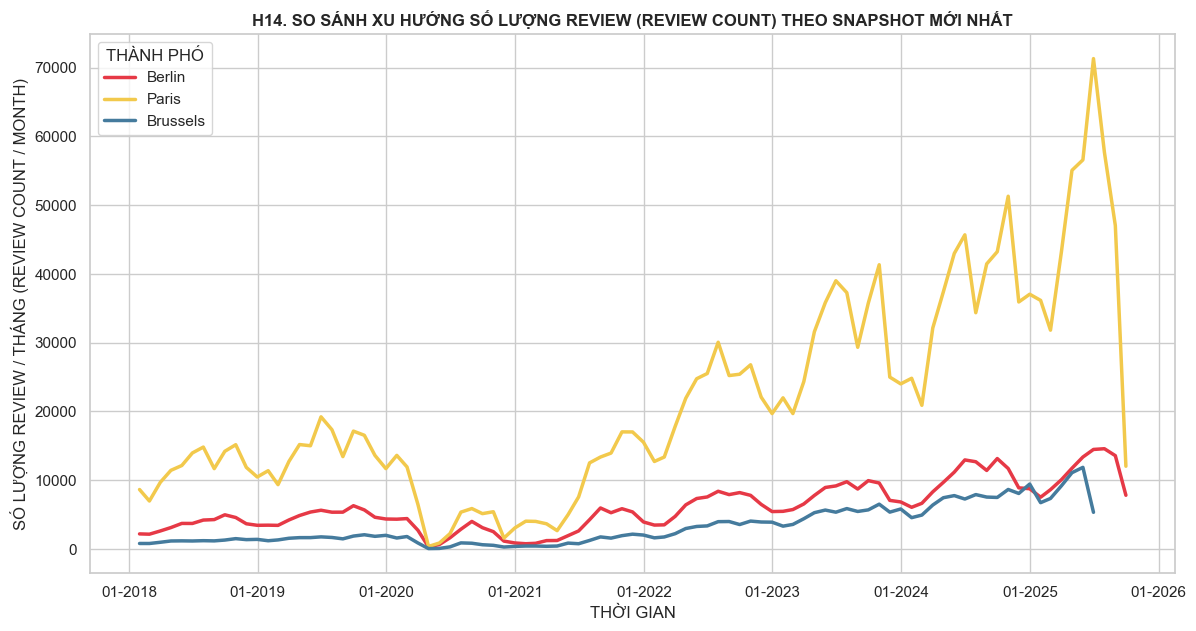

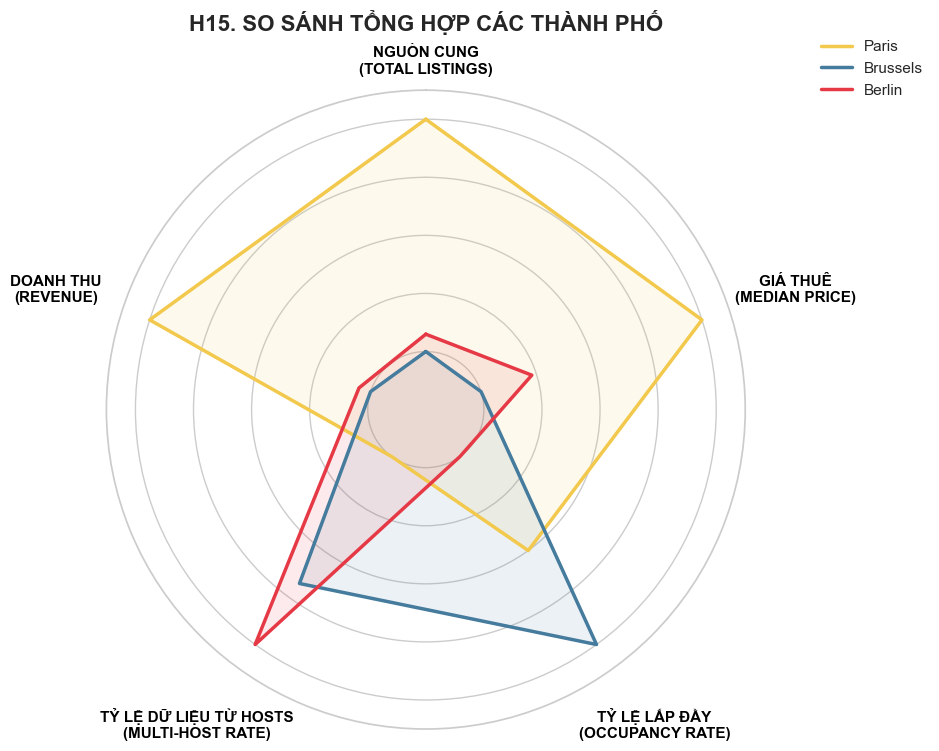

In [8]:
# SO SÁNH TỔNG HỢP 3 THÀNH PHỐ


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from math import pi
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
!pip install adjustText


# ==============================================================================
# 0. CONFIG
# ==============================================================================
BASE_DIR = '..'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)

sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.figsize': (12, 6), 'font.size': 12})

CITY_COLORS = {
    'Berlin': '#E63946',
    'Brussels': '#457B9D',
    'Paris': '#F2C94C'
}

# ==============================================================================
# HELPERS
# ==============================================================================
def safe_capitalize_city(name):
    """Normalize city folder name -> Title case single token (Berlin, Brussels, Paris)."""
    if not isinstance(name, str): 
        return name
    name = name.strip()
    # if folder contains underscores or spaces, take first token (assumes structure processed/<city>/...)
    token = name.split(os.sep)[-1].split('_')[0].split()[0]
    return token.capitalize()

def parse_flexible_date(s):
    """Try several likely date formats, return pd.Timestamp or NaT."""
    if pd.isna(s): 
        return pd.NaT
    s = str(s).strip()
    formats = ["%d %B, %Y", "%d %B %Y", "%Y-%m-%d", "%d-%m-%Y", "%d %b, %Y", "%d %b %Y"]
    for fmt in formats:
        try:
            return pd.to_datetime(datetime.strptime(s, fmt))
        except Exception:
            continue
    # fallback to pandas parser
    try:
        return pd.to_datetime(s, dayfirst=True, errors='coerce')
    except:
        return pd.NaT

def load_kpi_data(pattern):
    """Load KPI files matching pattern under processed/*/<pattern> and append City column."""
    all_files = glob.glob(os.path.join(PROCESSED_DIR, '*', pattern))
    df_list = []
    for f in all_files:
        city_folder = os.path.basename(os.path.dirname(f))
        city = safe_capitalize_city(city_folder)
        try:
            df = pd.read_csv(f)
            df['City'] = city
            df_list.append(df)
        except Exception:
            continue
    return pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame()

def load_latest_listing_for_city(city):
    """Return the most recent listings_processed.csv for a given city folder (by parsing snapshot folder names)."""
    city_path = os.path.join(PROCESSED_DIR, city.lower())
    if not os.path.exists(city_path):
        # try capitalized
        city_path = os.path.join(PROCESSED_DIR, city)
        if not os.path.exists(city_path):
            return pd.DataFrame()
    # get folders
    folders = [d for d in os.listdir(city_path) if os.path.isdir(os.path.join(city_path, d))]
    # parse dates
    folder_dates = []
    for f in folders:
        dt = parse_flexible_date(f)
        if not pd.isna(dt):
            folder_dates.append((f, dt))
    if not folder_dates:
        return pd.DataFrame()
    # sort by date desc and pick first valid file
    folder_dates = sorted(folder_dates, key=lambda x: x[1], reverse=True)
    for f, _ in folder_dates:
        fp = os.path.join(city_path, f, 'listings_processed.csv')
        if os.path.exists(fp):
            try:
                df = pd.read_csv(fp, low_memory=False)
                if not df.empty and 'price_numeric' in df.columns and df['price_numeric'].notna().sum() > 0:
                    df['City'] = safe_capitalize_city(city)
                    return df
            except Exception:
                continue
    return pd.DataFrame()

# ==============================================================================
# LOAD RAW LISTINGS LATEST PER CITY 
# ==============================================================================
cities_list = ['berlin', 'brussels', 'paris']
df_listings_all = []
for city in cities_list:
    df_city = load_latest_listing_for_city(city)
    if not df_city.empty:
        df_listings_all.append(df_city)
df_detail = pd.concat(df_listings_all, ignore_index=True) if df_listings_all else pd.DataFrame()

# ==============================================================================
# LOAD KPI SUMMARY / ROOM / SEASONALITY
# ==============================================================================
print("--- BẮT ĐẦU VẼ TỔNG HỢP CHO BRUSSELS, BERLIN, PARIS ---")
print("--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---")
df_summary = load_kpi_data('kpi_summary_general_*.csv')
df_room = load_kpi_data('kpi_room_type_*.csv')
df_season = load_kpi_data('kpi_seasonality_*.csv')
df_neigh_kpi = load_kpi_data('kpi_neighbourhood_*.csv')
df_review_kpi = load_kpi_data('kpi_reviews_trend_*.csv')

# Clean summary
if not df_summary.empty:
    # ensure numeric where expected
    for col in ['total_listings', 'median_price', 'median_avail_90', 'multi_host_rate']:
        if col in df_summary.columns:
            df_summary[col] = pd.to_numeric(df_summary[col], errors='coerce')
    df_clean_sum = df_summary[(df_summary['total_listings'].fillna(0) > 0) & (df_summary.get('median_price').notna())].copy()
    df_clean_sum['snapshot_dt'] = df_clean_sum['snapshot_date'].apply(parse_flexible_date)
    df_clean_sum = df_clean_sum.dropna(subset=['snapshot_dt'])
    valid_keys = set(zip(df_clean_sum['City'], df_clean_sum['snapshot_date']))
else:
    print("⚠️ Không có dữ liệu summary!")
    df_clean_sum = pd.DataFrame()
    valid_keys = set()

# ==============================================================================
# PLOTS H1-H6
# ==============================================================================

# H1: Total listings (bar by snapshot month-year, grouped by city)
if not df_summary.empty:
    df_h1 = df_summary.copy()
    df_h1['snapshot_dt'] = df_h1['snapshot_date'].apply(parse_flexible_date)
    df_h1 = df_h1.dropna(subset=['snapshot_dt'])
    df_h1['Period'] = df_h1['snapshot_dt'].dt.strftime('%m-%Y')
    df_h1 = df_h1.sort_values('snapshot_dt')

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=df_h1, x='Period', y='total_listings', hue='City', palette=CITY_COLORS)
    for p in ax.patches:
        h = p.get_height()
        if h and h > 0:
            ax.annotate(f'{int(h)}', (p.get_x() + p.get_width() / 2., h),
                        ha='center', va='bottom', xytext=(0, 5), textcoords='offset points',
                        fontsize=9, fontweight='bold')
    plt.title('H1. BIẾN ĐỘNG TỔNG NGUỒN CUNG (TOTAL LISTINGS) THEO THỜI GIAN', fontweight='bold', fontsize=14)
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.legend(title='THÀNH PHỐ', loc='upper right')
    save_path = os.path.join(FIGURES_DIR, 'H01_Total_Supply_All_Snapshots.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()
    

# H2: Median price (horizontal)
if not df_clean_sum.empty:
    df_h2 = df_clean_sum.copy()
    df_h2 = df_h2.sort_values('snapshot_dt')
    df_h2['Period'] = df_h2['snapshot_dt'].dt.strftime('%m-%Y')

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df_h2, x='median_price', y='Period', hue='City', palette=CITY_COLORS, orient='h')

    for p in ax.patches:
        width = p.get_width()
        if width and width > 0:
            ax.text(width + 2, p.get_y() + p.get_height() / 2, f'{int(width)}€',
                    ha='left', va='center', fontsize=10, fontweight='bold')
    plt.title('H2. SO SÁNH GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) THEO THỜI GIAN', fontweight='bold', fontsize=14)
    plt.xlabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.ylabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.legend(title='THÀNH PHỐ', bbox_to_anchor=(1, 1))
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    save_path = os.path.join(FIGURES_DIR, 'H02_Median_Price_Horizontal.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()


# H3: Z-SCORE
# Giả định các biến môi trường đã có:
# df_detail, FIGURES_DIR, CITY_COLORS

if not df_detail.empty and 'neighbourhood_cleansed' in df_detail.columns:
    # 1. Chuẩn bị dữ liệu
    df_anom = df_detail.copy()
    
    # Chuyển đổi số và loại bỏ lỗi
    df_anom['price_numeric'] = pd.to_numeric(df_anom['price_numeric'], errors='coerce')
    df_anom = df_anom.dropna(subset=['price_numeric', 'neighbourhood_cleansed'])

    # 2. Aggregation: Tính giá trung vị cho từng khu vực
    neigh_price = (
        df_anom
        .groupby(['City', 'neighbourhood_cleansed'])['price_numeric']
        .median()
        .reset_index()
    )

    # Lọc bỏ các thành phố có ít hơn 3 khu vực (để tính std có ý nghĩa)
    city_counts = neigh_price['City'].value_counts()
    valid_cities = city_counts[city_counts > 2].index
    neigh_price = neigh_price[neigh_price['City'].isin(valid_cities)].copy()

    # 3. Tính Z-score per city
    # Sử dụng ddof=1 cho độ lệch chuẩn mẫu (sample std dev)
    # Xử lý trường hợp std = 0 bằng cách thay thế kết quả NaN/Inf bằng 0
    def calculate_zscore(x):
        std = x.std(ddof=1)
        if std == 0:
            return np.zeros_like(x)
        return (x - x.mean()) / std

    neigh_price['z_score'] = neigh_price.groupby('City')['price_numeric'] \
        .transform(calculate_zscore)

    # Lọc Anomaly
    anomalies = neigh_price[neigh_price['z_score'].abs() >= 2]

    # 4. Vẽ biểu đồ
    plt.figure(figsize=(12, 8)) # Tăng chiều cao một chút
    
    # Layer 1: Tất cả các điểm (Mờ)
    sns.scatterplot(
        data=neigh_price,
        x='z_score',
        y='price_numeric',
        hue='City',
        palette=CITY_COLORS,
        alpha=0.3, # Giảm alpha để làm nổi bật anomalies hơn
        s=60,
        legend=True # Giữ legend ở đây
    )

    # Layer 2: Chỉ các điểm bất thường (Nổi bật)
    sns.scatterplot(
        data=anomalies,
        x='z_score',
        y='price_numeric',
        hue='City',
        palette=CITY_COLORS,
        s=150,
        legend=False,
        edgecolor='black',
        linewidth=1.5,
        marker='o' # Đảm bảo hình dạng rõ ràng
    )

    # Layer 3: Annotations (Nhãn)
    texts = []
    for i, row in anomalies.iterrows():
    # SỬA Ở ĐÂY: Dùng hàm abs() để lấy cả 2 bên (lớn hơn 2 hoặc nhỏ hơn -2)
        if abs(row['z_score']) >= 2: 
            texts.append(plt.text(
            row['z_score'], 
            row['price_numeric'], 
            row['neighbourhood_cleansed'], 
            fontsize=9, 
            color='black', 
            weight='bold',
            # Thêm alpha=0.8 để nền trắng che bớt các điểm phía sau cho dễ đọc
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.3')
        ))

    # Cố gắng sử dụng adjust_text để chống đè chữ (nếu thư viện có sẵn)
    try:
        from adjustText import adjust_text
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    except ImportError:
        pass # Nếu không có thư viện thì giữ nguyên vị trí mặc định

    # Lines & Decor
    plt.axvline(2, color='red', linestyle='--', alpha=0.6, label='Ngưỡng Bất thường (+2σ)')
    plt.axvline(-2, color='red', linestyle='--', alpha=0.6)

    plt.title('H3. PHÁT HIỆN KHU VỰC CÓ GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) BẤT THƯỜNG THEO SNAPSHOT MỚI NHẤT', 
              fontweight='bold', fontsize=16, pad=20)
    plt.xlabel('ĐỘ LỆCH CHUẨN SO VỚI TRUNG BÌNH THÀNH PHỐ (Z-SCORE)')
    plt.ylabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    
    # Xử lý Legend để không bị trùng lặp
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # Lưu và hiển thị
    if not os.path.exists(FIGURES_DIR):
        os.makedirs(FIGURES_DIR)
    plt.savefig(os.path.join(FIGURES_DIR, 'H03_Price_Anomaly_ZScore.pdf'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Dữ liệu không đủ hoặc thiếu cột cần thiết.")




# H4: Availability trend (median_avail_90)
if not df_clean_sum.empty and 'median_avail_90' in df_clean_sum.columns:
    df_h3 = df_clean_sum[df_clean_sum['median_avail_90'].notna()].copy()
    df_h3 = df_h3.sort_values('snapshot_dt')
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_h3, x='snapshot_dt', y='median_avail_90', hue='City', palette=CITY_COLORS,
                 style='City', markers=True, dashes=False, linewidth=2.5, markersize=9)
    plt.axhline(30, color='orange', linestyle='--', alpha=0.7, label='Ngưỡng 30 ngày')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.title('H4. SO SÁNH XU HƯỚNG ĐỘ SẴN SÀNG (MEDIAN AVAILABILITY 90) THEO THỜI GIAN', fontweight='bold', fontsize=14)
    plt.ylabel('SỐ NGÀY TRỐNG (TRONG 90 NGÀY TỚI)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.ylim(0, 95)
    plt.legend(title='THÀNH PHỐ', loc='lower right')
    save_path = os.path.join(FIGURES_DIR, 'H04_Availability_Trend.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()






# H5: Multi-host stacked bar (latest snapshot per city)
if not df_clean_sum.empty and 'multi_host_rate' in df_clean_sum.columns:
    df_latest = df_clean_sum.sort_values('snapshot_dt').groupby('City').tail(1).copy()
    df_latest['single_host_rate'] = 100 - df_latest['multi_host_rate']
    plot_data = df_latest.set_index('City')[['multi_host_rate', 'single_host_rate']]
    plot_data = plot_data.sort_values('multi_host_rate', ascending=False)
    plt.figure(figsize=(10, 7))
    ax = plot_data.plot(kind='bar', stacked=True, color=['#2A9D8F', '#E9C46A'], width=0.6, rot=0)
    for c in ax.containers:
        labels = [f'{v.get_height():.1f}%' if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontsize=11, fontweight='bold', color='white')
    plt.title('H5. SO SÁNH TỶ LỆ MULTI-HOST VS SINGLE-HOST THEO SNAPSHOT MỚI NHẤT', fontweight='bold', fontsize=16, pad=20)
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('')
    plt.ylim(0, 100)
    plt.legend(['MULTI_HOST (> 1 CĂN)', 'SINGLE-HOST (1 CĂN)'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)
    save_path = os.path.join(FIGURES_DIR, 'H05_MultiHost_Stacked.pdf')
    plt.savefig(save_path, format='pdf', bbox_inches='tight', pad_inches=0.5)
    plt.show()
    

# H6: Occupancy rate - plot daily series for latest snapshot per city
if not df_season.empty and 'date' in df_season.columns and 'occupancy_rate' in df_season.columns:
    df_h5 = df_season.copy()
    df_h5['date_dt'] = pd.to_datetime(df_h5['date'], errors='coerce')
    df_h5['snapshot_dt'] = df_h5['snapshot_date'].apply(parse_flexible_date)
    df_h5 = df_h5.dropna(subset=['snapshot_dt'])
    latest_snaps = df_h5.groupby('City')['snapshot_dt'].max()
    df_final_h5 = df_h5[df_h5.apply(lambda r: r['snapshot_dt'] == latest_snaps.get(r['City'], pd.NaT), axis=1)]
    df_final_h5 = df_final_h5.sort_values('date_dt')
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_final_h5, x='date_dt', y='occupancy_rate', hue='City', palette=CITY_COLORS, linewidth=2.5, alpha=0.9)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.title('H6. SO SÁNH XU HƯỚNG TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE) THEO SNAPSHOT MỚI NHẤT', fontweight='bold', fontsize=16)
    plt.ylabel('TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE)')
    plt.xlabel('THỜI GIAN')
    plt.legend(title='THÀNH PHỐ', loc='lower left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.ylim(0, 1.05)
    save_path = os.path.join(FIGURES_DIR, 'H06_Occupancy_Rate_LineChart.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()
    

# H7: Room type composition (latest snapshot)
if not df_room.empty and not df_clean_sum.empty:
    
    df_room = df_room.copy()
    df_room['key'] = list(zip(df_room['City'], df_room['snapshot_date']))
    df_room_clean = df_room[df_room['key'].isin(valid_keys)].copy()
    df_room_clean['snapshot_dt'] = df_room_clean['snapshot_date'].apply(parse_flexible_date)
    latest_room = df_room_clean.sort_values('snapshot_dt').groupby(['City', 'room_type']).tail(1)
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=latest_room, x='room_type', y='percentage', hue='City', palette=CITY_COLORS)
    for p in ax.patches:
        height = p.get_height()
        if height and height > 0:
            ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', xytext=(0, 3), textcoords='offset points', fontweight='bold', fontsize=10)
    plt.title('H7. SO SÁNH CƠ CẤU LOẠI PHÒNG (ROOM TYPE) THEO SNAPSHOT MỚI NHẤT', fontweight='bold', fontsize=16)
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('LOẠI PHÒNG (ROOM TYPE)')
    plt.legend(title='THÀNH PHỐ')
    if not latest_room['percentage'].empty:
        plt.ylim(0, latest_room['percentage'].max() * 1.15)
    save_path = os.path.join(FIGURES_DIR, 'H07_Room_Type_GroupedBar.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()




# H8: Price by Room Type (Grouped Bar)
if not df_detail.empty and 'review_scores_rating' in df_detail.columns:
    df_clean = df_detail.copy()
    df_clean['review_scores_rating'] = pd.to_numeric(df_clean['review_scores_rating'], errors='coerce')
    df_clean['price_numeric'] = pd.to_numeric(df_clean['price_numeric'], errors='coerce')
    df_clean = df_clean.dropna(subset=['review_scores_rating', 'price_numeric', 'room_type'])
    price_room = df_clean.groupby(['City', 'room_type'])['price_numeric'].median().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=price_room, x='room_type', y='price_numeric', 
                hue='City', palette=CITY_COLORS)
    plt.title('H8. SO SÁNH GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) TỪNG LOẠI PHÒNG (ROOM TYPE) THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.ylabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.xlabel('LOẠI PHÒNG (ROOM TYPE)')
    plt.legend(title = 'THÀNH PHỐ', loc = 'upper right')
    ax = plt.gca()
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{int(p.get_height())}€', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10, fontweight='bold', xytext=(0, 2), textcoords='offset points')

    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'H08_Price_RoomType.pdf'))
    plt.show()
    



# H9: Price segments stacked bar
if not df_detail.empty and 'price_numeric' in df_detail.columns:
    bins = [0, 60, 120, 200, 99999]
    labels = ['Bình dân (<60€)', 'Phổ thông (60-120€)', 'Cao cấp (120-200€)', 'Hạng sang (>200€)']
    df_detail['price_numeric'] = pd.to_numeric(df_detail['price_numeric'], errors='coerce')
    df_detail = df_detail.dropna(subset=['price_numeric'])
    df_detail['Price_Tier'] = pd.cut(df_detail['price_numeric'], bins=bins, labels=labels, right=False)
    tier_counts = df_detail.groupby(['City', 'Price_Tier'], observed=True).size().reset_index(name='count')
    total_counts = df_detail.groupby('City')['price_numeric'].count().reset_index(name='total')
    tier_data = tier_counts.merge(total_counts, on='City')
    tier_data['percentage'] = (tier_data['count'] / tier_data['total']) * 100
    pivot_tier = tier_data.pivot(index='City', columns='Price_Tier', values='percentage').fillna(0)
    colors = ['#A8DADC', '#457B9D', '#1D3557', '#E63946']
    ax = pivot_tier.plot(kind='bar', stacked=True, figsize=(12, 7), color=colors, rot=0, width=0.6)
    for c in ax.containers:
        labels_text = [f'{v.get_height():.1f}%' if v.get_height() > 3 else '' for v in c]
        ax.bar_label(c, labels=labels_text, label_type='center', color='white', fontweight='bold', fontsize=10)
    plt.title('H9. SO SÁNH CƠ CẤU PHÂN KHÚC GIÁ (PRICE TIERS) THEO SNAPSHOT MỚI NHẤT', fontweight='bold', fontsize=16)
    plt.xlabel('THÀNH PHỐ')
    plt.ylabel('TỶ TRỌNG (%)')
    plt.legend(title='PHÂN KHÚC (PRICE TIERS)', bbox_to_anchor=(1.02, 1), loc='upper left')
    save_path = os.path.join(FIGURES_DIR, 'H09_Price_Segments.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()


# H10: K-MEANS
# 1. Chuẩn bị dữ liệu
if not df_detail.empty and 'review_scores_rating' in df_detail.columns:
    df_cluster = df_detail.copy()
    df_cluster['price_numeric'] = pd.to_numeric(df_cluster['price_numeric'], errors='coerce')
    df_cluster['review_scores_rating'] = pd.to_numeric(df_cluster['review_scores_rating'], errors='coerce')
    
    # Gom nhóm theo khu vực
    neigh_stats = df_cluster.groupby(['City', 'neighbourhood_cleansed']).agg({
        'price_numeric': 'median',
        'review_scores_rating': 'mean',
        'id': 'count'
    }).reset_index()
    
    # Lọc các khu vực quá nhỏ (< 10 listings) để tránh nhiễu
    neigh_stats = neigh_stats[neigh_stats['id'] > 10].dropna()

    # 2. Scaling & K-Means
    features = ['price_numeric', 'review_scores_rating']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(neigh_stats[features])

    k = 4 
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    neigh_stats['cluster_raw'] = kmeans.fit_predict(X_scaled)

    # Tính giá trung bình của từng cụm để sắp xếp từ Rẻ -> Đắt
    cluster_avg_price = neigh_stats.groupby('cluster_raw')['price_numeric'].mean().sort_values()
    
    reorder_map = {old_label: i for i, old_label in enumerate(cluster_avg_price.index)}
    
    neigh_stats['cluster_ordered'] = neigh_stats['cluster_raw'].map(reorder_map)
    
    labels_name = {
        0: 'NHÓM 1: BÌNH DÂN',
        1: 'NHÓM 2: TRUNG CẤP',
        2: 'NHÓM 3: CAO CẤP',
        3: 'NHÓM 4: HẠNG SANG'
    }
    neigh_stats['Segment'] = neigh_stats['cluster_ordered'].map(labels_name)
    neigh_stats = neigh_stats.rename(columns={
        'Segment': 'PHÂN KHÚC',
        'City': 'THÀNH PHỐ'
    })

    order_list = [
        'NHÓM 1: BÌNH DÂN', 
        'NHÓM 2: TRUNG CẤP', 
        'NHÓM 3: CAO CẤP', 
        'NHÓM 4: HẠNG SANG'
    ]

    plt.figure(figsize=(12, 8))
    
    sns.scatterplot(
        data=neigh_stats,
        x='price_numeric',
        y='review_scores_rating',
        hue='PHÂN KHÚC',     
        style='THÀNH PHỐ',   
        palette='deep',      
        s=120,               
        alpha=0.8,
        edgecolor='w',
        hue_order=order_list        
    )
    
    centers = scaler.inverse_transform(kmeans.cluster_centers_)

    plt.title('H10. PHÂN CỤM THỊ TRƯỜNG: GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) VÀ CHẤT LƯỢNG (RATING) THEO SNAPSHOT MỚI NHẤT', 
              fontweight='bold', fontsize=16, pad=20)
    plt.xlabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.ylabel('ĐIỂM ĐÁNH GIÁ TRUNG BÌNH (RATING)')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, edgecolor = 'black', facecolor = 'white', framealpha = 1, fancybox = True, shadow = True)
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'H10_KMeans_Price_Quality.pdf'), bbox_inches='tight')
    plt.show()


    # H11: Quality Comparison (Boxplot)
    # -------------------------------------------------------
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_clean, x='City', y='review_scores_rating', 
                hue='City', palette=CITY_COLORS, showfliers=False, legend=False)
    plt.title('H11. SO SÁNH CHẤT LƯỢNG ĐIỂM ĐÁNH GIÁ (REVIEW SCORES) THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.xlabel('THÀNH PHỐ')
    plt.ylabel('ĐIỂM ĐÁNH GIÁ (THANG 5.0)')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'H11_Quality_Scores.pdf'))
    plt.show()

    # H12: COMPARE PRICE AND REVIEWS
    plt.figure(figsize=(12, 7))
    price_bins = [0, 60, 100, 150, 200, 300, 600]
    bin_labels = ['<60€', '60-100€', '100-150€', '150-200€', '200-300€', '300-600€']
    df_clean.loc[:, 'price_range_group'] = pd.cut(df_clean['price_numeric'], bins=price_bins, labels=bin_labels)
    sns.boxplot(data=df_clean, x='price_range_group', y='review_scores_rating', 
                hue='City', palette=CITY_COLORS, showfliers=False) 
    
    plt.title('H12. TƯƠNG QUAN GIỮA GIÁ THUÊ VÀ ĐÁNH GIÁ THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.xlabel('KHOẢNG GIÁ NIÊM YẾT (EUR)')
    plt.ylabel('ĐIỂM ĐÁNH GIÁ (THANG 5.0)')
    plt.legend(title='THÀNH PHỐ', loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'H12_Price_Quality_Boxplot.pdf'))
    plt.show()
    

# H13: Top neighborhoods by median price (top 5 per city)
if not df_detail.empty and 'neighbourhood_cleansed' in df_detail.columns and 'price_numeric' in df_detail.columns:
    df_detail = df_detail[df_detail['neighbourhood_cleansed'].notna()].copy()
    neigh_stats = df_detail.groupby(['City', 'neighbourhood_cleansed'], observed=True)['price_numeric'].median().reset_index()
    top_neighs = neigh_stats.sort_values(['City', 'price_numeric'], ascending=[True, False]).groupby('City').head(5)
    top_neighs = top_neighs.sort_values('price_numeric', ascending=False)
    top_neighs['Label'] = top_neighs['neighbourhood_cleansed'] + " (" + top_neighs['City'] + ")"

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=top_neighs, x='price_numeric', y='Label', hue='City', palette=CITY_COLORS, dodge=False)
    for p in ax.patches:
        width = p.get_width()
        if width and width > 0:
            ax.text(width + 3, p.get_y() + p.get_height() / 2, f'{int(width)}€', va='center', fontweight='bold', fontsize=10)
    plt.title('H13. TOP 5 KHU VỰC / THÀNH PHỐ CÓ GIÁ THUÊ TRUNG VỊ CAO NHẤT (MEDIAN PRICE)', fontweight='bold', fontsize=16)
    plt.xlabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.ylabel('')
    plt.legend(title='THÀNH PHỐ', loc='lower right')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(FIGURES_DIR, 'H13_Top15_Neighborhoods.pdf')
    plt.savefig(save_path, format='pdf')
    plt.show()
    


# H14: REVIEW TRENDS 
if not df_review_kpi.empty:
    df_rev = df_review_kpi.copy()
    df_rev['date'] = pd.to_datetime(df_rev['date'])
    df_rev['snap_dt'] = df_rev['snapshot_date'].apply(parse_flexible_date)
    latest_snaps = df_rev.groupby('City')['snap_dt'].max()
    df_rev_final = df_rev[df_rev.apply(lambda x: x['snap_dt'] == latest_snaps.get(x['City'], pd.NaT), axis=1)].copy()
    
    # Lọc từ 2018
    df_rev_final = df_rev_final[df_rev_final['date'].dt.year >= 2018].sort_values('date')

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_rev_final, x='date', y='review_count', hue='City', palette=CITY_COLORS, linewidth=2.5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    plt.title('H14. SO SÁNH XU HƯỚNG SỐ LƯỢNG REVIEW (REVIEW COUNT) THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.ylabel('SỐ LƯỢNG REVIEW / THÁNG (REVIEW COUNT / MONTH)')
    plt.xlabel('THỜI GIAN')
    plt.legend(title='THÀNH PHỐ')
    plt.savefig(os.path.join(FIGURES_DIR, 'H14_Reviews_Trend.pdf'), bbox_inches='tight')
    plt.show()




# ==============================================================================
# RADAR SUMMARY (H13)
# ==============================================================================
if not df_clean_sum.empty:
    df_radar_latest = df_clean_sum.sort_values('snapshot_dt').groupby('City').tail(1).copy()
    
    if not df_season.empty and 'occupancy_rate' in df_season.columns:
        df_season_tmp = df_season.copy()
        df_season_tmp['snapshot_dt'] = df_season_tmp['snapshot_date'].apply(parse_flexible_date)
        df_season_tmp = df_season_tmp.dropna(subset=['snapshot_dt'])
        avg_occ = df_season_tmp.groupby(['City', 'snapshot_date'], observed=True)['occupancy_rate'].mean().reset_index()
        df_radar_latest = df_radar_latest.merge(avg_occ, on=['City', 'snapshot_date'], how='left', suffixes=('', '_avg'))
        if 'occupancy_rate_avg' in df_radar_latest.columns:
            df_radar_latest['occupancy_rate'] = df_radar_latest['occupancy_rate'].fillna(df_radar_latest['occupancy_rate_avg'])
    else:
        df_radar_latest['occupancy_rate'] = df_radar_latest.get('occupancy_rate', 0.5)

    df_radar_latest['occupancy_rate'] = df_radar_latest['occupancy_rate'].fillna(df_radar_latest['occupancy_rate'].mean())
    df_radar_latest['est_revenue'] = df_radar_latest['median_price'] * df_radar_latest['occupancy_rate'] * 30

    categories = ['total_listings', 'median_price', 'occupancy_rate', 'multi_host_rate', 'est_revenue']
    labels_map = ['NGUỒN CUNG\n(TOTAL LISTINGS)', 'GIÁ THUÊ\n(MEDIAN PRICE)', 'TỶ LỆ LẤP ĐẦY\n(OCCUPANCY RATE)', 'TỶ LỆ DỮ LIỆU TỪ HOSTS\n(MULTI-HOST RATE)', 'DOANH THU\n(REVENUE)']

    df_radar = df_radar_latest[['City'] + [c for c in categories if c in df_radar_latest.columns]].copy()
    
    for c in categories:
        if c not in df_radar.columns:
            df_radar[c] = 0

    
    for col in categories:
        min_val = df_radar[col].min()
        max_val = df_radar[col].max()
        if pd.notna(min_val) and pd.notna(max_val) and max_val > min_val:
            df_radar[col] = ((df_radar[col] - min_val) / (max_val - min_val)) * 8 + 2
        else:
            df_radar[col] = 6  

    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks([])
    ax.set_rlabel_position(0)
    plt.yticks([2, 4, 6, 8, 10], ["", "", "", "", ""], color="grey", size=7)
    plt.ylim(0, 11)

    for i, row in df_radar.iterrows():
        values = [row[c] for c in categories]
        values += values[:1]
        city = row['City']
        color = CITY_COLORS.get(city, '#333333')
        ax.plot(angles, values, linewidth=2.5, linestyle='solid', label=city, color=color)
        ax.fill(angles, values, color=color, alpha=0.1)

    
    for angle, label in zip(angles[:-1], labels_map):
        if "NGUỒN CUNG" in label:
            distance = 12.0
        else :
            distance = 13.4
        ax.text(angle, distance, label, horizontalalignment='center', verticalalignment='center', size=11, fontweight='bold', color='black')

    plt.title('H15. SO SÁNH TỔNG HỢP CÁC THÀNH PHỐ', fontweight='bold', fontsize=16, y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11, frameon=False)
    save_path = os.path.join(FIGURES_DIR, 'H15_Radar_Summary.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()



    







In [9]:
print("--- DỰ ÁN HOÀN TẤT ---")

--- DỰ ÁN HOÀN TẤT ---
